In [66]:
from champsim_parser.result_set.manipulators import get_sim_points
from champsim_parser.result_set.manipulators import apply_simpoint, normalize_llc_distill_cache
from champsim_parser.result_set.manipulators import pairing_multicore_result_sets, \
    compute_multicore_weighted_ipc, compute_multicore_speedup
from champsim_parser.result_parsers import distill_cache_parser, multicore_cache_parser
from champsim_parser.parser import MultiCoreParser
from champsim_parser.config_parser import new_caches_parser
from champsim_parser.experiments.experiments import Experiments
from champsim_parser.parser import Parser
from IPython.display import display
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import pandas
import numpy as np
from scipy.stats.mstats import gmean
import re
import sys
import os
from copy import deepcopy
%matplotlib inline


def apply_manipulator_to_all(exp, manip, *args):
    output = Experiments()

    for e in exp.sets:
        output += e(manip, *args)

    return output


def exclude_specs(name, entry):
    re_spec = re.compile(r'^(4.*|6.*)')

    return not re_spec.match(name) and mpki_filter(name, entry)


def only_specs06(name, entry):
    re_spec = re.compile(r'^(4.*)')
    return re_spec.match(name) and mpki_filter(name, entry)


def only_specs17(name, entry):
    re_spec = re.compile(r'^(6.*)')
    return re_spec.match(name) and mpki_filter(name, entry)


def only_ligra(name, entry):
    re_spec = re.compile(r'^ligra_.*')
    return re_spec.match(name) and mpki_filter(name, entry)


def exclude_gapbs(name, entry):
    re_gapbs = re.compile(r'^(bc.*|bfs.*|cc.*|pr.*|tc.*|sssp.*)')

    return not re_gapbs.match(name)


def exclude_ligra(name, entry):
    re_ligra = re.compile(r'^ligra_.*')

    return not re_ligra.match(name) and mpki_filter(name, entry)


def only_gapbs(name, entry):
    re_gapbs = re.compile(r'^(bc.*|bfs.*|cc.*|pr.*|tc.*|sssp.*)')

    return re_gapbs.match(name) and mpki_filter(name, entry)


def only_spec(name, entry):
    re_spec = re.compile(r'^(4.*|6.*)')

    return re_spec.match(name) and mpki_filter(name, entry)


def all_workloads(name, entry):
    return mpki_filter(name, entry)


def mpki_filter(name, entry):
    """
    This function is deisgned to filter out workload that are either not significant or
    that show an unreliable behaviour such as the tc.* workloads.

    :param name: The name of the workload.
    :param entry: A structured object (typically a dictionnary) whose entries are data computed
    based on a post-processing of the ChampSim output files.
    :return: A boolean telling if this workload should be used or not.
    """
    # return 'tc' not in name and entry['llc_ref_line_miss_pki'] > 0.0
    return entry['llc_ref_line_miss_pki'] > 1.0


def set_size(width, fraction=1, subplots=(1, 1)):
    """

    :param width:
    :param fraction:
    :return:
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches.
    inches_per_pt = 1 / 72.27

    # Golden ration to set aesthetic figure height.
    # https://disq.us/p/2940ij3
    golden_ratio = (5 ** (1 / 2) - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    # if width == fig_text_width:
    #     fig_height_in /= 2

    if width == fig_width:
        fig_height_in *= (2.5/5)

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim


# Creating the result parser.
p = Parser()

# Getting SimPoints data (weights and more).
simpoints_data = get_sim_points('SimPoints/')

# Some configs on matplotlib.
tex_fonts = {
    # Use Latex to write all text.
    'text.usetex': True,
    'font.family': 'serif',
    # Use 10pt font in plots, to match 10pt font in document.
    'axes.labelsize': 8,
    'font.size': 10,
    # Make the legend/label fonts a little smaller.
    'legend.fontsize': 5,
    'legend.handlelength': 1.0,
    'legend.labelspacing': 0.5,
    'legend.columnspacing': 1.0,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,

    'hatch.linewidth': 0.15,
}

plt.rcParams.update(tex_fonts)

plot_cmp = 'Greys'

# Creating a regular expression to match the trailing ".sdc" at the end of the single-core workloads.
# As it doesn't provide any information we substitute it with an empty string.
sub_re_trailing_sdc = re.compile(r'(.sdc)')
sub_re_trailing_und = re.compile(r'(_)')


# Figure width base on the column width of the Latex document.
fig_width = 252
fig_text_width = 516


# Single-Core Evaluation

In [67]:
# Parsing results file containing data relative to simulations comparing designs using no prefetchers what so ever to designs using a prefetcher only in the L1D.
raw_data = p.parse(
    'results/micro23_04_07_23/', new_caches_parser, distill_cache_parser)
raw_data_cpy = deepcopy(raw_data)


In [68]:
# Defining the different configurations used to build this plot.
cl_baseline_config, config_list = \
    {'bin': 'baseline_cascade_lake_ipcp'}, [
        {'bin': 'baseline_cascade_lake_ipcp_double_l1d'}, # 0
        {'bin': 'baseline_cascade_lake_ipcp_spp_ppf'},
        {'bin': 'baseline_cascade_lake_ipcp_hermes_o'},
        {'bin': 'baseline_cascade_lake_ipcp_l1d_filtered_prefetcher'},

        # WIP: Addition of improved designs for the MICRO'23 rebuttals.
        # WIP: This is now design related to the HPCA'30 submission.
        {'bin': 'baseline_cascade_lake_ipcp_tlp_core_l1d_-15_-35_bis'}, # 4
        {'bin': 'baseline_cascade_lake_ipcp_tlp_layered_core_l1d_f20_-25'},
        {'bin': 'baseline_cascade_lake_ipcp_delayed_hermes_o'},
        {'bin': 'baseline_cascade_lake_ipcp_delayed_tlp'},
        {'bin': 'baseline_cascade_lake_ipcp_tlp_layered_core_l1d'},

        # Using a design combining SPP-PPF and Hermes-O as a comparison point for prefetcher accuracy.
        {'bin': 'baseline_cascade_lake_ipcp_spp_ppf_hermes_o'}, # 9
        {'bin': 'baseline_cascade_lake_ipcp_iso_prefetcher'},
        {'bin': 'baseline_cascade_lake_ipcp_hermes_o_double'},
        {'bin': 'baseline_cascade_lake_no_prefetchers'},

        {'bin': 'baseline_cascade_lake_spp_ppf'}, # 13
        {'bin': 'baseline_cascade_lake_hermes_o'},
        {'bin': 'baseline_cascade_lake_spp_ppf_hermes_o'},
        {'bin': 'baseline_cascade_lake_tlp_layered_core_l1d_f20_-25'},
        {'bin': 'baseline_cascade_lake_no_ipcp'},
        {'bin': 'baseline_cascade_lake_ipcp_block_prefs'},
        {'bin': 'baseline_cascade_lake_ipcp_slp'},
    ]

# Isolating results set based on the given configurations.
r_cl_base, r_list = \
    raw_data / cl_baseline_config, [
        raw_data / e for e in config_list]

temp_res_set = [r_cl_base]

temp_res_set.extend(r_list)
temp_res_set.append(raw_data_cpy / cl_baseline_config)

# Normalizing...
for e in temp_res_set:
    print(e.sets[0].config)
    normalize_llc_distill_cache(e.sets[0])


{'warmup_instructions': 100, 'simulation_instructions': 100, 'bin': 'baseline_cascade_lake_ipcp', 'uses_sdc': False}
{'warmup_instructions': 100, 'simulation_instructions': 100, 'bin': 'baseline_cascade_lake_ipcp_double_l1d', 'uses_sdc': False}
{'warmup_instructions': 100, 'simulation_instructions': 100, 'bin': 'baseline_cascade_lake_ipcp_spp_ppf', 'uses_sdc': False}
{'warmup_instructions': 100, 'simulation_instructions': 100, 'bin': 'baseline_cascade_lake_ipcp_hermes_o', 'uses_sdc': False}
{'warmup_instructions': 100, 'simulation_instructions': 100, 'bin': 'baseline_cascade_lake_ipcp_l1d_filtered_prefetcher', 'uses_sdc': False}
{'warmup_instructions': 100, 'simulation_instructions': 100, 'bin': 'baseline_cascade_lake_ipcp_tlp_core_l1d_-15_-35_bis', 'uses_sdc': False}
{'warmup_instructions': 100, 'simulation_instructions': 100, 'bin': 'baseline_cascade_lake_ipcp_tlp_layered_core_l1d_f20_-25', 'uses_sdc': False}
{'warmup_instructions': 100, 'simulation_instructions': 100, 'bin': 'baseli

{'warmup_instructions': 100, 'simulation_instructions': 100, 'bin': 'baseline_cascade_lake_ipcp_delayed_tlp', 'uses_sdc': False}
{'warmup_instructions': 100, 'simulation_instructions': 100, 'bin': 'baseline_cascade_lake_ipcp_tlp_layered_core_l1d', 'uses_sdc': False}
{'warmup_instructions': 100, 'simulation_instructions': 100, 'bin': 'baseline_cascade_lake_ipcp_spp_ppf_hermes_o', 'uses_sdc': False}
{'warmup_instructions': 100, 'simulation_instructions': 100, 'bin': 'baseline_cascade_lake_ipcp_iso_prefetcher', 'uses_sdc': False}
{'warmup_instructions': 100, 'simulation_instructions': 100, 'bin': 'baseline_cascade_lake_ipcp_hermes_o_double', 'uses_sdc': False}
{'warmup_instructions': 100, 'simulation_instructions': 100, 'bin': 'baseline_cascade_lake_no_prefetchers', 'uses_sdc': False}
{'warmup_instructions': 100, 'simulation_instructions': 100, 'bin': 'baseline_cascade_lake_spp_ppf', 'uses_sdc': False}
{'warmup_instructions': 100, 'simulation_instructions': 100, 'bin': 'baseline_cascade_l

In [69]:
labels_dict = {
    'baseline_cascade_lake_no_l1d_prefetcher': 'No Prefetcher',
    'baseline_cascade_lake_l1d_filtered_prefetcher': 'TSP',
    'baseline_cascade_lake_double_l1d': 'L1D 64KB',
    'baseline_cascade_lake_hermes_o': 'Hermes',
    'baseline_cascade_lake_hermes_o_no_l1d_prefetcher': 'Hermes no L1D Prefetcher',
    'baseline_cascade_lake_spp_ppf': 'PPF',
    'baseline_cascade_lake_topt': 'T-OPT',
    'baseline_cascade_lake': 'Baseline',

    # WIP: Addition of improved designs for the MICRO'23 rebuttals.
    'baseline_cascade_lake_ipcp_tlp_core_l1d_-15_-35_bis': 'Bimodal Hermes',
    'baseline_cascade_lake_ipcp_tlp_layered_core_l1d_f20_-25': 'TLP',

    'baseline_cascade_lake_ipcp_delayed_hermes_o': 'Delayed Hermes',
    'baseline_cascade_lake_ipcp_delayed_tlp': 'Delayed TSP',
    'baseline_cascade_lake_ipcp_tlp_layered_core_l1d': 'Bimodal TSP',

    'baseline_cascade_lake_ipcp_spp_ppf_hermes_o': 'Hermes + PPF',
    'baseline_cascade_lake_ipcp_iso_prefetcher': '2xIPCP',
    'baseline_cascade_lake_ipcp_hermes_o_double': '2xHermes',
    'baseline_cascade_lake_no_prefetchers': 'No Prefetchers',

    'baseline_cascade_lake_ipcp': 'Baseline',
}


In [70]:
final_res_set_gapbs = [apply_manipulator_to_all(e, apply_simpoint, temp_res_set[0].sets[0], simpoints_data, only_gapbs)
                       for e in temp_res_set[1:]]
final_res_set_spec = [apply_manipulator_to_all(e, apply_simpoint, temp_res_set[0].sets[0], simpoints_data, only_spec)
                      for e in temp_res_set[1:]]
final_res_set_spec06 = [apply_manipulator_to_all(e, apply_simpoint, temp_res_set[0].sets[0], simpoints_data, only_specs06)
                        for e in temp_res_set[1:]]
final_res_set_spec17 = [apply_manipulator_to_all(e, apply_simpoint, temp_res_set[0].sets[0], simpoints_data, only_specs17)
                        for e in temp_res_set[1:]]
final_res_set_ligra = [apply_manipulator_to_all(e, apply_simpoint, temp_res_set[0].sets[0], simpoints_data, only_ligra)
                       for e in temp_res_set[1:]]
final_res_set_all = [apply_manipulator_to_all(
    e, apply_simpoint, temp_res_set[0].sets[0], simpoints_data, exclude_ligra) for e in temp_res_set[1:]]

speedup_gapbs_keys = [e for e in final_res_set_gapbs[0].sets[0].keys()
                      if e != 'mean']
gapbs_keys = [e for e in final_res_set_gapbs[0].sets[0].keys()
              if e != 'geomean']
speedup_spec_keys = [e for e in final_res_set_spec[0].sets[0].keys()
                     if e != 'mean']
spec_keys = [e for e in final_res_set_spec[0].sets[0].keys()
             if e != 'geomean']
speedup_spec06_keys = [e for e in final_res_set_spec06[0].sets[0].keys()
                       if e != 'mean']
spec06_keys = [e for e in final_res_set_spec06[0].sets[0].keys()
               if e != 'geomean']
speedup_spec17_keys = [e for e in final_res_set_spec17[0].sets[0].keys()
                       if e != 'mean']
spec17_keys = [e for e in final_res_set_spec17[0].sets[0].keys()
               if e != 'geomean']
speedup_ligra_keys = [e for e in final_res_set_ligra[0].sets[0].keys()
                      if e != 'mean']
ligra_keys = [e for e in final_res_set_ligra[0].sets[0].keys()
              if e != 'geomean']
speedup_all_keys = [
    e for e in final_res_set_all[0].sets[0].keys() if e != 'mean']
all_keys = [
    e for e in final_res_set_all[0].sets[0].keys() if e != 'geomean']


workload_sets = [final_res_set_spec, final_res_set_gapbs, final_res_set_all]

print(len(gapbs_keys), len(spec_keys))


/home/alexandre/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/alexandre/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


32 25


In [71]:
dict_llc_mpkis_spec = {
    'baseline_llc_mpki': [final_res_set_spec[-1].sets[0][e]['llc_mpki'] for e in spec_keys if e != 'mean'],
}

df_llc_mpki_spec = pandas.DataFrame(
    dict_llc_mpkis_spec, columns=dict_llc_mpkis_spec.keys(), index=[k for k in spec_keys if k != 'mean'])
df_llc_mpki_spec.sort_values(by='baseline_llc_mpki', inplace=True)

# display(df_llc_mpki_spec)

dict_llc_mpki_gapbs = {
    'baseline_llc_mpki': [final_res_set_gapbs[-1].sets[0][e]['llc_mpki'] for e in gapbs_keys if e != 'mean'],
}
df_llc_mpki_gapbs = pandas.DataFrame(
    dict_llc_mpki_gapbs, columns=dict_llc_mpki_gapbs.keys(), index=[k for k in gapbs_keys if k != 'mean'])

df_llc_mpki_gapbs.sort_values(by='baseline_llc_mpki', inplace=True)

# display(df_llc_mpki_gapbs)

# Updating the keys with proper ordering.
speedup_spec_keys, speedup_gapbs_keys = df_llc_mpki_spec.index.to_list(
), df_llc_mpki_gapbs.index.to_list()
spec_keys, gapbs_keys = df_llc_mpki_spec.index.to_list(
), df_llc_mpki_gapbs.index.to_list()


In [72]:
res_sets, res_keys = [final_res_set_spec, final_res_set_gapbs], [
    [k for k in speedup_spec_keys if k != 'geomean'], [k for k in speedup_gapbs_keys if k != 'geomean']]
speedup_list, speedup_pref_list, speedup_all_keys = [], [], []

dict_speedup = {
    # 'baseline_cascade_lake_double_l1d': [],
    'baseline_cascade_lake_spp_ppf': [],
    'baseline_cascade_lake_hermes_o': [],
    'baseline_cascade_lake_ipcp_spp_ppf_hermes_o': [],
    'baseline_cascade_lake_ipcp_delayed_hermes_o': [],
    # 'baseline_cascade_lake_l1d_filtered_prefetcher': [],
    # 'baseline_cascade_lake_ipcp_delayed_tlp': [],

    # WIP: Addition of improved designs for the MICRO'23 rebuttals.
    # 'baseline_cascade_lake_ipcp_tlp_core_l1d_-15_-35_bis': [],
    # 'baseline_cascade_lake_ipcp_tlp_layered_core_l1d': [],
    'baseline_cascade_lake_ipcp_tlp_layered_core_l1d_f20_-25': [],
    # 'baseline_cascade_lake_ipcp_iso_prefetcher': [],
    # 'baseline_cascade_lake_ipcp_hermes_o_double': [],
    'baseline_cascade_lake_no_prefetchers': [],
    'baseline_cascade_lake_ipcp_block_prefs': [],
    'baseline_cascade_lake_ipcp_slp': [],
}

for set, keys in zip(res_sets, res_keys):
    # speedup_pref_list.extend([set[0].sets[0][k]['speedup'] for k in keys])
    # dict_speedup['baseline_cascade_lake_double_l1d'].extend([set[0].sets[0][k]['speedup'] for k in keys])
    dict_speedup['baseline_cascade_lake_spp_ppf'].extend(
        [set[1].sets[0][k]['speedup'] for k in keys])
    dict_speedup['baseline_cascade_lake_hermes_o'].extend(
        [set[2].sets[0][k]['speedup'] for k in keys])
    dict_speedup['baseline_cascade_lake_ipcp_spp_ppf_hermes_o'].extend(
        [set[9].sets[0][k]['speedup'] for k in keys])
    dict_speedup['baseline_cascade_lake_ipcp_delayed_hermes_o'].extend([set[6].sets[0][k]['speedup'] for k in keys])
    # dict_speedup['baseline_cascade_lake_l1d_filtered_prefetcher'].extend([set[3].sets[0][k]['speedup'] for k in keys])
    # dict_speedup['baseline_cascade_lake_ipcp_delayed_tlp'].extend([set[7].sets[0][k]['speedup'] for k in keys])

    # dict_speedup['baseline_cascade_lake_ipcp_tlp_core_l1d_-15_-35_bis'].extend([set[4].sets[0][k]['speedup'] for k in keys])
    # dict_speedup['baseline_cascade_lake_ipcp_tlp_layered_core_l1d'].extend([set[8].sets[0][k]['speedup'] for k in keys])
    dict_speedup['baseline_cascade_lake_ipcp_tlp_layered_core_l1d_f20_-25'].extend(
        [set[5].sets[0][k]['speedup'] for k in keys])
    # dict_speedup['baseline_cascade_lake_ipcp_iso_prefetcher'].extend(
    #     [set[10].sets[0][k]['speedup'] for k in keys])
    # dict_speedup['baseline_cascade_lake_ipcp_hermes_o_double'].extend(
    #     [set[11].sets[0][k]['speedup'] for k in keys])
    dict_speedup['baseline_cascade_lake_no_prefetchers'].extend(
        [set[12].sets[0][k]['speedup'] for k in keys])
    dict_speedup['baseline_cascade_lake_ipcp_block_prefs'].extend(
        [set[18].sets[0][k]['speedup'] for k in keys])
    dict_speedup['baseline_cascade_lake_ipcp_slp'].extend(
        [set[19].sets[0][k]['speedup'] for k in keys])

    # Adding keys to the list.
    speedup_all_keys.extend(keys)

# for k, v in dict_speedup.items():
#     dict_speedup[k] = sorted(v)

df_speedup_hermes_o = pandas.DataFrame(
    dict_speedup, columns=dict_speedup.keys(), index=speedup_all_keys)

# df_tmp = df_speedup_hermes_o[df_speedup_hermes_o.index != 'mean'].sort_values(
#     by=df_speedup_hermes_o.columns.to_list()[-1], axis='rows', inplace=False)
# df_speedup_hermes_o = df_tmp

df_speedup_hermes_o -= 1.0
df_speedup_hermes_o *= 100.0

# Creating a DataFrame containing the geo-means for the different benchmark suites.
speedup_gmean_list, speedup_pref_gmean_list, gmean_keys = [s[0].sets[0]['geomean']['speedup']
                                                           for s in [*res_sets, final_res_set_all]], \
    [s[0].sets[0]['geomean']['speedup']
     for s in [*res_sets, final_res_set_all]], \
    ['ALL']

df_speedup_gmean = pandas.DataFrame({
    # 'baseline_cascade_lake_ipcp': speedup_pref_gmean_list,
    # 'baseline_cascade_lake_ipcp_hermes_o': speedup_gmean_list,
    # 'baseline_cascade_lake_double_l1d': [s[0].sets[0]['geomean']['speedup'] for s in [*res_sets, final_res_set_all]],
    'baseline_cascade_lake_spp_ppf': gmean(df_speedup_hermes_o['baseline_cascade_lake_spp_ppf'] / 100.0 + 1.0),
    'baseline_cascade_lake_hermes_o': gmean(df_speedup_hermes_o['baseline_cascade_lake_hermes_o'] / 100.0 + 1.0),
    'baseline_cascade_lake_ipcp_spp_ppf_hermes_o': gmean(df_speedup_hermes_o['baseline_cascade_lake_ipcp_spp_ppf_hermes_o'] / 100.0 + 1.0),
    'baseline_cascade_lake_ipcp_delayed_hermes_o': gmean(df_speedup_hermes_o['baseline_cascade_lake_ipcp_delayed_hermes_o'] / 100.0 + 1.0),
    # 'baseline_cascade_lake_l1d_filtered_prefetcher': [s[3].sets[0]['geomean']['speedup'] for s in [*res_sets, final_res_set_all]],
    # 'baseline_cascade_lake_ipcp_delayed_tlp': [s[7].sets[0]['geomean']['speedup'] for s in [*res_sets, final_res_set_all]],

    # 'baseline_cascade_lake_ipcp_tlp_core_l1d_-15_-35_bis': [s[4].sets[0]['geomean']['speedup'] for s in [*res_sets, final_res_set_all]],
    # 'baseline_cascade_lake_ipcp_tlp_layered_core_l1d': [s[8].sets[0]['geomean']['speedup'] for s in [*res_sets, final_res_set_all]],
    'baseline_cascade_lake_ipcp_tlp_layered_core_l1d_f20_-25': gmean(df_speedup_hermes_o['baseline_cascade_lake_ipcp_tlp_layered_core_l1d_f20_-25'] / 100.0 + 1.0),
    # 'baseline_cascade_lake_ipcp_iso_prefetcher': gmean(df_speedup_hermes_o['baseline_cascade_lake_ipcp_iso_prefetcher'] / 100.0 + 1.0),
    # 'baseline_cascade_lake_ipcp_hermes_o_double': gmean(df_speedup_hermes_o['baseline_cascade_lake_ipcp_hermes_o_double'] / 100.0 + 1.0),
    'baseline_cascade_lake_no_prefetchers': gmean(df_speedup_hermes_o['baseline_cascade_lake_no_prefetchers'] / 100.0 + 1.0),
    'baseline_cascade_lake_ipcp_block_prefs': gmean(df_speedup_hermes_o['baseline_cascade_lake_ipcp_block_prefs'] / 100.0 + 1.0),
    'baseline_cascade_lake_ipcp_slp': gmean(df_speedup_hermes_o['baseline_cascade_lake_ipcp_slp'] / 100.0 + 1.0),
}, index=gmean_keys)

df_speedup_gmean -= 1.0
df_speedup_gmean *= 100.0

labels_dict.update({
    # 'baseline_cascade_lake_ipcp': 'IPCP',
    'baseline_cascade_lake_ipcp_hermes_o': 'Hermes-O',
    'baseline_cascade_lake_ipcp_block_prefs': 'Block Prefs',
    'baseline_cascade_lake_ipcp_slp': 'SLP',
})

display(df_speedup_hermes_o)
display(df_speedup_gmean)


,baseline_cascade_lake_spp_ppf,baseline_cascade_lake_hermes_o,baseline_cascade_lake_ipcp_spp_ppf_hermes_o,baseline_cascade_lake_ipcp_delayed_hermes_o,baseline_cascade_lake_ipcp_tlp_layered_core_l1d_f20_-25,baseline_cascade_lake_no_prefetchers,baseline_cascade_lake_ipcp_block_prefs,baseline_cascade_lake_ipcp_slp
621.wrf_s,-0.067120,0.033477,-0.130625,0.021153,0.170770,-0.274328,0.181351,0.183409
456.hmmer,0.000933,0.002950,0.002829,0.003459,0.014854,-0.015213,0.012264,0.009590
657.xz_s,-0.122918,1.767268,1.608017,1.553024,2.194758,1.115353,2.756806,1.252085
459.GemsFDTD,-3.931190,0.364266,-2.980894,0.343183,0.494068,-13.064971,0.419432,0.028052
623.xalancbmk_s,0.069713,0.580381,0.454671,0.691565,0.202787,-15.213347,-1.166188,-2.073445
436.cactusADM,-0.671129,0.072989,-0.536218,0.078522,0.202630,-5.061527,0.400780,0.363363
628.pop2_s,-0.383713,0.014835,-0.423808,0.047313,0.264095,-1.263673,0.313279,0.291226
437.leslie3d,-2.053941,0.199403,-1.555072,0.050322,0.713332,-14.800785,0.317300,0.133179
401.bzip2,-0.510693,0.104327,-0.453696,0.069481,1.010491,1.645031,2.295124,2.258284
445.gobmk,-0.114602,0.387017,0.263785,0.347329,0.666352,0.797347,1.507251,1.132540


,baseline_cascade_lake_spp_ppf,baseline_cascade_lake_hermes_o,baseline_cascade_lake_ipcp_spp_ppf_hermes_o,baseline_cascade_lake_ipcp_delayed_hermes_o,baseline_cascade_lake_ipcp_tlp_layered_core_l1d_f20_-25,baseline_cascade_lake_no_prefetchers,baseline_cascade_lake_ipcp_block_prefs,baseline_cascade_lake_ipcp_slp
ALL,-0.217044,5.17982,4.677417,4.791978,6.200018,-5.179371,5.749768,0.613409


baseline_cascade_lake_spp_ppf
baseline_cascade_lake_hermes_o
baseline_cascade_lake_ipcp_spp_ppf_hermes_o
baseline_cascade_lake_ipcp_delayed_hermes_o
baseline_cascade_lake_ipcp_tlp_layered_core_l1d_f20_-25
baseline_cascade_lake_no_prefetchers
baseline_cascade_lake_ipcp_block_prefs
baseline_cascade_lake_ipcp_slp


/tmp/ipykernel_13252/2612063854.py:32: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax_hermes_o_speedup.scatter(index + i * (bar_width) + (cat_spacing / 2),


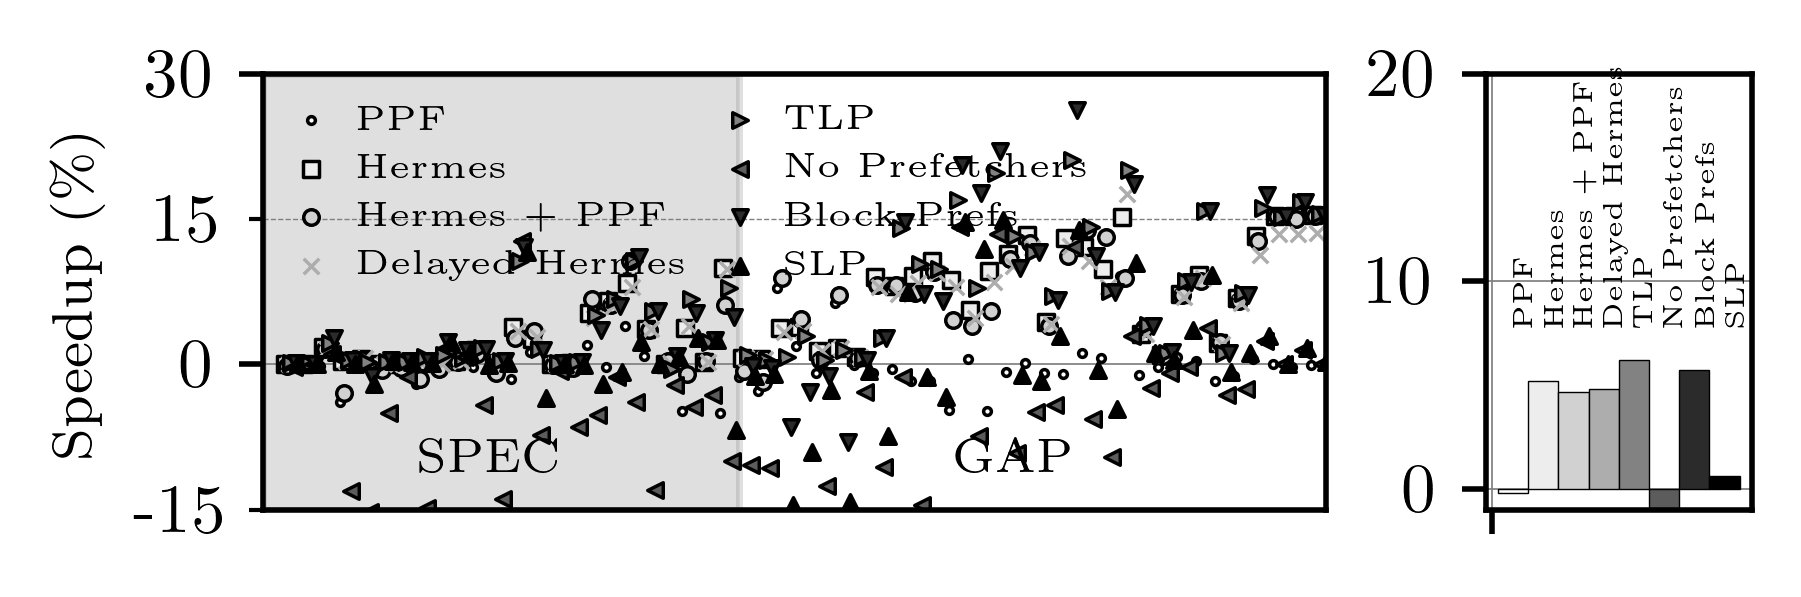

In [73]:
markers = ['.', 's', 'o', 'x', '>', '<', 'v', '^', 'h', 'D']

# Here is the actual plotting material.
fig_hermes_o_speedup = plt.figure(
    constrained_layout=True, figsize=set_size(fig_width), dpi=500)
fig_hermes_o_speedup.tight_layout(pad=0)
gs = GridSpec(1, 5, figure=fig_hermes_o_speedup)

ax_hermes_o_speedup, ax_hermes_o_gmean = fig_hermes_o_speedup.add_subplot(
    gs[0, :4]), fig_hermes_o_speedup.add_subplot(gs[0, 4:])
ax_hermes_o_speedup.margins(x=0, tight=True)

xticklabels = df_speedup_hermes_o.index.tolist()
xticklabels = [sub_re_trailing_sdc.sub(repl='', string=e) for e in xticklabels]
xticklabels = [sub_re_trailing_und.sub(
    repl=r'\_', string=e) for e in xticklabels]

key_list = df_speedup_hermes_o.columns.to_list()
# key_list = ['hermes_o_pc_based', 'popet_o', 'hermes_o_perceptron_pc_pfn']

cat_spacing = 0.05
bar_width, index = (1 - cat_spacing) / \
    len(key_list), np.arange(1, len(xticklabels) + 1)

colors = cm.get_cmap(plot_cmp)(np.linspace(
    0.0, 1.0, len(key_list), endpoint=True))

# for i, (e, c) in enumerate(zip(key_list, colors)):
#     ax_hermes_o_speedup.bar(index + i * (bar_width) + (cat_spacing / 2),
#                     df_speedup_hermes_o[e], width=bar_width, edgecolor='black', linewidth=0.2, align='edge', label=labels_dict[e], color=c)
for i, (e, c, m) in enumerate(zip(key_list, colors, markers)):
    ax_hermes_o_speedup.scatter(index + i * (bar_width) + (cat_spacing / 2),
                                df_speedup_hermes_o[e],
                                s=5,
                                marker=m,
                                # width=bar_width,
                                edgecolor='black',
                                linewidths=0.5,
                                # align='edge',
                                label=labels_dict[e], color=c)

# Annotating the benchmark suites on the plots.
ax_hermes_o_speedup.annotate(
    'SPEC', (len(spec_keys) / 2, -10), ha='center', va='center', size=7)
ax_hermes_o_speedup.annotate('GAP', (len(
    spec_keys) + len(gapbs_keys) / 2, -10), ha='center', va='center', size=7)

ax_hermes_o_speedup.axvspan(xmin=0, xmax=len(
    spec_keys) + 1, color='grey', alpha=0.25, zorder=-1)

ax_hermes_o_speedup.set_xticks(index)
# ax_hermes_o_speedup.set_xticklabels(xticklabels, rotation=90, fontsize=5)
ax_hermes_o_speedup.set_xticklabels([])
ax_hermes_o_speedup.grid(
    color='grey', linestyle='-', linewidth=0.25, axis='y')
ax_hermes_o_speedup.grid(True, which='minor', color='grey',
                         linestyle='--', linewidth=0.2, axis='y')
ax_hermes_o_speedup.set_axisbelow(True)

ax_hermes_o_speedup.set_ylabel(r'Speedup (\%)', fontsize=8)

ax_hermes_o_speedup.tick_params(axis='both')
ax_hermes_o_speedup.tick_params(labeltop=False)
ax_hermes_o_speedup.tick_params(axis='x',
                                which='both',
                                bottom=False,
                                top=False)

ax_hermes_o_speedup.set_ylim([-15.0, 30.0])

ax_hermes_o_speedup.yaxis.set_major_locator(MultipleLocator(30))
ax_hermes_o_speedup.yaxis.set_major_formatter('{x:.0f}')
ax_hermes_o_speedup.yaxis.set_minor_locator(MultipleLocator(15))
ax_hermes_o_speedup.yaxis.set_minor_formatter('{x:.0f}')

for tick in ax_hermes_o_speedup.xaxis.get_major_ticks():
    tick.label1.set_horizontalalignment('left')

ax_hermes_o_speedup.legend(loc='upper left', edgecolor='white', fancybox=False, framealpha=0.0, ncol=2,
                           fontsize=5
                           )

# Working on the second subplot that will contain the mean for each benchmark suite.
xticklabels = gmean_keys
bar_width, index = (1 - cat_spacing) / \
    len(key_list), np.arange(1, len(xticklabels) + 1)

for i, (e, c) in enumerate(zip(key_list, colors)):
    bars = ax_hermes_o_gmean.bar(index + i * bar_width + cat_spacing / 2,
                                 df_speedup_gmean[e], width=bar_width, linewidth=0.2, edgecolor='black', align='edge', label=labels_dict[e], color=c)

for b, k in zip(ax_hermes_o_gmean.patches, key_list):
    print(k)
    ax_hermes_o_gmean.annotate(labels_dict[k], (b.get_x() + b.get_width() / 2, 8), size=4, rotation=90,
                            #    ha='center',
                               # va='center',
                               # xytext=(0, 10), textcoords='offset points'
                               )

ax_hermes_o_gmean.set_xticks(index)
ax_hermes_o_gmean.set_xticklabels([])
# ax_hermes_o_gmean.bar_label(ax_hermes_o_gmean.containers[-1], labels=gmean_keys, label_type='edge', rotation=90, fontsize=5, padding=3)
ax_hermes_o_gmean.set_ylim([-1.0, 20.0])
ax_hermes_o_gmean.grid(
    color='grey', linestyle='-', linewidth=0.25)
ax_hermes_o_gmean.set_axisbelow(True)

plt.savefig('12_HPCA30_Paper/plots/evaluation/single_core_ipcp_evaluation_speedup_alt.pdf',
            format='pdf', dpi='figure')
plt.savefig('12_HPCA30_Paper/plots/evaluation/single_core_ipcp_evaluation_speedup_alt.png',
            format='png', dpi='figure')


In [74]:
res_sets, res_keys = [final_res_set_spec,
                      final_res_set_gapbs], [spec_keys, gapbs_keys]
dram_trans_pref_list, dram_trans_list, dram_trans_all_keys = [], [], []

# for set, keys in zip(res_sets, res_keys):
#     # dram_trans_pref_list.extend([set[0].sets[0][k]['dram']['transactions'] /
#     #                        set[-1].sets[0][k]['dram']['transactions'] for k in keys])
#     dram_trans_list.extend([set[0].sets[0][k]['dram']['transactions'] /
#                            set[-1].sets[0][k]['dram']['transactions'] for k in keys])

#     # Adding keys to the list.
#     dram_trans_all_keys.extend(keys)

# dict_dram_trans = {
#     # 'baseline_cascade_lake_ipcp': dram_trans_pref_list,
#     'baseline_cascade_lake_ipcp_hermes_o': dram_trans_list,
# }

dict_dram_trans = {
    # 'baseline_cascade_lake_double_l1d': [],
    'baseline_cascade_lake_spp_ppf': [],
    'baseline_cascade_lake_hermes_o': [],
    'baseline_cascade_lake_ipcp_spp_ppf_hermes_o': [],
    # 'baseline_cascade_lake_ipcp_delayed_hermes_o': [],
    # 'baseline_cascade_lake_l1d_filtered_prefetcher': [],
    # 'baseline_cascade_lake_ipcp_delayed_tlp': [],

    # 'baseline_cascade_lake_ipcp_tlp_core_l1d_-15_-35_bis': [],
    # 'baseline_cascade_lake_ipcp_tlp_layered_core_l1d': [],
    'baseline_cascade_lake_ipcp_tlp_layered_core_l1d_f20_-25': [],
    # 'baseline_cascade_lake_ipcp_hermes_o_double': [],
    # 'baseline_cascade_lake_no_prefetchers': [],
}

for set, keys in zip(res_sets, res_keys):
    # speedup_pref_list.extend([set[0].sets[0][k]['speedup'] for k in keys])
    # dict_dram_trans['baseline_cascade_lake_double_l1d'].extend([set[0].sets[0][k]['dram']['transactions'] / set[-1].sets[0][k]['dram']['transactions'] for k in keys])
    dict_dram_trans['baseline_cascade_lake_spp_ppf'].extend(
        [set[1].sets[0][k]['dram']['transactions'] / set[-1].sets[0][k]['dram']['transactions'] for k in keys])
    dict_dram_trans['baseline_cascade_lake_hermes_o'].extend(
        [set[2].sets[0][k]['dram']['transactions'] / set[-1].sets[0][k]['dram']['transactions'] for k in keys])
    dict_dram_trans['baseline_cascade_lake_ipcp_spp_ppf_hermes_o'].extend(
        [set[9].sets[0][k]['dram']['transactions'] / set[-1].sets[0][k]['dram']['transactions'] for k in keys])
    # dict_dram_trans['baseline_cascade_lake_ipcp_delayed_hermes_o'].extend([set[6].sets[0][k]['dram']['transactions'] / set[-1].sets[0][k]['dram']['transactions'] for k in keys])
    # dict_dram_trans['baseline_cascade_lake_l1d_filtered_prefetcher'].extend([set[3].sets[0][k]['dram']['transactions'] / set[-1].sets[0][k]['dram']['transactions'] for k in keys])
    # dict_dram_trans['baseline_cascade_lake_ipcp_delayed_tlp'].extend([set[7].sets[0][k]['dram']['transactions'] / set[-1].sets[0][k]['dram']['transactions'] for k in keys])

    # dict_dram_trans['baseline_cascade_lake_ipcp_tlp_core_l1d_-15_-35_bis'].extend([set[4].sets[0][k]['dram']['transactions'] / set[-1].sets[0][k]['dram']['transactions'] for k in keys])
    # dict_dram_trans['baseline_cascade_lake_ipcp_tlp_layered_core_l1d'].extend([set[8].sets[0][k]['dram']['transactions'] / set[-1].sets[0][k]['dram']['transactions'] for k in keys])
    dict_dram_trans['baseline_cascade_lake_ipcp_tlp_layered_core_l1d_f20_-25'].extend(
        [set[5].sets[0][k]['dram']['transactions'] / set[-1].sets[0][k]['dram']['transactions'] for k in keys])
    # dict_dram_trans['baseline_cascade_lake_ipcp_hermes_o_double'].extend(
    #     [set[11].sets[0][k]['dram']['transactions'] / set[-1].sets[0][k]['dram']['transactions'] for k in keys])
    # dict_dram_trans['baseline_cascade_lake_no_prefetchers'].extend(
    #     [set[12].sets[0][k]['dram']['transactions'] / set[-1].sets[0][k]['dram']['transactions'] for k in keys])

    # Adding keys to the list.
    dram_trans_all_keys.extend(keys)

# for k, v in dict_dram_trans.items():
#     dict_dram_trans[k] = sorted(v)

df_dram_trans = pandas.DataFrame(
    dict_dram_trans, columns=dict_dram_trans.keys(), index=dram_trans_all_keys)

df_dram_trans -= 1.0
df_dram_trans *= 100.0

# df_tmp = df_dram_trans[df_dram_trans.index != 'mean'].sort_values(
#     by=df_dram_trans.columns.to_list()[0], axis='rows', inplace=False)
# df_dram_trans = df_tmp

# # Sorting by geomean speed-up.
# df_dram_trans.sort_values(
#     by='mean', axis='columns', inplace=True, ascending=True)
# df_tmp = df_dram_trans[df_dram_trans.index != 'mean'].sort_values(
#     by=df_dram_trans.columns.to_list()[0], axis='rows', inplace=False)
# df_dram_trans = pandas.concat(
#     [df_tmp, df_dram_trans[df_dram_trans.index == 'mean']])

# Creating a DataFrame containing the means for the different benchmark suites.
dram_trans_pref_mean_list, dram_trans_mean_list, mean_keys = [s[0].sets[0]['mean']['dram']['transactions'] / s[-1].sets[0]['mean']['dram']['transactions'] for s in [*res_sets, final_res_set_all]], \
    [s[0].sets[0]['mean']['dram']['transactions'] / s[-1].sets[0]['mean']['dram']['transactions']
     for s in [*res_sets, final_res_set_all]], ['ALL']

df_dram_trans_mean = pandas.DataFrame({
    # 'baseline_cascade_lake_ipcp': dram_trans_pref_mean_list,
    # 'baseline_cascade_lake_double_l1d': [s[0].sets[0]['mean']['dram']['transactions'] / s[-1].sets[0]['mean']['dram']['transactions'] for s in [*res_sets, final_res_set_all]],
    'baseline_cascade_lake_spp_ppf': np.nanmean(df_dram_trans['baseline_cascade_lake_spp_ppf']),
    'baseline_cascade_lake_hermes_o': np.nanmean(df_dram_trans['baseline_cascade_lake_hermes_o']),
    'baseline_cascade_lake_ipcp_spp_ppf_hermes_o': np.nanmean(df_dram_trans['baseline_cascade_lake_ipcp_spp_ppf_hermes_o']),
    # 'baseline_cascade_lake_ipcp_delayed_hermes_o': np.nanmean(df_dram_trans['baseline_cascade_lake_ipcp_delayed_hermes_o']),
    # 'baseline_cascade_lake_l1d_filtered_prefetcher': [s[3].sets[0]['mean']['dram']['transactions'] / s[-1].sets[0]['mean']['dram']['transactions'] for s in [*res_sets, final_res_set_all]],
    # 'baseline_cascade_lake_ipcp_delayed_tlp': [s[7].sets[0]['mean']['dram']['transactions'] / s[-1].sets[0]['mean']['dram']['transactions'] for s in [*res_sets, final_res_set_all]],

    # 'baseline_cascade_lake_ipcp_tlp_core_l1d_-15_-35_bis': [s[4].sets[0]['mean']['dram']['transactions'] / s[-1].sets[0]['mean']['dram']['transactions'] for s in [*res_sets, final_res_set_all]],
    # 'baseline_cascade_lake_ipcp_tlp_layered_core_l1d': [s[8].sets[0]['mean']['dram']['transactions'] / s[-1].sets[0]['mean']['dram']['transactions'] for s in [*res_sets, final_res_set_all]],
    'baseline_cascade_lake_ipcp_tlp_layered_core_l1d_f20_-25': np.nanmean(df_dram_trans['baseline_cascade_lake_ipcp_tlp_layered_core_l1d_f20_-25']),
    # 'baseline_cascade_lake_ipcp_hermes_o_double': np.nanmean(df_dram_trans['baseline_cascade_lake_ipcp_hermes_o_double']),
    # 'baseline_cascade_lake_no_prefetchers': np.nanmean(df_dram_trans['baseline_cascade_lake_no_prefetchers']),
}, index=mean_keys)

# df_dram_trans_mean -= 1.0
# df_dram_trans_mean *= 100.0
# del(df_tmp)

# Concatenating the 50 highest values with the means per benchmark suites.
# df_dram_trans = pandas.concat([df_tmp, df_dram_trans_mean])

display(df_dram_trans)
display(df_dram_trans_mean)


,baseline_cascade_lake_spp_ppf,baseline_cascade_lake_hermes_o,baseline_cascade_lake_ipcp_spp_ppf_hermes_o,baseline_cascade_lake_ipcp_tlp_layered_core_l1d_f20_-25
621.wrf_s,-1.120816,-3.786787,0.601786,-32.774353
456.hmmer,1.775795,0.116067,0.511775,-49.986410
657.xz_s,11.128274,6.367265,24.699891,-19.417528
459.GemsFDTD,-3.173583,1.470437,-1.862434,-5.109653
623.xalancbmk_s,0.222774,0.937615,7.722504,-27.077217
436.cactusADM,-18.973841,1.295639,-17.077891,-17.102353
628.pop2_s,7.491375,0.945539,7.512491,-29.487288
437.leslie3d,-6.165814,1.343716,-4.991546,-30.345951
401.bzip2,14.375928,-0.423350,15.132737,-24.821686
445.gobmk,9.450896,1.232673,9.973518,-12.753677


,baseline_cascade_lake_spp_ppf,baseline_cascade_lake_hermes_o,baseline_cascade_lake_ipcp_spp_ppf_hermes_o,baseline_cascade_lake_ipcp_tlp_layered_core_l1d_f20_-25
ALL,7.68478,5.199313,13.254184,-30.707784


/tmp/ipykernel_13252/3783959683.py:32: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax_hermes_o_dram_trans.scatter(index + i * (bar_width) + (cat_spacing / 2),


baseline_cascade_lake_spp_ppf
baseline_cascade_lake_hermes_o
baseline_cascade_lake_ipcp_spp_ppf_hermes_o
baseline_cascade_lake_ipcp_tlp_layered_core_l1d_f20_-25


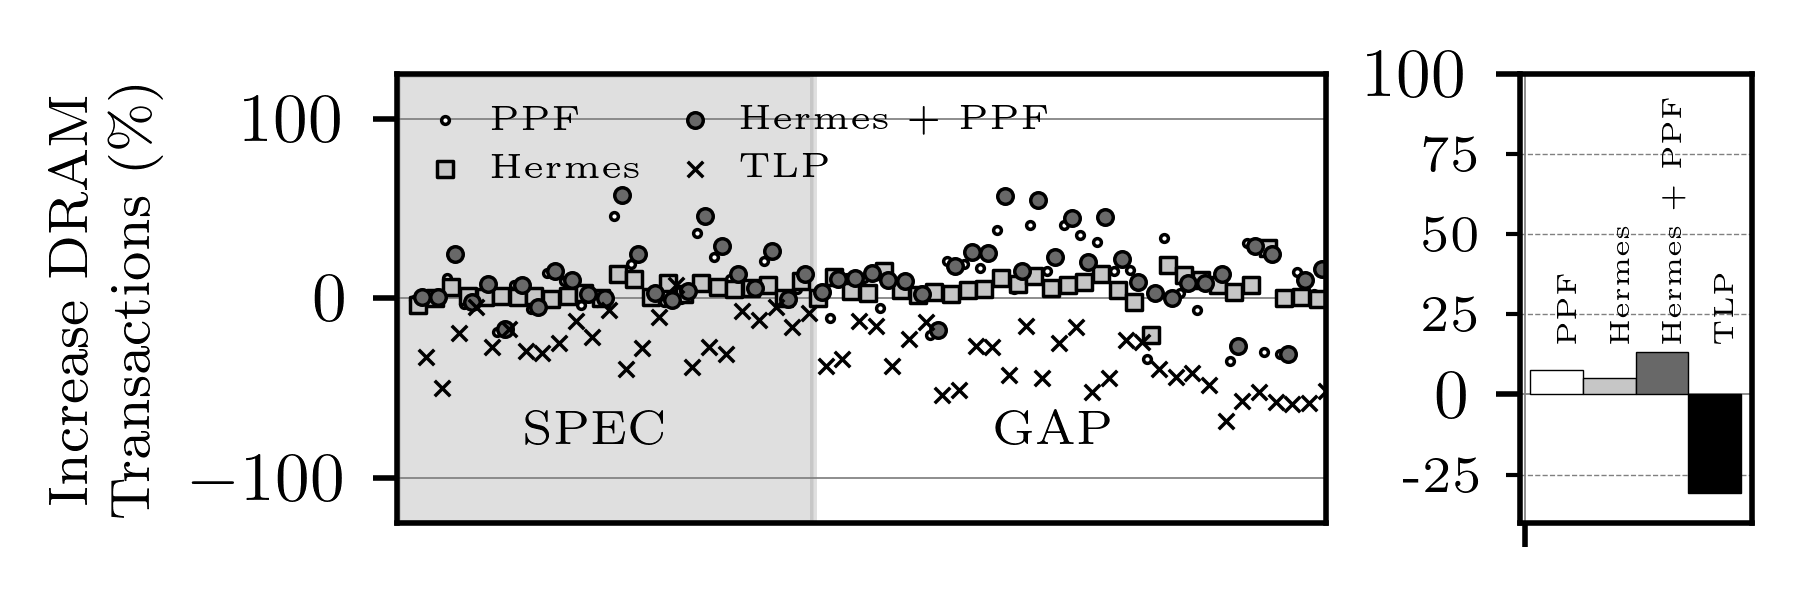

In [75]:
markers = ['.', 's', 'o', 'x', '>', '<', 'v', '^', 'h', 'D']

# Here is the actual plotting material.
fig_hermes_o_dram_trans = plt.figure(
    constrained_layout=True, figsize=set_size(fig_width), dpi=500)
fig_hermes_o_dram_trans.tight_layout(pad=0)
gs = GridSpec(1, 5, figure=fig_hermes_o_dram_trans)

ax_hermes_o_dram_trans, ax_hermes_o_dram_trans_mean = fig_hermes_o_dram_trans.add_subplot(
    gs[0, :4]), fig_hermes_o_dram_trans.add_subplot(gs[0, 4:])
ax_hermes_o_dram_trans.margins(x=0, tight=True)

xticklabels = df_dram_trans.index.tolist()
xticklabels = [sub_re_trailing_sdc.sub(repl='', string=e) for e in xticklabels]
xticklabels = [sub_re_trailing_und.sub(
    repl=r'\_', string=e) for e in xticklabels]

key_list = df_dram_trans.columns.to_list()
# key_list = ['hermes_o_pc_based', 'popet_o', 'hermes_o_perceptron_pc_pfn']

cat_spacing = 0.05
bar_width, index = (1 - cat_spacing) / \
    len(key_list), np.arange(1, len(xticklabels) + 1)

colors = cm.get_cmap(plot_cmp)(np.linspace(
    0.0, 1.0, len(key_list), endpoint=True))

# for i, (e, c) in enumerate(zip(key_list, colors)):
#     ax_hermes_o_dram_trans.bar(index + i * (bar_width) + (cat_spacing / 2),
#                     df_speedup_hermes_o[e], width=bar_width, edgecolor='black', linewidth=0.2, align='edge', label=labels_dict[e], color=c)
for i, (e, c, m) in enumerate(zip(key_list, colors, markers)):
    ax_hermes_o_dram_trans.scatter(index + i * (bar_width) + (cat_spacing / 2),
                                   df_dram_trans[e],
                                   s=5,
                                   marker=m,
                                   edgecolor='black',
                                   linewidths=0.5,
                                   # width=bar_width, edgecolor='black', linewidth=0.2, align='edge',
                                   label=labels_dict[e], color=c)

# Annotating the benchmark suites on the plots.
ax_hermes_o_dram_trans.annotate(
    'SPEC', (len(spec_keys) / 2, -75), ha='center', va='center', size=7)
ax_hermes_o_dram_trans.annotate('GAP', (len(
    spec_keys) + len(gapbs_keys) / 2, -75), ha='center', va='center', size=7)

ax_hermes_o_dram_trans.axvspan(xmin=0, xmax=len(
    spec_keys) + 1, color='grey', alpha=0.25, zorder=-1)

ax_hermes_o_dram_trans.set_xticks(index)
# ax_hermes_o_dram_trans.set_xticklabels(xticklabels, rotation=90, fontsize=5)
ax_hermes_o_dram_trans.set_xticklabels([])
ax_hermes_o_dram_trans.grid(
    color='grey', linestyle='-', linewidth=0.25, axis='y')
ax_hermes_o_dram_trans.set_axisbelow(True)

ax_hermes_o_dram_trans.set_ylabel(
    'Increase DRAM\nTransactions (\%)', fontsize=8)

ax_hermes_o_dram_trans.tick_params(axis='both')
ax_hermes_o_dram_trans.tick_params(labeltop=False)
ax_hermes_o_dram_trans.tick_params(axis='x',
                                   which='both',
                                   bottom=False,
                                   top=False)

ax_hermes_o_dram_trans.set_ylim([-125.0, 125.0])

for tick in ax_hermes_o_dram_trans.xaxis.get_major_ticks():
    tick.label1.set_horizontalalignment('left')

ax_hermes_o_dram_trans.legend(loc='upper left', edgecolor='white', fancybox=False, framealpha=0.0, ncol=2,
                              fontsize=5
                              )

# Working on the second subplot that will contain the mean for each benchmark suite.
xticklabels = mean_keys
bar_width, index = (1 - cat_spacing) / \
    len(key_list), np.arange(1, len(xticklabels) + 1)

for i, (e, c) in enumerate(zip(key_list, colors)):
    ax_hermes_o_dram_trans_mean.bar(index + i * bar_width + cat_spacing / 2,
                                    df_dram_trans_mean[e], width=bar_width, linewidth=0.2, edgecolor='black', align='edge', label=labels_dict[e], color=c)

for b, k in zip(ax_hermes_o_dram_trans_mean.patches, key_list):
    print(k)
    ax_hermes_o_dram_trans_mean.annotate(labels_dict[k], (b.get_x() + b.get_width() / 2, 17.5), size=4, rotation=90,
                                         #    ha='center',
                                         # va='center',
                                         # xytext=(0, 10), textcoords='offset points'
                                         )

ax_hermes_o_dram_trans_mean.yaxis.set_major_locator(MultipleLocator(100))
ax_hermes_o_dram_trans_mean.yaxis.set_major_formatter('{x:.0f}')
ax_hermes_o_dram_trans_mean.yaxis.set_minor_locator(MultipleLocator(25))
ax_hermes_o_dram_trans_mean.yaxis.set_minor_formatter('{x:.0f}')

ax_hermes_o_dram_trans_mean.set_xticks(index)
ax_hermes_o_dram_trans_mean.set_xticklabels([])
# ax_hermes_o_dram_trans_mean.bar_label(ax_hermes_o_dram_trans_mean.containers[1], labels=gmean_keys, label_type='edge', rotation=90, fontsize=5, padding=3)
ax_hermes_o_dram_trans_mean.set_ylim([-40.0, 100.0])
ax_hermes_o_dram_trans_mean.grid(
    color='grey', linestyle='-', linewidth=0.25)
ax_hermes_o_dram_trans_mean.grid(True, which='minor', color='grey',
                         linestyle='--', linewidth=0.2, axis='y')
ax_hermes_o_dram_trans_mean.set_axisbelow(True)
ax_hermes_o_dram_trans_mean.tick_params(axis='y', which='minor', labelsize=7.5)

plt.savefig('12_HPCA30_Paper/plots/evaluation/single_core_ipcp_evaluation_dram_transactions_alt.pdf',
            format='pdf', dpi='figure')
plt.savefig('12_HPCA30_Paper/plots/evaluation/single_core_ipcp_evaluation_dram_transactions_alt.png',
            format='png', dpi='figure')


In [76]:
dict_l1d_accuracy = {
    # 'baseline_cascade_lake': [s[-1].sets[0]['mean']['l1d_prefetcher']['accuracy'] for s in workload_sets],
    'baseline_cascade_lake_spp_ppf': [s[1].sets[0]['mean']['l1d_prefetcher']['accuracy'] for s in workload_sets],
    'baseline_cascade_lake_hermes_o': [s[2].sets[0]['mean']['l1d_prefetcher']['accuracy'] for s in workload_sets],
    'baseline_cascade_lake_ipcp_spp_ppf_hermes_o': [s[9].sets[0]['mean']['l1d_prefetcher']['accuracy'] for s in workload_sets],
    # 'baseline_cascade_lake_l1d_filtered_prefetcher': [s[3].sets[0]['mean']['l1d_prefetcher']['accuracy'] for s in workload_sets],
    # 'baseline_cascade_lake_ipcp_tlp_layered_core_l1d': [s[8].sets[0]['mean']['l1d_prefetcher']['accuracy'] for s in workload_sets],
    'baseline_cascade_lake_ipcp_tlp_layered_core_l1d_f20_-25': [s[5].sets[0]['mean']['l1d_prefetcher']['accuracy'] for s in workload_sets],
    # 'baseline_cascade_lake_hermes_o_no_l1d_prefetcher': [(s[6].sets[0]['geomean']['speedup'] - 1.0) * 100.0 for s in speedup_all_keys],
}

df_l1d_accuracy = pandas.DataFrame(
    dict_l1d_accuracy, columns=dict_l1d_accuracy.keys(), index=['SPEC', 'GAP', 'ALL'])

df_l1d_accuracy *= 100.0

# # Sorting by geomean speed-up.
# df_l1d_accuracy.sort_values(
#     by='geomean', axis='columns', inplace=True)
# df_tmp = df_l1d_accuracy[df_l1d_accuracy.index != 'geomean'].sort_values(
#     by=df_l1d_accuracy.columns.to_list()[-1], axis='rows', inplace=False)
# df_l1d_accuracy = pandas.concat(
#     [df_tmp, df_l1d_accuracy[df_l1d_accuracy.index == 'geomean']])

display(df_l1d_accuracy)


,baseline_cascade_lake_spp_ppf,baseline_cascade_lake_hermes_o,baseline_cascade_lake_ipcp_spp_ppf_hermes_o,baseline_cascade_lake_ipcp_tlp_layered_core_l1d_f20_-25
SPEC,24.077765,24.079172,23.621056,42.932612
GAP,17.928145,17.846937,17.804402,34.137936
ALL,20.611616,20.566458,20.342578,37.975613


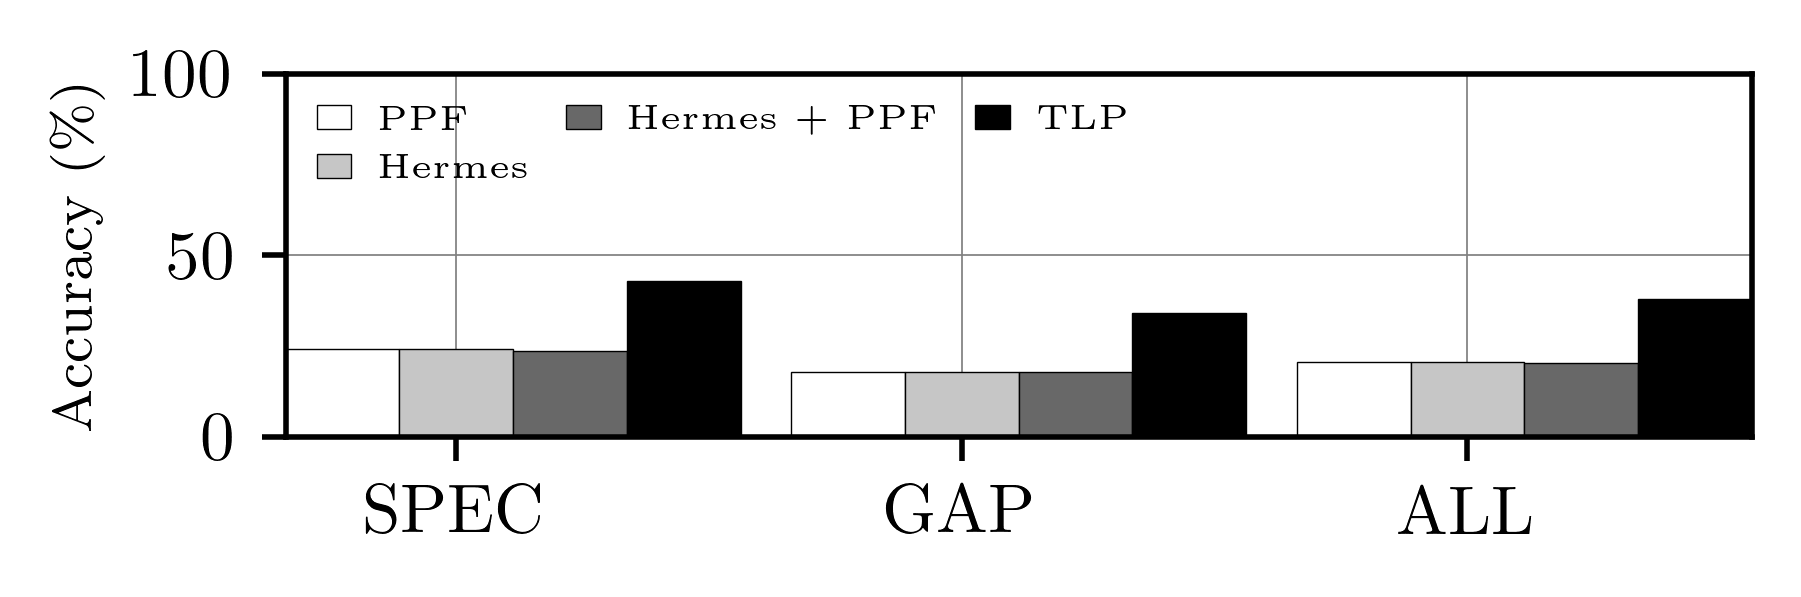

In [77]:
# Here is the actual plotting material.
fig_l1d_pref_accuracy = plt.figure(
    constrained_layout=True, figsize=set_size(fig_width), dpi=500)
fig_l1d_pref_accuracy.tight_layout(pad=0)
gs = GridSpec(1, 1, figure=fig_l1d_pref_accuracy)

fig_l1d_pref_accuracy = fig_l1d_pref_accuracy.add_subplot(
    gs[:])
fig_l1d_pref_accuracy.margins(x=0, tight=True)

xticklabels = df_l1d_accuracy.index.tolist()
xticklabels = [sub_re_trailing_sdc.sub(repl='', string=e) for e in xticklabels]
xticklabels = [sub_re_trailing_und.sub(
    repl=r'\_', string=e) for e in xticklabels]

key_list = df_l1d_accuracy.columns.to_list()
# key_list = ['hermes_o_pc_based_2k_entries', 'hermes_o_pc_based', 'popet_o', 'hermes_o_perfect']

cat_spacing = 0.1
bar_width, index = (1 - cat_spacing) / \
    len(key_list), np.arange(1, len(xticklabels) + 1)

colors = cm.get_cmap(plot_cmp)(np.linspace(
    0.0, 1.0, len(key_list), endpoint=True))

for i, (e, c) in enumerate(zip(key_list, colors)):
    fig_l1d_pref_accuracy.bar(index + (i - 1) * (bar_width),
                              df_l1d_accuracy[e], width=bar_width, edgecolor='black', linewidth=0.2, align='center', label=labels_dict[e], color=c)

fig_l1d_pref_accuracy.set_xticks(index)
fig_l1d_pref_accuracy.set_xticklabels(xticklabels, rotation=0)
# fig_l1d_pref_accuracy.set_xticklabels([])
fig_l1d_pref_accuracy.grid(
    color='grey', linestyle='-', linewidth=0.25)
fig_l1d_pref_accuracy.set_axisbelow(True)

fig_l1d_pref_accuracy.set_ylabel(r'Accuracy (\%)')

fig_l1d_pref_accuracy.tick_params(axis='both')
fig_l1d_pref_accuracy.tick_params(labeltop=False)

fig_l1d_pref_accuracy.set_ylim([0, 100.0])

fig_l1d_pref_accuracy.legend(loc='upper left', edgecolor='white', fancybox=False, framealpha=0.0,
                             ncol=3,
                             fontsize=5,
                             #    labelspacing=1.0,
                             #    bbox_to_anchor=(0, 0.925, 1, 0.25),
                             #    mode='expand'
                             )

for tick in fig_l1d_pref_accuracy.xaxis.get_major_ticks():
    tick.label1.set_horizontalalignment('center')

plt.savefig('12_HPCA30_Paper/plots/evaluation/single_core_ipcp_evaluation_l1d_prefetcher_accuracy.pdf',
            format='pdf', dpi='figure')
plt.savefig('12_HPCA30_Paper/plots/evaluation/single_core_ipcp_evaluation_l1d_prefetcher_accuracy.png',
            format='png', dpi='figure')


In [78]:
dict_l1d_coverage = {
    # 'baseline_cascade_lake': [s[-1].sets[0]['mean']['l1d_misses']['accuracy'] for s in workload_sets],
    # 'baseline_cascade_lake_ipcp': [s[-1].sets[0]['mean']['llc_mpki'] / s[-1].sets[0]['mean']['llc_mpki'] for s in workload_sets],
    'baseline_cascade_lake_spp_ppf': [s[1].sets[0]['mean']['llc_mpki'] / s[-1].sets[0]['mean']['llc_mpki'] for s in workload_sets],
    'baseline_cascade_lake_hermes_o': [s[2].sets[0]['mean']['llc_mpki'] / s[-1].sets[0]['mean']['llc_mpki'] for s in workload_sets],
    'baseline_cascade_lake_ipcp_spp_ppf_hermes_o': [s[9].sets[0]['mean']['llc_mpki'] / s[-1].sets[0]['mean']['llc_mpki'] for s in workload_sets],
    # 'baseline_cascade_lake_l1d_filtered_prefetcher': [s[3].sets[0]['mean']['l1d_misses']['accuracy'] for s in workload_sets],
    # 'baseline_cascade_lake_ipcp_tlp_layered_core_l1d': [s[8].sets[0]['mean']['l1d_misses']['accuracy'] for s in workload_sets],
    'baseline_cascade_lake_ipcp_tlp_layered_core_l1d_f20_-25': [s[5].sets[0]['mean']['llc_mpki'] / s[-1].sets[0]['mean']['llc_mpki'] for s in workload_sets],
    # 'baseline_cascade_lake_hermes_o_no_llc_mpki': [(s[6].sets[0]['geomean']['speedup'] - 1.0) * 100.0 for s in speedup_all_keys],
}

df_l1d_coverage = pandas.DataFrame(
    dict_l1d_coverage, columns=dict_l1d_coverage.keys(), index=['SPEC', 'GAP', 'ALL'])

df_l1d_coverage = 1.0 - df_l1d_coverage
df_l1d_coverage *= 100.0

# # Sorting by geomean speed-up.
# df_l1d_coverage.sort_values(
#     by='geomean', axis='columns', inplace=True)
# df_tmp = df_l1d_coverage[df_l1d_coverage.index != 'geomean'].sort_values(
#     by=df_l1d_coverage.columns.to_list()[-1], axis='rows', inplace=False)
# df_l1d_coverage = pandas.concat(
#     [df_tmp, df_l1d_coverage[df_l1d_coverage.index == 'geomean']])

display(df_l1d_coverage)

,baseline_cascade_lake_spp_ppf,baseline_cascade_lake_hermes_o,baseline_cascade_lake_ipcp_spp_ppf_hermes_o,baseline_cascade_lake_ipcp_tlp_layered_core_l1d_f20_-25
SPEC,3.626674,-1.071660,3.818790,-5.784954
GAP,-0.077779,-0.269060,-0.181127,0.334003
ALL,0.401788,-0.372962,0.336690,-0.458138


In [79]:
dict_llc_mpki = {
    # 'baseline_cascade_lake': [s[-1].sets[0]['mean']['l1d_misses']['accuracy'] for s in workload_sets],
    'baseline_cascade_lake_ipcp': [s[-1].sets[0]['mean']['llc_mpki'] for s in workload_sets],
    'baseline_cascade_lake_spp_ppf': [s[1].sets[0]['mean']['llc_mpki'] for s in workload_sets],
    'baseline_cascade_lake_hermes_o': [s[2].sets[0]['mean']['llc_mpki'] for s in workload_sets],
    'baseline_cascade_lake_ipcp_spp_ppf_hermes_o': [s[9].sets[0]['mean']['llc_mpki'] for s in workload_sets],
    # 'baseline_cascade_lake_l1d_filtered_prefetcher': [s[3].sets[0]['mean']['l1d_misses']['accuracy'] for s in workload_sets],
    # 'baseline_cascade_lake_ipcp_tlp_layered_core_l1d': [s[8].sets[0]['mean']['l1d_misses']['accuracy'] for s in workload_sets],
    'baseline_cascade_lake_ipcp_tlp_layered_core_l1d_f20_-25': [s[5].sets[0]['mean']['llc_mpki'] for s in workload_sets],
    # 'baseline_cascade_lake_hermes_o_no_llc_mpki': [(s[6].sets[0]['geomean']['speedup'] - 1.0) * 100.0 for s in speedup_all_keys],
}

df_llc_mpki = pandas.DataFrame(
    dict_llc_mpki, columns=dict_llc_mpki.keys(), index=['SPEC', 'GAP', 'ALL'])

display(df_llc_mpki)

,baseline_cascade_lake_ipcp,baseline_cascade_lake_spp_ppf,baseline_cascade_lake_hermes_o,baseline_cascade_lake_ipcp_spp_ppf_hermes_o,baseline_cascade_lake_ipcp_tlp_layered_core_l1d_f20_-25
SPEC,9.252747,8.917180,9.351905,8.899404,9.788014
GAP,48.170947,48.208414,48.300556,48.258198,48.010055
ALL,31.188460,31.063148,31.304781,31.083451,31.331346


In [80]:
dict_llc_mpki = {
    # 'baseline_cascade_lake': [s[-1].sets[0]['mean']['l1d_misses']['accuracy'] for s in workload_sets],
    'baseline_cascade_lake_ipcp': [s[17].sets[0]['mean']['llc_mpki'] for s in workload_sets],
    'baseline_cascade_lake_spp_ppf': [s[13].sets[0]['mean']['llc_mpki'] for s in workload_sets],
    'baseline_cascade_lake_hermes_o': [s[14].sets[0]['mean']['llc_mpki'] for s in workload_sets],
    'baseline_cascade_lake_ipcp_spp_ppf_hermes_o': [s[15].sets[0]['mean']['llc_mpki'] for s in workload_sets],
    # 'baseline_cascade_lake_l1d_filtered_prefetcher': [s[3].sets[0]['mean']['l1d_misses']['accuracy'] for s in workload_sets],
    # 'baseline_cascade_lake_ipcp_tlp_layered_core_l1d': [s[8].sets[0]['mean']['l1d_misses']['accuracy'] for s in workload_sets],
    'baseline_cascade_lake_ipcp_tlp_layered_core_l1d_f20_-25': [s[16].sets[0]['mean']['llc_mpki'] for s in workload_sets],
    # 'baseline_cascade_lake_hermes_o_no_llc_mpki': [(s[6].sets[0]['geomean']['speedup'] - 1.0) * 100.0 for s in speedup_all_keys],
}

df_llc_mpki = pandas.DataFrame(
    dict_llc_mpki, columns=dict_llc_mpki.keys(), index=['SPEC', 'GAP', 'ALL'])

display(df_llc_mpki)

,baseline_cascade_lake_ipcp,baseline_cascade_lake_spp_ppf,baseline_cascade_lake_hermes_o,baseline_cascade_lake_ipcp_spp_ppf_hermes_o,baseline_cascade_lake_ipcp_tlp_layered_core_l1d_f20_-25
SPEC,9.689928,9.590905,9.707068,9.546023,9.706011
GAP,47.670924,49.098737,47.679614,49.082663,47.682002
ALL,31.097398,31.858956,31.109776,31.830311,31.110660


In [81]:
res_sets, res_keys = [final_res_set_gapbs], [[k for k in gapbs_keys if k != 'mean']]
speedup_list, speedup_pref_list, speedup_all_keys = [], [], []

dict_saved_llc_misses = {
    # 'baseline_cascade_lake_double_l1d': [],
    'baseline_cascade_lake_spp_ppf': [],
    'baseline_cascade_lake_hermes_o': [],
    'baseline_cascade_lake_ipcp_spp_ppf_hermes_o': [],
    # 'baseline_cascade_lake_ipcp_delayed_hermes_o': [],
    # 'baseline_cascade_lake_l1d_filtered_prefetcher': [],
    # 'baseline_cascade_lake_ipcp_delayed_tlp': [],

    # WIP: Addition of improved designs for the MICRO'23 rebuttals.
    # 'baseline_cascade_lake_ipcp_tlp_core_l1d_-15_-35_bis': [],
    # 'baseline_cascade_lake_ipcp_tlp_layered_core_l1d': [],
    'baseline_cascade_lake_ipcp_tlp_layered_core_l1d_f20_-25': [],
    'baseline_cascade_lake_ipcp': [],
    # 'baseline_cascade_lake_ipcp_iso_prefetcher': [],
    # 'baseline_cascade_lake_ipcp_hermes_o_double': [],
    # 'baseline_cascade_lake_no_prefetchers': [],
}

for set, keys in zip(res_sets, res_keys):
    # speedup_pref_list.extend([set[0].sets[0][k]['speedup'] for k in keys])
    # dict_saved_llc_misses['baseline_cascade_lake_double_l1d'].extend([set[0].sets[0][k]['speedup'] for k in keys])
    dict_saved_llc_misses['baseline_cascade_lake_ipcp'].extend(
        [set[-1].sets[0][k]['llc_mpki'] for k in keys])
    dict_saved_llc_misses['baseline_cascade_lake_spp_ppf'].extend(
        [set[1].sets[0][k]['llc_mpki'] for k in keys])
    dict_saved_llc_misses['baseline_cascade_lake_hermes_o'].extend(
        [set[2].sets[0][k]['llc_mpki'] for k in keys])
    dict_saved_llc_misses['baseline_cascade_lake_ipcp_spp_ppf_hermes_o'].extend(
        [set[9].sets[0][k]['llc_mpki'] for k in keys])
    # dict_saved_llc_misses['baseline_cascade_lake_ipcp_delayed_hermes_o'].extend([set[6].sets[0][k]['speedup'] for k in keys])
    # dict_saved_llc_misses['baseline_cascade_lake_l1d_filtered_prefetcher'].extend([set[3].sets[0][k]['speedup'] for k in keys])
    # dict_saved_llc_misses['baseline_cascade_lake_ipcp_delayed_tlp'].extend([set[7].sets[0][k]['speedup'] for k in keys])

    # dict_saved_llc_misses['baseline_cascade_lake_ipcp_tlp_core_l1d_-15_-35_bis'].extend([set[4].sets[0][k]['speedup'] for k in keys])
    # dict_saved_llc_misses['baseline_cascade_lake_ipcp_tlp_layered_core_l1d'].extend([set[8].sets[0][k]['speedup'] for k in keys])
    dict_saved_llc_misses['baseline_cascade_lake_ipcp_tlp_layered_core_l1d_f20_-25'].extend(
        [set[5].sets[0][k]['llc_mpki'] for k in keys])
    # dict_saved_llc_misses['baseline_cascade_lake_ipcp_iso_prefetcher'].extend(
    #     [set[10].sets[0][k]['speedup'] for k in keys])
    # dict_saved_llc_misses['baseline_cascade_lake_ipcp_hermes_o_double'].extend(
    #     [set[11].sets[0][k]['speedup'] for k in keys])
    # dict_saved_llc_misses['baseline_cascade_lake_no_prefetchers'].extend(
    #     [set[12].sets[0][k]['llc_mpki'] for k in keys])

# for set, keys in zip(res_sets, res_keys):
#     # speedup_pref_list.extend([set[0].sets[0][k]['speedup'] for k in keys])
#     # dict_saved_llc_misses['baseline_cascade_lake_double_l1d'].extend([set[0].sets[0][k]['speedup'] for k in keys])
#     dict_saved_llc_misses['baseline_cascade_lake_ipcp'].extend(
#         [set[-1].sets[0][k]['llc_mpki'] / set[17].sets[0][k]['llc_mpki'] for k in keys])
#     dict_saved_llc_misses['baseline_cascade_lake_spp_ppf'].extend(
#         [set[1].sets[0][k]['llc_mpki'] / set[13].sets[0][k]['llc_mpki'] for k in keys])
#     dict_saved_llc_misses['baseline_cascade_lake_hermes_o'].extend(
#         [set[2].sets[0][k]['llc_mpki'] / set[14].sets[0][k]['llc_mpki'] for k in keys])
#     dict_saved_llc_misses['baseline_cascade_lake_ipcp_spp_ppf_hermes_o'].extend(
#         [set[9].sets[0][k]['llc_mpki'] / set[15].sets[0][k]['llc_mpki'] for k in keys])
#     # dict_saved_llc_misses['baseline_cascade_lake_ipcp_delayed_hermes_o'].extend([set[6].sets[0][k]['speedup'] for k in keys])
#     # dict_saved_llc_misses['baseline_cascade_lake_l1d_filtered_prefetcher'].extend([set[3].sets[0][k]['speedup'] for k in keys])
#     # dict_saved_llc_misses['baseline_cascade_lake_ipcp_delayed_tlp'].extend([set[7].sets[0][k]['speedup'] for k in keys])

#     # dict_saved_llc_misses['baseline_cascade_lake_ipcp_tlp_core_l1d_-15_-35_bis'].extend([set[4].sets[0][k]['speedup'] for k in keys])
#     # dict_saved_llc_misses['baseline_cascade_lake_ipcp_tlp_layered_core_l1d'].extend([set[8].sets[0][k]['speedup'] for k in keys])
#     dict_saved_llc_misses['baseline_cascade_lake_ipcp_tlp_layered_core_l1d_f20_-25'].extend(
#         [set[5].sets[0][k]['llc_mpki'] / set[16].sets[0][k]['llc_mpki'] for k in keys])
#     # dict_saved_llc_misses['baseline_cascade_lake_ipcp_iso_prefetcher'].extend(
#     #     [set[10].sets[0][k]['speedup'] for k in keys])
#     # dict_saved_llc_misses['baseline_cascade_lake_ipcp_hermes_o_double'].extend(
#     #     [set[11].sets[0][k]['speedup'] for k in keys])
#     # dict_saved_llc_misses['baseline_cascade_lake_no_prefetchers'].extend(
#     #     [set[12].sets[0][k]['llc_mpki'] for k in keys])

    # Adding keys to the list.
    speedup_all_keys.extend(keys)

# for k, v in dict_saved_llc_misses.items():
#     dict_saved_llc_misses[k] = sorted(v)

df_saved_llc_misses = pandas.DataFrame(
    dict_saved_llc_misses, columns=dict_saved_llc_misses.keys(), index=speedup_all_keys)

# df_tmp = df_saved_llc_misses[df_saved_llc_misses.index != 'mean'].sort_values(
#     by=df_saved_llc_misses.columns.to_list()[-1], axis='rows', inplace=False)
# df_saved_llc_misses = df_tmp

# df_saved_llc_misses = 1.0 - df_saved_llc_misses
# df_saved_llc_misses *= 100.0

# Creating a DataFrame containing the geo-means for the different benchmark suites.
mean_keys = ['ALL']

df_saved_llc_misses_mean = pandas.DataFrame({
    # 'baseline_cascade_lake_ipcp': speedup_pref_gmean_list,
    # 'baseline_cascade_lake_ipcp_hermes_o': speedup_gmean_list,
    # 'baseline_cascade_lake_double_l1d': [s[0].sets[0]['geomean']['speedup'] for s in [*res_sets, final_res_set_all]],
    'baseline_cascade_lake_ipcp': np.mean(df_saved_llc_misses['baseline_cascade_lake_ipcp']),
    'baseline_cascade_lake_spp_ppf': np.mean(df_saved_llc_misses['baseline_cascade_lake_spp_ppf']),
    'baseline_cascade_lake_hermes_o': np.mean(df_saved_llc_misses['baseline_cascade_lake_hermes_o']),
    'baseline_cascade_lake_ipcp_spp_ppf_hermes_o': np.mean(df_saved_llc_misses['baseline_cascade_lake_ipcp_spp_ppf_hermes_o']),
    # 'baseline_cascade_lake_ipcp_delayed_hermes_o': np.mean(df_saved_llc_misses['baseline_cascade_lake_ipcp_delayed_hermes_o'] / 100.0 + 1.0),
    # 'baseline_cascade_lake_l1d_filtered_prefetcher': [s[3].sets[0]['geomean']['speedup'] for s in [*res_sets, final_res_set_all]],
    # 'baseline_cascade_lake_ipcp_delayed_tlp': [s[7].sets[0]['geomean']['speedup'] for s in [*res_sets, final_res_set_all]],

    # 'baseline_cascade_lake_ipcp_tlp_core_l1d_-15_-35_bis': [s[4].sets[0]['geomean']['speedup'] for s in [*res_sets, final_res_set_all]],
    # 'baseline_cascade_lake_ipcp_tlp_layered_core_l1d': [s[8].sets[0]['geomean']['speedup'] for s in [*res_sets, final_res_set_all]],
    'baseline_cascade_lake_ipcp_tlp_layered_core_l1d_f20_-25': np.mean(df_saved_llc_misses['baseline_cascade_lake_ipcp_tlp_layered_core_l1d_f20_-25']),
    # 'baseline_cascade_lake_ipcp_iso_prefetcher': np.mean(df_saved_llc_misses['baseline_cascade_lake_ipcp_iso_prefetcher'] / 100.0 + 1.0),
    # 'baseline_cascade_lake_ipcp_hermes_o_double': np.mean(df_saved_llc_misses['baseline_cascade_lake_ipcp_hermes_o_double'] / 100.0 + 1.0),
    # 'baseline_cascade_lake_no_prefetchers': np.mean(df_saved_llc_misses['baseline_cascade_lake_no_prefetchers'] / 100.0 + 1.0),
}, index=mean_keys)

# df_saved_llc_misses_mean -= 1.0
# df_saved_llc_misses_mean *= 100.0

labels_dict.update({
    # 'baseline_cascade_lake_ipcp': 'IPCP',
    'baseline_cascade_lake_ipcp_hermes_o': 'Hermes-O',
})

display(df_saved_llc_misses)
display(df_saved_llc_misses_mean)


,baseline_cascade_lake_spp_ppf,baseline_cascade_lake_hermes_o,baseline_cascade_lake_ipcp_spp_ppf_hermes_o,baseline_cascade_lake_ipcp_tlp_layered_core_l1d_f20_-25,baseline_cascade_lake_ipcp
cc.web.sdc,1.844762,1.443372,1.840671,1.817873,1.429171
tc.twitter.sdc,3.824259,2.961538,3.837183,2.917041,2.952280
pr.road.sdc,4.212373,4.134223,4.263012,4.845723,4.142225
cc.road.sdc,4.912845,5.008412,4.962944,5.740344,4.809935
tc.friendster.sdc,5.705213,5.488554,5.715797,5.678132,5.480044
tc.road.sdc,6.649967,7.042170,6.655907,8.224477,7.047090
bc.web.sdc,9.533396,9.332163,9.539618,9.575192,9.323995
tc.urand.sdc,11.125315,10.822349,11.100028,13.326259,10.833137
sssp.web.sdc,10.358260,13.198120,10.546710,11.812440,12.890640
cc.twitter.sdc,14.304948,12.959453,14.190249,13.351423,13.027326


,baseline_cascade_lake_ipcp,baseline_cascade_lake_spp_ppf,baseline_cascade_lake_hermes_o,baseline_cascade_lake_ipcp_spp_ppf_hermes_o,baseline_cascade_lake_ipcp_tlp_layered_core_l1d_f20_-25
ALL,48.170947,48.208414,48.300556,48.258198,48.010055


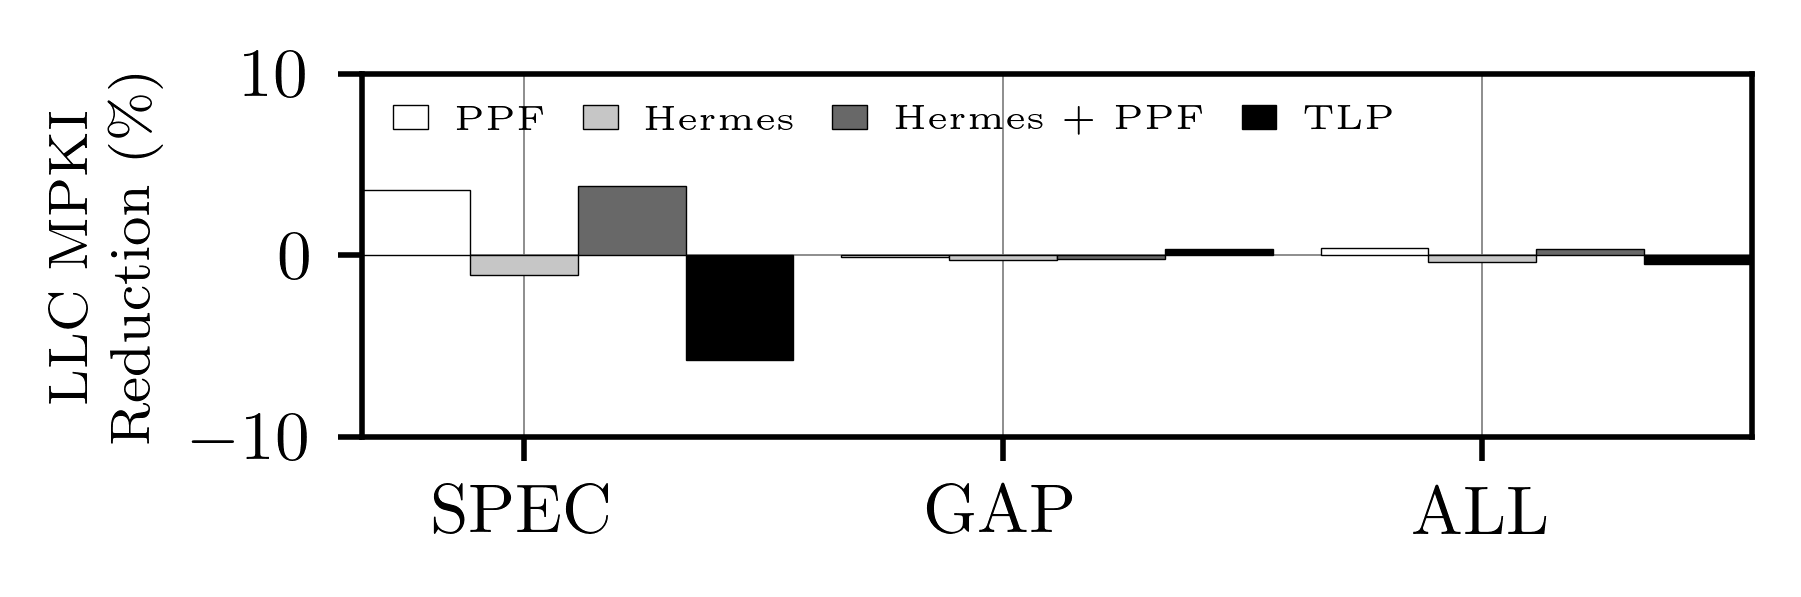

In [82]:
# Here is the actual plotting material.
fig_l1d_pref_coverage = plt.figure(
    constrained_layout=True, figsize=set_size(fig_width), dpi=500)
fig_l1d_pref_coverage.tight_layout(pad=0)
gs = GridSpec(1, 1, figure=fig_l1d_pref_coverage)

fig_l1d_pref_coverage = fig_l1d_pref_coverage.add_subplot(
    gs[:])
fig_l1d_pref_coverage.margins(x=0, tight=True)

xticklabels = df_l1d_coverage.index.tolist()
xticklabels = [sub_re_trailing_sdc.sub(repl='', string=e) for e in xticklabels]
xticklabels = [sub_re_trailing_und.sub(
    repl=r'\_', string=e) for e in xticklabels]

key_list = df_l1d_coverage.columns.to_list()
# key_list = ['hermes_o_pc_based_2k_entries', 'hermes_o_pc_based', 'popet_o', 'hermes_o_perfect']

cat_spacing = 0.1
bar_width, index = (1 - cat_spacing) / \
    len(key_list), np.arange(1, len(xticklabels) + 1)

colors = cm.get_cmap(plot_cmp)(np.linspace(
    0.0, 1.0, len(key_list), endpoint=True))

for i, (e, c) in enumerate(zip(key_list, colors)):
    fig_l1d_pref_coverage.bar(index + (i - 1) * (bar_width),
                              df_l1d_coverage[e], width=bar_width, edgecolor='black', linewidth=0.2, align='center', label=labels_dict[e], color=c)

fig_l1d_pref_coverage.set_xticks(index)
fig_l1d_pref_coverage.set_xticklabels(xticklabels, rotation=0)
# fig_l1d_pref_coverage.set_xticklabels([])
fig_l1d_pref_coverage.grid(
    color='grey', linestyle='-', linewidth=0.25)
fig_l1d_pref_coverage.set_axisbelow(True)

fig_l1d_pref_coverage.set_ylabel('LLC MPKI\nReduction (\%)')

fig_l1d_pref_coverage.tick_params(axis='both')
fig_l1d_pref_coverage.tick_params(labeltop=False)

fig_l1d_pref_coverage.set_ylim([-10.0, 10.0])

fig_l1d_pref_coverage.legend(loc='upper left', edgecolor='white', fancybox=False, framealpha=0.0,
                             ncol=4,
                             fontsize=5,
                             #    labelspacing=1.0,
                             #    bbox_to_anchor=(0, 0.925, 1, 0.25),
                             #    mode='expand'
                             )

for tick in fig_l1d_pref_coverage.xaxis.get_major_ticks():
    tick.label1.set_horizontalalignment('center')

plt.savefig('12_HPCA30_Paper/plots/evaluation/single_core_ipcp_evaluation_l1d_prefetcher_coverage.pdf',
            format='pdf', dpi='figure')
plt.savefig('12_HPCA30_Paper/plots/evaluation/single_core_ipcp_evaluation_l1d_prefetcher_coverage.png',
            format='png', dpi='figure')


In [83]:
dict_split_offchip_mispred_hermes_spec = {
    'offchip_pred_l1d': [final_res_set_spec[2].sets[0][k]['offchip_pred']['miss_hit_l1d'] for k in spec_keys if k != 'mean'],
    'offchip_pred_l2c': [final_res_set_spec[2].sets[0][k]['offchip_pred']['miss_hit_l2c'] for k in spec_keys if k != 'mean'],
    'offchip_pred_l2c_llc': [final_res_set_spec[2].sets[0][k]['offchip_pred']['miss_hit_l2c_llc'] for k in spec_keys if k != 'mean'],
    'offchip_pred_dram': [1 - (final_res_set_spec[2].sets[0][k]['offchip_pred']['miss_hit_l2c_llc'] + final_res_set_spec[2].sets[0][k]['offchip_pred']['miss_hit_l1d'] + final_res_set_spec[2].sets[0][k]['offchip_pred']['miss_hit_l2c']) for k in spec_keys if k != 'mean'],
}

df_split_offchip_mispred_hermes_spec = pandas.DataFrame(
    dict_split_offchip_mispred_hermes_spec, columns=dict_split_offchip_mispred_hermes_spec.keys(), index=[k for k in spec_keys if k != 'mean'])

# # Sorting by geomean speed-up.
# df_split_offchip_mispred_hermes_spec.sort_values(
#     by='geomean', axis='columns', inplace=True)
# df_tmp = df_split_offchip_mispred_hermes_spec[df_split_offchip_mispred_hermes_spec.index != 'mean'].sort_values(
#     by=df_split_offchip_mispred_hermes_spec.columns.to_list()[0], axis='rows', inplace=False)
# df_split_offchip_mispred_hermes_spec = pandas.concat(
#     [df_tmp, df_split_offchip_mispred_hermes_spec[df_split_offchip_mispred_hermes_spec.index == 'mean']])

df_split_offchip_mispred_hermes_spec *= 100.0

# speedup_gapbs_keys = df_split_offchip_mispred_hermes_spec.index.to_list()
# gapbs_keys = speedup_gapbs_keys[:-1] + ['mean']

display(df_split_offchip_mispred_hermes_spec)

# Labels for the plots.
labels_dict = {
    'offchip_pred_l1d': 'L1D',
    'offchip_pred_l2c_llc': 'L2C/LLC',
    'offchip_pred_dram': 'DRAM',
}


,offchip_pred_l1d,offchip_pred_l2c,offchip_pred_l2c_llc,offchip_pred_dram
621.wrf_s,41.504523,11.888357,18.591938,28.015181
456.hmmer,41.550249,18.785780,17.698238,21.965733
657.xz_s,22.905657,23.825270,6.865783,46.403290
459.GemsFDTD,15.248250,18.080354,24.078854,42.592541
623.xalancbmk_s,20.553502,19.871333,17.152254,42.422911
436.cactusADM,25.908723,12.391611,27.292614,34.407051
628.pop2_s,22.649741,13.434650,29.730020,34.185589
437.leslie3d,21.646247,20.708592,21.094762,36.550399
401.bzip2,31.574553,25.941980,13.101915,29.381553
445.gobmk,37.085633,14.014719,5.909270,42.990377


In [84]:
dict_split_offchip_mispred_hermes_gapbs = {
    'offchip_pred_l1d': [final_res_set_gapbs[2].sets[0][k]['offchip_pred']['miss_hit_l1d'] for k in gapbs_keys if k != 'mean'],
    'offchip_pred_l2c': [final_res_set_gapbs[2].sets[0][k]['offchip_pred']['miss_hit_l2c'] for k in gapbs_keys if k != 'mean'],
    'offchip_pred_l2c_llc': [final_res_set_gapbs[2].sets[0][k]['offchip_pred']['miss_hit_l2c_llc'] for k in gapbs_keys if k != 'mean'],
    'offchip_pred_dram': [1 - (final_res_set_gapbs[2].sets[0][k]['offchip_pred']['miss_hit_l2c_llc'] + final_res_set_gapbs[2].sets[0][k]['offchip_pred']['miss_hit_l1d'] + final_res_set_gapbs[2].sets[0][k]['offchip_pred']['miss_hit_l2c']) for k in gapbs_keys if k != 'mean'],
}

df_split_offchip_mispred_hermes_gapbs = pandas.DataFrame(
    dict_split_offchip_mispred_hermes_gapbs, columns=dict_split_offchip_mispred_hermes_gapbs.keys(), index=[k for k in gapbs_keys if k != 'mean'])

# # Sorting by geomean speed-up.
# df_split_offchip_mispred_hermes_gapbs.sort_values(
#     by='geomean', axis='columns', inplace=True)
# df_tmp = df_split_offchip_mispred_hermes_gapbs[df_split_offchip_mispred_hermes_gapbs.index != 'mean'].sort_values(
#     by=df_split_offchip_mispred_hermes_gapbs.columns.to_list()[0], axis='rows', inplace=False)
# df_split_offchip_mispred_hermes_gapbs = pandas.concat(
#     [df_tmp, df_split_offchip_mispred_hermes_gapbs[df_split_offchip_mispred_hermes_gapbs.index == 'mean']])

df_split_offchip_mispred_hermes_gapbs *= 100.0

# speedup_gapbs_keys = df_split_offchip_mispred_hermes_gapbs.index.to_list()
# gapbs_keys = speedup_gapbs_keys[:-1] + ['mean']

display(df_split_offchip_mispred_hermes_gapbs)

# Labels for the plots.
labels_dict = {
    'offchip_pred_l1d': 'L1D',
    'offchip_pred_l2c': 'L2C',
    'offchip_pred_l2c_llc': 'LLC',
    'offchip_pred_dram': 'DRAM',
}


,offchip_pred_l1d,offchip_pred_l2c,offchip_pred_l2c_llc,offchip_pred_dram
cc.web.sdc,24.158693,8.099710,25.939766,41.801831
tc.twitter.sdc,19.637074,14.623007,9.902720,55.837198
pr.road.sdc,30.590347,12.493832,11.176970,45.738852
cc.road.sdc,32.202121,3.762288,16.448300,47.587291
tc.friendster.sdc,16.561729,9.095992,9.489044,64.853235
tc.road.sdc,39.780751,5.199279,9.870195,45.149775
bc.web.sdc,13.495755,3.759758,8.869464,73.875023
tc.urand.sdc,24.655746,1.519100,7.169616,66.655537
sssp.web.sdc,13.747651,6.335835,26.078239,53.838275
cc.twitter.sdc,25.950720,15.586251,5.459143,53.003886


In [85]:
df_split_offchip_mispred_hermes = pandas.concat(
    [df_split_offchip_mispred_hermes_spec, df_split_offchip_mispred_hermes_gapbs])

df_split_offchip_mispred_hermes_mean = pandas.DataFrame({
    'offchip_pred_l1d': [np.mean(df_split_offchip_mispred_hermes['offchip_pred_l1d'])],
    'offchip_pred_l2c': [np.mean(df_split_offchip_mispred_hermes['offchip_pred_l2c'])],
    'offchip_pred_l2c_llc': [np.mean(df_split_offchip_mispred_hermes['offchip_pred_l2c_llc'])],
    'offchip_pred_dram': [np.mean(df_split_offchip_mispred_hermes['offchip_pred_dram'])],
}, index=['AVG'])

# df_split_offchip_mispred_hermes = pandas.concat([df_split_offchip_mispred_hermes, df_split_offchip_mispred_hermes_mean])

display(df_split_offchip_mispred_hermes)
display(df_split_offchip_mispred_hermes_mean)


,offchip_pred_l1d,offchip_pred_l2c,offchip_pred_l2c_llc,offchip_pred_dram
621.wrf_s,41.504523,11.888357,18.591938,28.015181
456.hmmer,41.550249,18.785780,17.698238,21.965733
657.xz_s,22.905657,23.825270,6.865783,46.403290
459.GemsFDTD,15.248250,18.080354,24.078854,42.592541
623.xalancbmk_s,20.553502,19.871333,17.152254,42.422911
436.cactusADM,25.908723,12.391611,27.292614,34.407051
628.pop2_s,22.649741,13.434650,29.730020,34.185589
437.leslie3d,21.646247,20.708592,21.094762,36.550399
401.bzip2,31.574553,25.941980,13.101915,29.381553
445.gobmk,37.085633,14.014719,5.909270,42.990377


,offchip_pred_l1d,offchip_pred_l2c,offchip_pred_l2c_llc,offchip_pred_dram
AVG,17.699567,11.475801,13.018641,57.80599


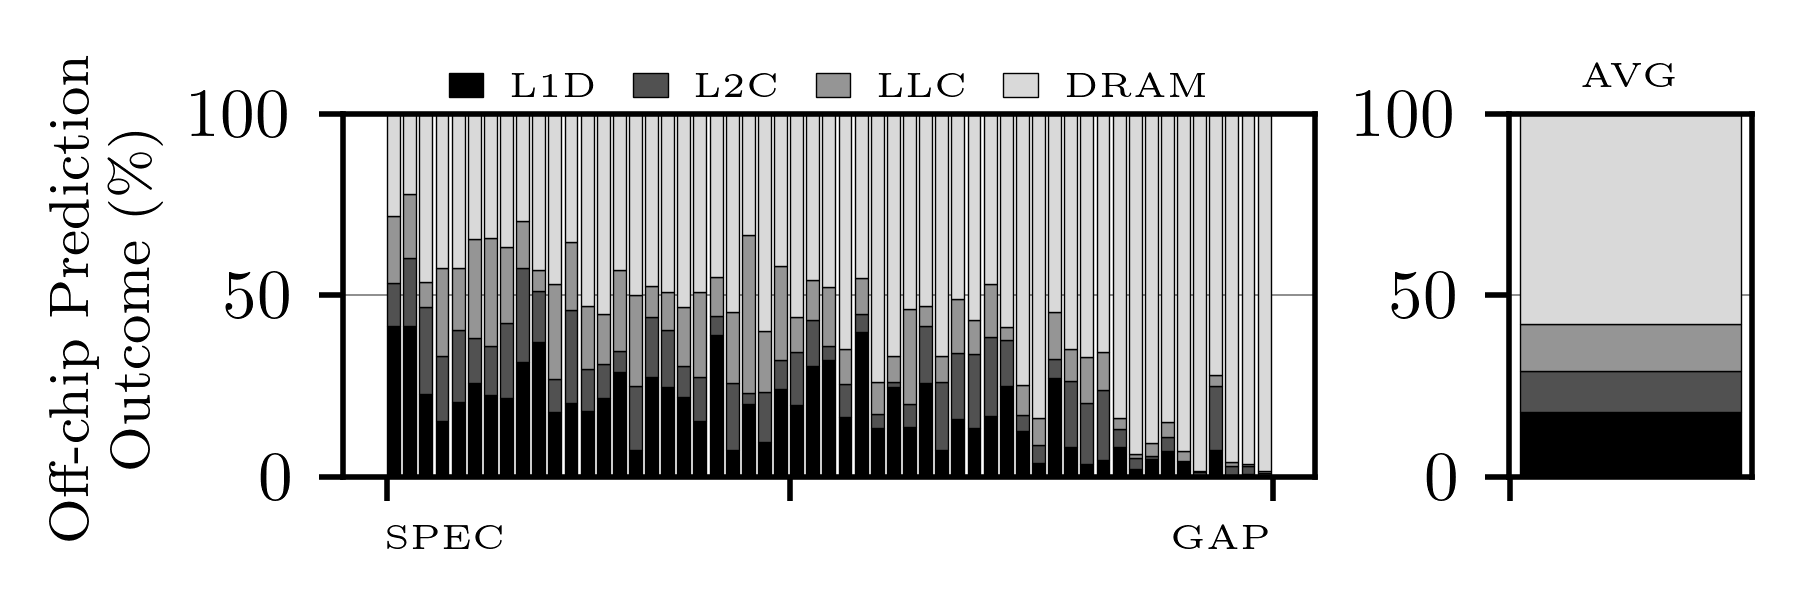

In [86]:
markers = ['.', 's', 'o', 'x', '>', '<', 'v', '^', 'h', 'D']

# Here is the actual plotting material.
fig_hit_miss_l1d = plt.figure(
    constrained_layout=True, figsize=set_size(fig_width), dpi=500)
fig_hit_miss_l1d.tight_layout(pad=0)
gs = GridSpec(nrows=1, ncols=5, figure=fig_hit_miss_l1d)

ax_hit_miss_l1d, ax_hit_miss_l1d_mean = fig_hit_miss_l1d.add_subplot(
    gs[0, :4]), fig_hit_miss_l1d.add_subplot(gs[0, 4:])
xticklabels = df_split_offchip_mispred_hermes.index.tolist()
xticklabels = [sub_re_trailing_sdc.sub(repl='', string=e) for e in xticklabels]
xticklabels = [sub_re_trailing_und.sub(
    repl=r'\_', string=e) for e in xticklabels]

key_list = df_split_offchip_mispred_hermes.columns.to_list()
# key_list = ['hermes_o_pc_based', 'popet_o', 'hermes_o_perceptron_pc_pfn']

cat_spacing = 0.05
bar_width, index = (1 - cat_spacing) / \
    len(key_list), np.arange(0, len(xticklabels))

colors = cm.get_cmap(plot_cmp)(np.linspace(
    0.0, 1.0, len(key_list) + 1, endpoint=True))[1:][::-1]

prev = np.array([0.0 for _ in range(len(df_split_offchip_mispred_hermes))])

for i, (e, c, m) in enumerate(zip(key_list, colors, markers)):
    ax_hit_miss_l1d.bar(index + (cat_spacing / 2),
                        df_split_offchip_mispred_hermes[e],
                        bottom=prev,
                        edgecolor='black',
                        linewidth=0.2,
                        align='edge',
                        label=labels_dict[e], color=c)

    prev += np.array(df_split_offchip_mispred_hermes[e].to_list())

# ax_hit_miss_l1d.axvspan(xmin=0, xmax=len(spec_keys), color='black', alpha=1.0, zorder=-1)
# ax_hit_miss_l1d.axvline(x=len(spec_keys) + 1, color='red', linestyle='--', linewidth=0.35)
# ax_hit_miss_l1d.axvline(x=len(spec_keys) + len(gapbs_keys) + 1, color='red', linestyle='--', linewidth=0.35)


ax_hit_miss_l1d.set_xticks(
    [0, len(spec_keys) + 1, len(spec_keys) + len(gapbs_keys)])
# ax_hit_miss_l1d.set_xticklabels(xticklabels, rotation=90, fontsize=5)
ax_hit_miss_l1d.set_xticklabels(['SPEC', '', 'GAP'], fontsize=5)
ax_hit_miss_l1d.grid(
    color='grey', linestyle='-', linewidth=0.25, axis='y')
ax_hit_miss_l1d.set_axisbelow(True)

ax_hit_miss_l1d.set_ylabel(
    'Off-chip Prediction\nOutcome (\%)', fontsize=8)

ax_hit_miss_l1d.tick_params(axis='both')
ax_hit_miss_l1d.tick_params(labeltop=False)
ax_hit_miss_l1d.tick_params(axis='x',
                            which='both',
                            bottom=True,
                            top=False)

ax_hit_miss_l1d.set_ylim([0.0, 100.0])

# for idx, tick in enumerate(ax_hit_miss_l1d.xaxis.get_major_ticks()):
#     if idx == 0 or idx == 2:
#         tick.set_visible(False)
#         tick.label1.set_visible(True)
#     tick.label1.set_horizontalalignment('center')
ax_hit_miss_l1d.xaxis.get_major_ticks(
)[0].label1.set_horizontalalignment('left')
ax_hit_miss_l1d.xaxis.get_majorticklabels()[0].set_x(len(spec_keys) / 2)
ax_hit_miss_l1d.xaxis.get_major_ticks(
)[-1].label1.set_horizontalalignment('right')
ax_hit_miss_l1d.xaxis.get_majorticklabels(
)[-1].set_x(len(gapbs_keys) + len(spec_keys) / 2)

ax_hit_miss_l1d.legend(loc='upper center', edgecolor='white', fancybox=False, framealpha=0.0, ncol=4,
           bbox_to_anchor=(0.5, 1.2),
           fontsize=5
           )

# Plotting the mean in a seperate subplot.
xticklabels = df_split_offchip_mispred_hermes_mean.index.to_list()
cat_spacing = 0.075
bar_width, index = (1 - cat_spacing) / \
    len(key_list), np.arange(1, len(xticklabels) + 1)

colors = cm.get_cmap(plot_cmp)(np.linspace(
    0.0, 1.0, len(key_list) + 1, endpoint=True))[1:][::-1]
prev = np.array(
    [0.0 for _ in range(len(df_split_offchip_mispred_hermes_mean))])

for i, (e, c, m) in enumerate(zip(key_list, colors, markers)):
    bars = ax_hit_miss_l1d_mean.bar(index + (cat_spacing / 2),
                                    df_split_offchip_mispred_hermes_mean[e],
                                    bottom=prev,
                                    edgecolor='black',
                                    linewidth=0.2,
                                    align='edge',
                                    label=labels_dict[e], color=c)

    prev += df_split_offchip_mispred_hermes_mean[e]

ax_hit_miss_l1d_mean.set_ylim([0.0, 100.0])
ax_hit_miss_l1d_mean.set_xticks(index)
ax_hit_miss_l1d_mean.set_xticklabels([])
ax_hit_miss_l1d_mean.bar_label(ax_hit_miss_l1d_mean.containers[-1], labels=[
                               'AVG'], label_type='edge', rotation=0, fontsize=5, padding=3)
ax_hit_miss_l1d_mean.grid(
    color='grey', linestyle='-', linewidth=0.25)
ax_hit_miss_l1d_mean.set_axisbelow(True)

plt.savefig('12_HPCA30_Paper/plots/evaluation/single_core_ipcp_offchip_mispredictions.pdf',
            format='pdf', dpi='figure')
plt.savefig('12_HPCA30_Paper/plots/evaluation/single_core_ipcp_offchip_mispredictions.png',
            format='png', dpi='figure')


In [87]:
dict_l1d_pref_useless_spec = {
    'l2c': [final_res_set_spec[-1].sets[0][k]['l1d_prefetcher']['useless']['l2c'] for k in spec_keys if k != 'mean'],
    'llc': [final_res_set_spec[-1].sets[0][k]['l1d_prefetcher']['useless']['llc'] for k in spec_keys if k != 'mean'],
    'dram': [final_res_set_spec[-1].sets[0][k]['l1d_prefetcher']['useless']['dram'] for k in spec_keys if k != 'mean'],
}

df_l1d_pref_useless_spec = pandas.DataFrame(
    dict_l1d_pref_useless_spec, columns=dict_l1d_pref_useless_spec.keys(), index=[k for k in spec_keys if k != 'mean'])

display(np.mean(df_l1d_pref_useless_spec))

# # Sorting by geomean speed-up.
# df_l1d_pref_useless_spec.sort_values(
#     by='geomean', axis='columns', inplace=True)
# df_tmp = df_l1d_pref_useless_spec[df_l1d_pref_useless_spec.index != 'mean'].sort_values(
#     by=df_l1d_pref_useless_spec.columns.to_list()[-1], axis='rows', inplace=False)
# df_l1d_pref_useless_spec = pandas.concat(
#     [df_tmp, df_l1d_pref_useless_spec[df_l1d_pref_useless_spec.index == 'mean']])

# speedup_gapbs_keys = df_l1d_pref_useless_spec.index.to_list()
# gapbs_keys = speedup_gapbs_keys[:-1] + ['mean']

# display(df_l1d_pref_useless_spec)

# Labels for the plots.
labels_dict = {
    'l2c': 'L2C',
    'llc': 'LLC',
    'dram': 'DRAM',
}


/home/alexandre/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


l2c     5.905628
llc     0.367191
dram    5.335622
dtype: float64

In [88]:
dict_l1d_pref_useless_gapbs = {
    'l2c': [final_res_set_gapbs[-1].sets[0][k]['l1d_prefetcher']['useless']['l2c'] for k in gapbs_keys if k != 'mean'],
    'llc': [final_res_set_gapbs[-1].sets[0][k]['l1d_prefetcher']['useless']['llc'] for k in gapbs_keys if k != 'mean'],
    'dram': [final_res_set_gapbs[-1].sets[0][k]['l1d_prefetcher']['useless']['dram'] for k in gapbs_keys if k != 'mean'],
}

df_l1d_pref_useless_gapbs = pandas.DataFrame(
    dict_l1d_pref_useless_gapbs, columns=dict_l1d_pref_useless_gapbs.keys(), index=[k for k in gapbs_keys if k != 'mean'])

display(np.mean(df_l1d_pref_useless_gapbs))

# # Sorting by geomean speed-up.
# df_l1d_pref_useless_gapbs.sort_values(
#     by='geomean', axis='columns', inplace=True)
# df_tmp = df_l1d_pref_useless_gapbs[df_l1d_pref_useless_gapbs.index != 'mean'].sort_values(
#     by=df_l1d_pref_useless_gapbs.columns.to_list()[-1], axis='rows', inplace=False)
# df_l1d_pref_useless_gapbs = pandas.concat(
#     [df_tmp, df_l1d_pref_useless_gapbs[df_l1d_pref_useless_gapbs.index == 'mean']])

# speedup_gapbs_keys = df_l1d_pref_useless_gapbs.index.to_list()
# gapbs_keys = speedup_gapbs_keys[:-1] + ['mean']

# display(df_l1d_pref_useless_gapbs)

# Labels for the plots.
labels_dict = {
    'l2c': 'L2C',
    'llc': 'LLC',
    'dram': 'DRAM',
}


/home/alexandre/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


l2c     10.137345
llc      2.754210
dram    58.980208
dtype: float64

In [89]:
df_l1d_pref_useless = pandas.concat(
    [df_l1d_pref_useless_spec, df_l1d_pref_useless_gapbs])

df_l1d_pref_useless_mean = pandas.DataFrame({
    'l2c': [np.mean(df_l1d_pref_useless['l2c'])],
    'llc': [np.mean(df_l1d_pref_useless['llc'])],
    'dram': [np.mean(df_l1d_pref_useless['dram'])],
}, index=['AVG'])

# df_l1d_pref_useless = pandas.concat([df_l1d_pref_useless, df_l1d_pref_useless_mean])

display(df_l1d_pref_useless)
display(df_l1d_pref_useless_mean)


,l2c,llc,dram
621.wrf_s,0.435472,0.065828,1.160277
456.hmmer,0.644525,0.101381,1.205192
657.xz_s,4.708863,0.207107,2.476040
459.GemsFDTD,0.597558,0.073986,1.701537
623.xalancbmk_s,7.414147,0.285669,3.310459
436.cactusADM,26.112000,0.091140,3.287030
628.pop2_s,0.688460,0.084680,1.322280
437.leslie3d,0.279243,0.078545,1.786765
401.bzip2,24.427898,0.817189,8.228515
445.gobmk,7.757689,0.199382,1.195744


,l2c,llc,dram
AVG,8.290778,1.712602,35.571662


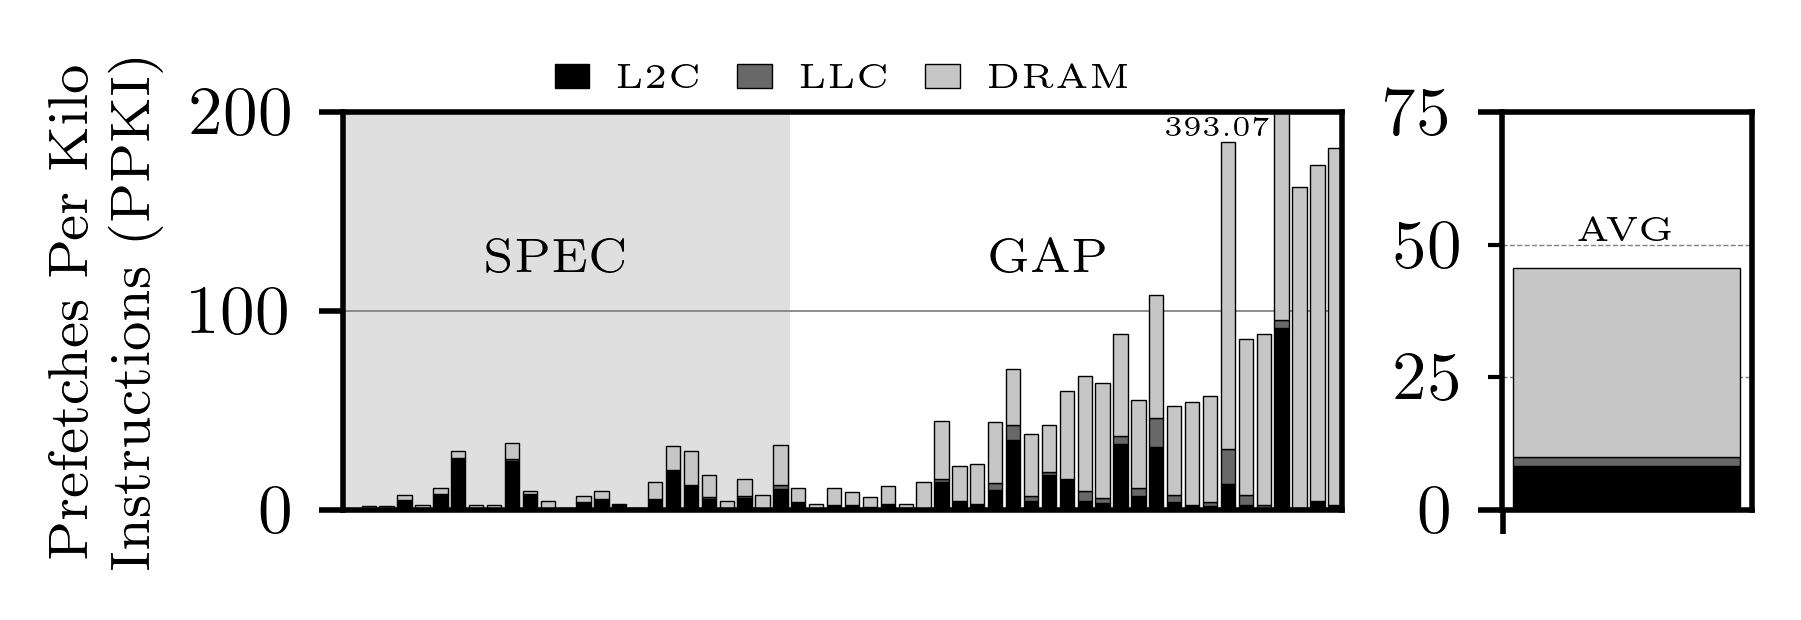

In [90]:
markers = ['.', 's', 'o', 'x', '>', '<', 'v', '^', 'h', 'D']

# Here is the actual plotting material.
fig_hit_miss_l1d = plt.figure(
    constrained_layout=True, figsize=set_size(fig_width), dpi=500)
fig_hit_miss_l1d.tight_layout(pad=0)
gs = GridSpec(nrows=1, ncols=5, figure=fig_hit_miss_l1d)

ax_l1d_useless_loc, ax_l1d_useless_loc_mean = fig_hit_miss_l1d.add_subplot(
    gs[0, :4]), fig_hit_miss_l1d.add_subplot(gs[0, 4:])
ax_l1d_useless_loc.margins(x=0, tight=True)

xticklabels = df_l1d_pref_useless.index.tolist()
xticklabels = [sub_re_trailing_sdc.sub(repl='', string=e) for e in xticklabels]
xticklabels = [sub_re_trailing_und.sub(
    repl=r'\_', string=e) for e in xticklabels]

key_list = df_l1d_pref_useless.columns.to_list()
# key_list = ['hermes_o_pc_based', 'popet_o', 'hermes_o_perceptron_pc_pfn']

cat_spacing = 0.075
bar_width, index = (1 - cat_spacing) / \
    len(key_list), np.arange(1, len(xticklabels) + 1)

colors = cm.get_cmap(plot_cmp)(np.linspace(
    0.0, 1.0, len(key_list) + 1, endpoint=True))[1:][::-1]

prev = np.array([0.0 for _ in range(len(df_l1d_pref_useless))])
bars = None

for i, (e, c, m) in enumerate(zip(key_list, colors, markers)):
    bars = ax_l1d_useless_loc.bar(index + (cat_spacing / 2),
                                  df_l1d_pref_useless[e],
                                  bottom=prev,
                                  edgecolor='black',
                                  linewidth=0.2,
                                  align='edge',
                                  label=labels_dict[e], color=c)

    prev += np.array(df_l1d_pref_useless[e].to_list())

ax_l1d_useless_loc.axvspan(xmin=0, xmax=len(
    df_l1d_pref_useless_spec) + 1, facecolor='grey', alpha=0.25, zorder=-1)
# ax_l1d_useless_loc.axvline(x=len(df_l1d_pref_useless_spec) + len(df_l1d_pref_useless_gapbs) + 1, color='red', linestyle='--', linewidth=0.35)

# Annotating the 5th to last bar of the plot.
ax_l1d_useless_loc.annotate(f'{prev[-4]:.2f}', (bars.patches[-4].get_x() + bars.patches[-4].get_width() / 2 - 3.5, 160
                                                ), ha='center', va='center', textcoords='offset points', xytext=(0, 9), size=4)

ax_l1d_useless_loc.set_xticks(index)
# ax_l1d_useless_loc.set_xticklabels(xticklabels, rotation=90, fontsize=5)
ax_l1d_useless_loc.set_xticklabels([])
ax_l1d_useless_loc.grid(
    color='grey', linestyle='-', linewidth=0.25, axis='y')
ax_l1d_useless_loc.set_axisbelow(True)

ax_l1d_useless_loc.set_ylabel(
    'Prefetches Per Kilo\nInstructions (PPKI)', fontsize=8)

ax_l1d_useless_loc.tick_params(axis='both')
ax_l1d_useless_loc.tick_params(labeltop=False)
ax_l1d_useless_loc.tick_params(axis='x',
                               which='both',
                               bottom=False,
                               top=False)

# ax_l1d_useless_loc.set_yscale('log')
ax_l1d_useless_loc.set_ylim([0.0, 200.0])

for tick in ax_l1d_useless_loc.xaxis.get_major_ticks():
    tick.label1.set_horizontalalignment('left')

ax_l1d_useless_loc.legend(loc='upper center', edgecolor='white', fancybox=False, framealpha=0.0, ncol=3,
                          bbox_to_anchor=(0.5, 1.2),
                          fontsize=5
                          )

# Annotating the benchmark suites on the plots.
ax_l1d_useless_loc.annotate(
    'SPEC', (len(spec_keys) / 2, 125), ha='center', va='center', size=7)
ax_l1d_useless_loc.annotate('GAP', (len(
    spec_keys) + len(gapbs_keys) / 2, 125), ha='center', va='center', size=7)

# Plotting the mean in a seperate subplot.
xticklabels = df_l1d_pref_useless_mean.index.to_list()
cat_spacing = 0.075
bar_width, index = (1 - cat_spacing) / \
    len(key_list), np.arange(1, len(xticklabels) + 1)

colors = cm.get_cmap(plot_cmp)(np.linspace(
    0.0, 1.0, len(key_list) + 1, endpoint=True))[1:][::-1]
prev = np.array([0.0 for _ in range(len(df_l1d_pref_useless_mean))])

for i, (e, c, m) in enumerate(zip(key_list, colors, markers)):
    bars = ax_l1d_useless_loc_mean.bar(index + (cat_spacing / 2),
                                       df_l1d_pref_useless_mean[e],
                                       bottom=prev,
                                       edgecolor='black',
                                       linewidth=0.2,
                                       align='edge',
                                       label=labels_dict[e], color=c)

    prev += df_l1d_pref_useless_mean[e]

ax_l1d_useless_loc_mean.yaxis.set_major_locator(MultipleLocator(75))
ax_l1d_useless_loc_mean.yaxis.set_major_formatter('{x:.0f}')
ax_l1d_useless_loc_mean.yaxis.set_minor_locator(MultipleLocator(25))
ax_l1d_useless_loc_mean.yaxis.set_minor_formatter('{x:.0f}')

ax_l1d_useless_loc_mean.set_ylim([0.0, 75.0])
ax_l1d_useless_loc_mean.set_xticks(index)
ax_l1d_useless_loc_mean.set_xticklabels([])
ax_l1d_useless_loc_mean.bar_label(ax_l1d_useless_loc_mean.containers[-1], labels=[
                                  'AVG'], label_type='edge', rotation=0, fontsize=5, padding=3)
ax_l1d_useless_loc_mean.grid(
    color='grey', linestyle='-', linewidth=0.25)
ax_l1d_useless_loc_mean.grid(True, which='minor', color='grey',
                             linestyle='--', linewidth=0.2, axis='y')
ax_l1d_useless_loc_mean.set_axisbelow(True)

plt.savefig('12_HPCA30_Paper/plots/evaluation/single_core_ipcp_l1d_pref_useless.pdf',
            format='pdf', dpi='figure')
plt.savefig('12_HPCA30_Paper/plots/evaluation/single_core_ipcp_l1d_pref_useless.png',
            format='png', dpi='figure')


In [91]:
dict_l1d_pref_useful_spec = {
    'l2c': [final_res_set_spec[-1].sets[0][k]['l1d_prefetcher']['useful']['l2c'] for k in spec_keys if k != 'mean'],
    'llc': [final_res_set_spec[-1].sets[0][k]['l1d_prefetcher']['useful']['llc'] for k in spec_keys if k != 'mean'],
    'dram': [final_res_set_spec[-1].sets[0][k]['l1d_prefetcher']['useful']['dram'] for k in spec_keys if k != 'mean'],
}

df_l1d_pref_useful_spec = pandas.DataFrame(
    dict_l1d_pref_useful_spec, columns=dict_l1d_pref_useful_spec.keys(), index=[k for k in spec_keys if k != 'mean'])

display(np.mean(df_l1d_pref_useful_spec))


/home/alexandre/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


l2c     0.808836
llc     0.318653
dram    1.173064
dtype: float64

In [92]:
dict_l1d_pref_useful_gapbs = {
    'l2c': [final_res_set_gapbs[-1].sets[0][k]['l1d_prefetcher']['useful']['l2c'] for k in gapbs_keys if k != 'mean'],
    'llc': [final_res_set_gapbs[-1].sets[0][k]['l1d_prefetcher']['useful']['llc'] for k in gapbs_keys if k != 'mean'],
    'dram': [final_res_set_gapbs[-1].sets[0][k]['l1d_prefetcher']['useful']['dram'] for k in gapbs_keys if k != 'mean'],
}

df_l1d_pref_useful_gapbs = pandas.DataFrame(
    dict_l1d_pref_useful_gapbs, columns=dict_l1d_pref_useful_gapbs.keys(), index=[k for k in gapbs_keys if k != 'mean'])

display(np.mean(df_l1d_pref_useful_gapbs))

/home/alexandre/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


l2c     0.458702
llc     1.310158
dram    2.035533
dtype: float64

In [93]:
df_l1d_pref_useful = pandas.concat(
    [df_l1d_pref_useful_spec, df_l1d_pref_useful_gapbs])

df_l1d_pref_useful_mean = pandas.DataFrame({
    'l2c': [np.mean(df_l1d_pref_useful['l2c'])],
    'llc': [np.mean(df_l1d_pref_useful['llc'])],
    'dram': [np.mean(df_l1d_pref_useful['dram'])],
}, index=['AVG'])

# df_l1d_pref_useful = pandas.concat([df_l1d_pref_useful, df_l1d_pref_useful_mean])

display(df_l1d_pref_useful)
display(df_l1d_pref_useful_mean)


,l2c,llc,dram
621.wrf_s,0.426383,0.397123,0.129145
456.hmmer,0.732815,0.083233,0.265473
657.xz_s,0.335011,0.021547,0.081777
459.GemsFDTD,0.395022,0.304571,0.238718
623.xalancbmk_s,1.337736,0.506665,2.701508
436.cactusADM,0.920750,0.181630,0.732170
628.pop2_s,0.912850,0.207030,0.162900
437.leslie3d,0.419941,0.713425,0.213161
401.bzip2,2.643751,0.167657,0.182467
445.gobmk,0.276179,0.015253,0.034975


,l2c,llc,dram
AVG,0.611488,0.877501,1.659183


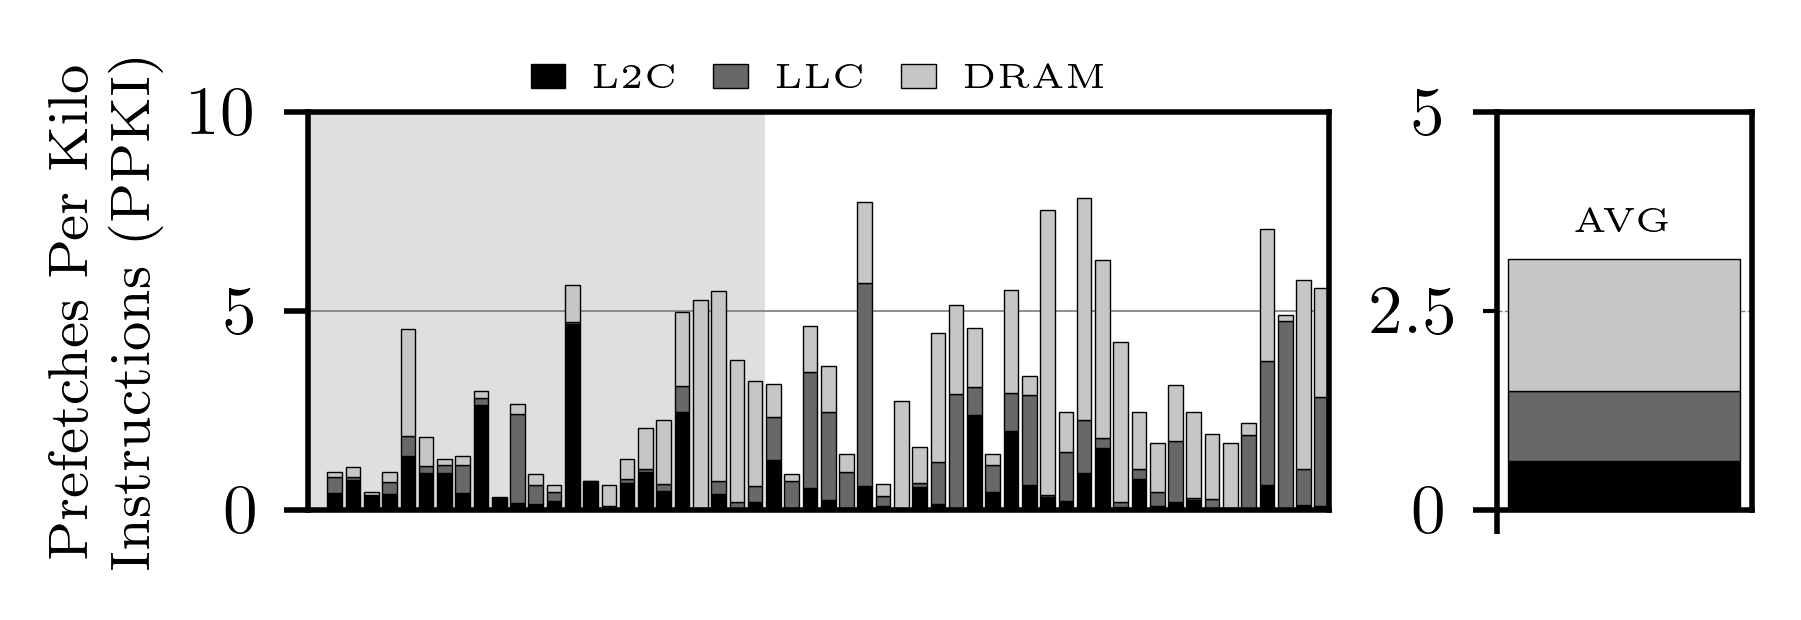

In [94]:
markers = ['.', 's', 'o', 'x', '>', '<', 'v', '^', 'h', 'D']

# Here is the actual plotting material.
fig_hit_miss_l1d = plt.figure(
    constrained_layout=True, figsize=set_size(fig_width), dpi=500)
fig_hit_miss_l1d.tight_layout(pad=0)
gs = GridSpec(nrows=1, ncols=5, figure=fig_hit_miss_l1d)

ax_l1d_useful_loc, ax_l1d_useful_loc_mean = fig_hit_miss_l1d.add_subplot(
    gs[0, :4]), fig_hit_miss_l1d.add_subplot(gs[0, 4:])
ax_l1d_useful_loc.margins(x=0, tight=True)

xticklabels = df_l1d_pref_useful.index.tolist()
xticklabels = [sub_re_trailing_sdc.sub(repl='', string=e) for e in xticklabels]
xticklabels = [sub_re_trailing_und.sub(
    repl=r'\_', string=e) for e in xticklabels]

key_list = df_l1d_pref_useful.columns.to_list()
# key_list = ['hermes_o_pc_based', 'popet_o', 'hermes_o_perceptron_pc_pfn']

cat_spacing = 0.075
bar_width, index = (1 - cat_spacing) / \
    len(key_list), np.arange(1, len(xticklabels) + 1)

colors = cm.get_cmap(plot_cmp)(np.linspace(
    0.0, 1.0, len(key_list) + 1, endpoint=True))[1:][::-1]

prev = np.array([0.0 for _ in range(len(df_l1d_pref_useful))])
bars = None

for i, (e, c, m) in enumerate(zip(key_list, colors, markers)):
    bars = ax_l1d_useful_loc.bar(index + (cat_spacing / 2),
                                  df_l1d_pref_useful[e],
                                  bottom=prev,
                                  edgecolor='black',
                                  linewidth=0.2,
                                  align='edge',
                                  label=labels_dict[e], color=c)

    prev += np.array(df_l1d_pref_useful[e].to_list())

ax_l1d_useful_loc.axvspan(xmin=0, xmax=len(
    df_l1d_pref_useful_spec) + 1, facecolor='grey', alpha=0.25, zorder=-1)
# ax_l1d_useful_loc.axvline(x=len(df_l1d_pref_useful_spec) + len(df_l1d_pref_useful_gapbs) + 1, color='red', linestyle='--', linewidth=0.35)

# Annotating the 5th to last bar of the plot.
ax_l1d_useful_loc.annotate(f'{prev[-4]:.2f}', (bars.patches[-4].get_x() + bars.patches[-4].get_width() / 2 - 3.5, 160
                                                ), ha='center', va='center', textcoords='offset points', xytext=(0, 9), size=4)

ax_l1d_useful_loc.set_xticks(index)
# ax_l1d_useful_loc.set_xticklabels(xticklabels, rotation=90, fontsize=5)
ax_l1d_useful_loc.set_xticklabels([])
ax_l1d_useful_loc.grid(
    color='grey', linestyle='-', linewidth=0.25, axis='y')
ax_l1d_useful_loc.set_axisbelow(True)

ax_l1d_useful_loc.set_ylabel(
    'Prefetches Per Kilo\nInstructions (PPKI)', fontsize=8)

ax_l1d_useful_loc.tick_params(axis='both')
ax_l1d_useful_loc.tick_params(labeltop=False)
ax_l1d_useful_loc.tick_params(axis='x',
                               which='both',
                               bottom=False,
                               top=False)

# ax_l1d_useful_loc.set_yscale('log')
ax_l1d_useful_loc.set_ylim([0.0, 10.0])

for tick in ax_l1d_useful_loc.xaxis.get_major_ticks():
    tick.label1.set_horizontalalignment('left')

ax_l1d_useful_loc.legend(loc='upper center', edgecolor='white', fancybox=False, framealpha=0.0, ncol=3,
                          bbox_to_anchor=(0.5, 1.2),
                          fontsize=5
                          )

# Annotating the benchmark suites on the plots.
ax_l1d_useful_loc.annotate(
    'SPEC', (len(spec_keys) / 2, 125), ha='center', va='center', size=7)
ax_l1d_useful_loc.annotate('GAP', (len(
    spec_keys) + len(gapbs_keys) / 2, 125), ha='center', va='center', size=7)

# Plotting the mean in a seperate subplot.
xticklabels = df_l1d_pref_useful_mean.index.to_list()
cat_spacing = 0.075
bar_width, index = (1 - cat_spacing) / \
    len(key_list), np.arange(1, len(xticklabels) + 1)

colors = cm.get_cmap(plot_cmp)(np.linspace(
    0.0, 1.0, len(key_list) + 1, endpoint=True))[1:][::-1]
prev = np.array([0.0 for _ in range(len(df_l1d_pref_useful_mean))])

for i, (e, c, m) in enumerate(zip(key_list, colors, markers)):
    bars = ax_l1d_useful_loc_mean.bar(index + (cat_spacing / 2),
                                       df_l1d_pref_useful_mean[e],
                                       bottom=prev,
                                       edgecolor='black',
                                       linewidth=0.2,
                                       align='edge',
                                       label=labels_dict[e], color=c)

    prev += df_l1d_pref_useful_mean[e]

ax_l1d_useful_loc_mean.yaxis.set_major_locator(MultipleLocator(5))
ax_l1d_useful_loc_mean.yaxis.set_major_formatter('{x:.0f}')
ax_l1d_useful_loc_mean.yaxis.set_minor_locator(MultipleLocator(2.5))
ax_l1d_useful_loc_mean.yaxis.set_minor_formatter('{x:.1f}')

ax_l1d_useful_loc_mean.set_ylim([0.0, 5.0])
ax_l1d_useful_loc_mean.set_xticks(index)
ax_l1d_useful_loc_mean.set_xticklabels([])
ax_l1d_useful_loc_mean.bar_label(ax_l1d_useful_loc_mean.containers[-1], labels=[
                                  'AVG'], label_type='edge', rotation=0, fontsize=5, padding=3)
ax_l1d_useful_loc_mean.grid(
    color='grey', linestyle='-', linewidth=0.25)
ax_l1d_useful_loc_mean.grid(True, which='minor', color='grey',
                             linestyle='--', linewidth=0.2, axis='y')
ax_l1d_useful_loc_mean.set_axisbelow(True)

plt.savefig('12_HPCA30_Paper/plots/evaluation/single_core_ipcp_l1d_pref_useful.pdf',
            format='pdf', dpi='figure')
plt.savefig('12_HPCA30_Paper/plots/evaluation/single_core_ipcp_l1d_pref_useful.png',
            format='png', dpi='figure')


## Evaluation for the Berti prefetcher

In [95]:
# Parsing results file containing data relative to simulations comparing designs using no prefetchers what so ever to designs using a prefetcher only in the L1D.
raw_data = p.parse(
    'results/micro23_04_07_23/', new_caches_parser, distill_cache_parser)
raw_data_cpy = deepcopy(raw_data)


In [96]:
# Defining the different configurations used to build this plot.
cl_baseline_config, config_list = \
    {'bin': 'baseline_cascade_lake_berti'}, [
        {'bin': 'baseline_cascade_lake_berti_l1d_filtered_prefetcher'}, # 0
        {'bin': 'baseline_cascade_lake_berti_double_l1d'},
        {'bin': 'baseline_cascade_lake_berti_hermes_o'},
        {'bin': 'baseline_cascade_lake_berti_spp_ppf'},

        # WIP: Addition of improved designs for the MICRO'23 rebuttals.
        # WIP: This is now design related to the HPCA'30 submission.
        {'bin': 'baseline_cascade_lake_berti_tlp_core_l1d_-15_-35_bis'}, # 4
        {'bin': 'baseline_cascade_lake_berti_tlp_layered_core_l1d_f20_-25'},
        {'bin': 'baseline_cascade_lake_berti_delayed_hermes_o'},
        {'bin': 'baseline_cascade_lake_berti_delayed_tlp'},
        {'bin': 'baseline_cascade_lake_berti_tlp_layered_core_l1d'},

        # Using a design combining SPP-PPF and Hermes-O as a comparison point for prefetcher accuracy.
        {'bin': 'baseline_cascade_lake_berti_spp_ppf_hermes_o'}, # 9
        {'bin': 'baseline_cascade_lake_berti_iso_prefetcher'},
        {'bin': 'baseline_cascade_lake_berti_hermes_o_double'},
        {'bin': 'baseline_cascade_lake_no_prefetchers'},

        # Designs relative to the coverage computation.
        {'bin': 'baseline_cascade_lake_spp_ppf'}, # 13
        {'bin': 'baseline_cascade_lake_hermes_o'},
        {'bin': 'baseline_cascade_lake_spp_ppf_hermes_o'},
        {'bin': 'baseline_cascade_lake_tlp_layered_core_l1d_f20_-25'},
        {'bin': 'baseline_cascade_lake_no_ipcp'},
        {'bin': 'baseline_cascade_lake_berti_block_prefs'},
        {'bin': 'baseline_cascade_lake_berti_slp'},
    ]

# Isolating results set based on the given configurations.
r_cl_base, r_list = \
    raw_data / cl_baseline_config, [
        raw_data / e for e in config_list]

temp_res_set = [r_cl_base]

temp_res_set.extend(r_list)
temp_res_set.append(raw_data_cpy / cl_baseline_config)

# Normalizing...
for e in temp_res_set:
    print(e.sets[0].config)
    normalize_llc_distill_cache(e.sets[0])


{'warmup_instructions': 100, 'simulation_instructions': 100, 'bin': 'baseline_cascade_lake_berti', 'uses_sdc': False}
{'warmup_instructions': 100, 'simulation_instructions': 100, 'bin': 'baseline_cascade_lake_berti_l1d_filtered_prefetcher', 'uses_sdc': False}
{'warmup_instructions': 100, 'simulation_instructions': 100, 'bin': 'baseline_cascade_lake_berti_double_l1d', 'uses_sdc': False}
{'warmup_instructions': 100, 'simulation_instructions': 100, 'bin': 'baseline_cascade_lake_berti_hermes_o', 'uses_sdc': False}
{'warmup_instructions': 100, 'simulation_instructions': 100, 'bin': 'baseline_cascade_lake_berti_spp_ppf', 'uses_sdc': False}
{'warmup_instructions': 100, 'simulation_instructions': 100, 'bin': 'baseline_cascade_lake_berti_tlp_core_l1d_-15_-35_bis', 'uses_sdc': False}
{'warmup_instructions': 100, 'simulation_instructions': 100, 'bin': 'baseline_cascade_lake_berti_tlp_layered_core_l1d_f20_-25', 'uses_sdc': False}


{'warmup_instructions': 100, 'simulation_instructions': 100, 'bin': 'baseline_cascade_lake_berti_delayed_hermes_o', 'uses_sdc': False}
{'warmup_instructions': 100, 'simulation_instructions': 100, 'bin': 'baseline_cascade_lake_berti_delayed_tlp', 'uses_sdc': False}
{'warmup_instructions': 100, 'simulation_instructions': 100, 'bin': 'baseline_cascade_lake_berti_tlp_layered_core_l1d', 'uses_sdc': False}
{'warmup_instructions': 100, 'simulation_instructions': 100, 'bin': 'baseline_cascade_lake_berti_spp_ppf_hermes_o', 'uses_sdc': False}
{'warmup_instructions': 100, 'simulation_instructions': 100, 'bin': 'baseline_cascade_lake_berti_iso_prefetcher', 'uses_sdc': False}
{'warmup_instructions': 100, 'simulation_instructions': 100, 'bin': 'baseline_cascade_lake_berti_hermes_o_double', 'uses_sdc': False}
{'warmup_instructions': 100, 'simulation_instructions': 100, 'bin': 'baseline_cascade_lake_no_prefetchers', 'uses_sdc': False}
{'warmup_instructions': 100, 'simulation_instructions': 100, 'bin':

In [97]:
final_res_set_gapbs = [apply_manipulator_to_all(e, apply_simpoint, temp_res_set[0].sets[0], simpoints_data, only_gapbs)
                       for e in temp_res_set[1:]]
final_res_set_spec = [apply_manipulator_to_all(e, apply_simpoint, temp_res_set[0].sets[0], simpoints_data, only_spec)
                      for e in temp_res_set[1:]]
final_res_set_spec06 = [apply_manipulator_to_all(e, apply_simpoint, temp_res_set[0].sets[0], simpoints_data, only_specs06)
                        for e in temp_res_set[1:]]
final_res_set_spec17 = [apply_manipulator_to_all(e, apply_simpoint, temp_res_set[0].sets[0], simpoints_data, only_specs17)
                        for e in temp_res_set[1:]]
final_res_set_ligra = [apply_manipulator_to_all(e, apply_simpoint, temp_res_set[0].sets[0], simpoints_data, only_ligra)
                       for e in temp_res_set[1:]]
final_res_set_all = [apply_manipulator_to_all(
    e, apply_simpoint, temp_res_set[0].sets[0], simpoints_data, exclude_ligra) for e in temp_res_set[1:]]

speedup_gapbs_keys = [e for e in final_res_set_gapbs[0].sets[0].keys()
                      if e != 'mean']
gapbs_keys = [e for e in final_res_set_gapbs[0].sets[0].keys()
              if e != 'geomean']
speedup_spec_keys = [e for e in final_res_set_spec[0].sets[0].keys()
                     if e != 'mean']
spec_keys = [e for e in final_res_set_spec[0].sets[0].keys()
             if e != 'geomean']
speedup_spec06_keys = [e for e in final_res_set_spec06[0].sets[0].keys()
                       if e != 'mean']
spec06_keys = [e for e in final_res_set_spec06[0].sets[0].keys()
               if e != 'geomean']
speedup_spec17_keys = [e for e in final_res_set_spec17[0].sets[0].keys()
                       if e != 'mean']
spec17_keys = [e for e in final_res_set_spec17[0].sets[0].keys()
               if e != 'geomean']
speedup_ligra_keys = [e for e in final_res_set_ligra[0].sets[0].keys()
                      if e != 'mean']
ligra_keys = [e for e in final_res_set_ligra[0].sets[0].keys()
              if e != 'geomean']
speedup_all_keys = [
    e for e in final_res_set_all[0].sets[0].keys() if e != 'mean']
all_keys = [
    e for e in final_res_set_all[0].sets[0].keys() if e != 'geomean']


workload_sets = [final_res_set_spec, final_res_set_gapbs, final_res_set_all]


/home/alexandre/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/alexandre/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [98]:
labels_dict = {
    'baseline_cascade_lake_no_l1d_prefetcher': 'No Prefetcher',
    'baseline_cascade_lake_l1d_filtered_prefetcher': 'TSP',
    'baseline_cascade_lake_double_l1d': 'L1D 64KB',
    'baseline_cascade_lake_hermes_o': 'Hermes',
    'baseline_cascade_lake_hermes_o_no_l1d_prefetcher': 'Hermes no L1D Prefetcher',
    'baseline_cascade_lake_spp_ppf': 'PPF',
    'baseline_cascade_lake_topt': 'T-OPT',
    'baseline_cascade_lake': 'Baseline',

    # WIP: Addition of improved designs for the MICRO'23 rebuttals.
    'baseline_cascade_lake_berti_tlp_core_l1d_-15_-35_bis': 'Selective Delay Hermes',
    'baseline_cascade_lake_berti_tlp_layered_core_l1d_f20_-25': 'TLP',

    'baseline_cascade_lake_berti_delayed_hermes_o': 'Delayed Hermes',
    'baseline_cascade_lake_berti_delayed_tlp': 'Delayed TSP',
    'baseline_cascade_lake_berti_tlp_layered_core_l1d': 'Selective Delay TSP',

    'baseline_cascade_lake_berti_spp_ppf_hermes_o': 'Hermes + PPF',
    'baseline_cascade_lake_berti_iso_prefetcher': '2xBerti',
    'baseline_cascade_lake_berti_hermes_o_double': '2xHermes',
    'baseline_cascade_lake_no_prefetchers': 'No Prefetchers',
    'baseline_cascade_lake_berti': 'Baseline',
}


In [99]:
dict_llc_mpkis_spec = {
    'baseline_llc_mpki': [final_res_set_spec[-1].sets[0][e]['llc_mpki'] for e in spec_keys if e != 'mean'],
}

df_llc_mpki_spec = pandas.DataFrame(
    dict_llc_mpkis_spec, columns=dict_llc_mpkis_spec.keys(), index=[k for k in spec_keys if k != 'mean'])
df_llc_mpki_spec.sort_values(by='baseline_llc_mpki', inplace=True)

# display(df_llc_mpki_spec)

dict_llc_mpki_gapbs = {
    'baseline_llc_mpki': [final_res_set_gapbs[-1].sets[0][e]['llc_mpki'] for e in gapbs_keys if e != 'mean'],
}
df_llc_mpki_gapbs = pandas.DataFrame(
    dict_llc_mpki_gapbs, columns=dict_llc_mpki_gapbs.keys(), index=[k for k in gapbs_keys if k != 'mean'])

df_llc_mpki_gapbs.sort_values(by='baseline_llc_mpki', inplace=True)

# display(df_llc_mpki_gapbs)

# Updating the keys with proper ordering.
speedup_spec_keys, speedup_gapbs_keys = df_llc_mpki_spec.index.to_list(
), df_llc_mpki_gapbs.index.to_list()
spec_keys, gapbs_keys = df_llc_mpki_spec.index.to_list(
), df_llc_mpki_gapbs.index.to_list()


In [100]:
res_sets, res_keys = [final_res_set_spec, final_res_set_gapbs], [
    speedup_spec_keys, speedup_gapbs_keys]
speedup_list, speedup_pref_list, speedup_all_keys = [], [], []

dict_speedup = {
    # 'baseline_cascade_lake_double_l1d': [],
    'baseline_cascade_lake_spp_ppf': [],
    'baseline_cascade_lake_hermes_o': [],
    'baseline_cascade_lake_berti_spp_ppf_hermes_o': [],
    'baseline_cascade_lake_berti_delayed_hermes_o': [],
    # 'baseline_cascade_lake_l1d_filtered_prefetcher': [],
    # 'baseline_cascade_lake_berti_delayed_tlp': [],

    # WIP: Addition of improved designs for the MICRO'23 rebuttals.
    # 'baseline_cascade_lake_berti_tlp_core_l1d_-15_-35_bis': [],
    # 'baseline_cascade_lake_berti_tlp_layered_core_l1d': [],
    'baseline_cascade_lake_berti_tlp_layered_core_l1d_f20_-25': [],
    # 'baseline_cascade_lake_berti_iso_prefetcher': [],
    # 'baseline_cascade_lake_berti_hermes_o_double': [],
    'baseline_cascade_lake_no_prefetchers': [],
    'baseline_cascade_lake_berti_block_prefs': [],
    'baseline_cascade_lake_berti_slp': [],
}

for set, keys in zip(res_sets, res_keys):
    # speedup_pref_list.extend([set[0].sets[0][k]['speedup'] for k in keys])
    # dict_speedup['baseline_cascade_lake_double_l1d'].extend([set[1].sets[0][k]['speedup'] for k in keys])
    dict_speedup['baseline_cascade_lake_spp_ppf'].extend(
        [set[3].sets[0][k]['speedup'] for k in keys])
    dict_speedup['baseline_cascade_lake_hermes_o'].extend(
        [set[2].sets[0][k]['speedup'] for k in keys])
    dict_speedup['baseline_cascade_lake_berti_spp_ppf_hermes_o'].extend(
        [set[9].sets[0][k]['speedup'] for k in keys])
    # dict_speedup['baseline_cascade_lake_l1d_filtered_prefetcher'].extend([set[0].sets[0][k]['speedup'] for k in keys])
    dict_speedup['baseline_cascade_lake_berti_delayed_hermes_o'].extend([set[6].sets[0][k]['speedup'] for k in keys])
    # dict_speedup['baseline_cascade_lake_berti_delayed_tlp'].extend([set[7].sets[0][k]['speedup'] for k in keys])

    # dict_speedup['baseline_cascade_lake_berti_tlp_core_l1d_-15_-35_bis'].extend([set[4].sets[0][k]['speedup'] for k in keys])
    # dict_speedup['baseline_cascade_lake_berti_tlp_layered_core_l1d'].extend([set[8].sets[0][k]['speedup'] for k in keys])
    dict_speedup['baseline_cascade_lake_berti_tlp_layered_core_l1d_f20_-25'].extend(
        [set[5].sets[0][k]['speedup'] for k in keys])
    # dict_speedup['baseline_cascade_lake_berti_iso_prefetcher'].extend(
    #     [set[10].sets[0][k]['speedup'] for k in keys])
    # dict_speedup['baseline_cascade_lake_berti_hermes_o_double'].extend(
    #     [set[11].sets[0][k]['speedup'] for k in keys])
    dict_speedup['baseline_cascade_lake_no_prefetchers'].extend(
        [set[12].sets[0][k]['speedup'] for k in keys])
    dict_speedup['baseline_cascade_lake_berti_block_prefs'].extend(
        [set[18].sets[0][k]['speedup'] for k in keys])
    dict_speedup['baseline_cascade_lake_berti_slp'].extend(
        [set[19].sets[0][k]['speedup'] for k in keys])

    # Adding keys to the list.
    speedup_all_keys.extend(keys)

# for k, v in dict_speedup.items():
#     dict_speedup[k] = sorted(v)

df_speedup_hermes_o = pandas.DataFrame(
    dict_speedup, columns=dict_speedup.keys(), index=speedup_all_keys)

# df_tmp = df_speedup_hermes_o[df_speedup_hermes_o.index != 'mean'].sort_values(
#     by=df_speedup_hermes_o.columns.to_list()[0], axis='rows', inplace=False)
# df_speedup_hermes_o = df_tmp

df_speedup_hermes_o -= 1.0
df_speedup_hermes_o *= 100.0

# Creating a DataFrame containing the geo-means for the different benchmark suites.
speedup_gmean_list, speedup_pref_gmean_list, gmean_keys = [s[0].sets[0]['geomean']['speedup']
                                                           for s in [*res_sets, final_res_set_all]], \
    [s[0].sets[0]['geomean']['speedup']
     for s in [*res_sets, final_res_set_all]], \
    ['ALL']

df_speedup_gmean = pandas.DataFrame({
    # 'baseline_cascade_lake_ipcp': speedup_pref_gmean_list,
    # 'baseline_cascade_lake_ipcp_hermes_o': speedup_gmean_list,
    # 'baseline_cascade_lake_double_l1d': [s[1].sets[0]['geomean']['speedup'] for s in [*res_sets, final_res_set_all]],
    'baseline_cascade_lake_spp_ppf': gmean(df_speedup_hermes_o['baseline_cascade_lake_spp_ppf'] / 100.0 + 1.0, nan_policy='omit'),
    'baseline_cascade_lake_hermes_o': gmean(df_speedup_hermes_o['baseline_cascade_lake_hermes_o'] / 100.0 + 1.0, nan_policy='omit'),
    'baseline_cascade_lake_berti_spp_ppf_hermes_o': gmean(df_speedup_hermes_o['baseline_cascade_lake_berti_spp_ppf_hermes_o'] / 100.0 + 1.0, nan_policy='omit'),
    # 'baseline_cascade_lake_l1d_filtered_prefetcher': [s[0].sets[0]['geomean']['speedup'] for s in [*res_sets, final_res_set_all]],
    'baseline_cascade_lake_berti_delayed_hermes_o': gmean(df_speedup_hermes_o['baseline_cascade_lake_berti_delayed_hermes_o'] / 100.0 + 1.0, nan_policy='omit'),
    # 'baseline_cascade_lake_l1d_filtered_prefetcher': [s[0].sets[0]['geomean']['speedup'] for s in [*res_sets, final_res_set_all]],
    # 'baseline_cascade_lake_berti_delayed_tlp': [s[7].sets[0]['geomean']['speedup'] for s in [*res_sets, final_res_set_all]],

    # 'baseline_cascade_lake_berti_tlp_core_l1d_-15_-35_bis': [s[4].sets[0]['geomean']['speedup'] for s in [*res_sets, final_res_set_all]],
    # 'baseline_cascade_lake_berti_tlp_layered_core_l1d': [s[8].sets[0]['geomean']['speedup'] for s in [*res_sets, final_res_set_all]],
    'baseline_cascade_lake_berti_tlp_layered_core_l1d_f20_-25': gmean(df_speedup_hermes_o['baseline_cascade_lake_berti_tlp_layered_core_l1d_f20_-25'] / 100.0 + 1.0, nan_policy='omit'),
    # 'baseline_cascade_lake_berti_iso_prefetcher': gmean(df_speedup_hermes_o['baseline_cascade_lake_berti_iso_prefetcher'] / 100.0 + 1.0, nan_policy='omit'),
    # 'baseline_cascade_lake_berti_hermes_o_double': gmean(df_speedup_hermes_o['baseline_cascade_lake_berti_hermes_o_double'] / 100.0 + 1.0, nan_policy='omit'),
    'baseline_cascade_lake_no_prefetchers': gmean(df_speedup_hermes_o['baseline_cascade_lake_no_prefetchers'] / 100.0 + 1.0, nan_policy='omit'),
    'baseline_cascade_lake_berti_block_prefs': gmean(df_speedup_hermes_o['baseline_cascade_lake_berti_block_prefs'] / 100.0 + 1.0, nan_policy='omit'),
    'baseline_cascade_lake_berti_slp': gmean(df_speedup_hermes_o['baseline_cascade_lake_berti_slp'] / 100.0 + 1.0, nan_policy='omit'),
}, index=gmean_keys)

df_speedup_gmean -= 1.0
df_speedup_gmean *= 100.0

labels_dict.update({
    # 'baseline_cascade_lake_ipcp': 'IPCP',
    'baseline_cascade_lake_ipcp_hermes_o': 'Hermes-O',
    'baseline_cascade_lake_berti_block_prefs': 'Block Prefs',
    'baseline_cascade_lake_berti_slp': 'SLP',
})

display(df_speedup_hermes_o)
display(df_speedup_gmean)


,baseline_cascade_lake_spp_ppf,baseline_cascade_lake_hermes_o,baseline_cascade_lake_berti_spp_ppf_hermes_o,baseline_cascade_lake_berti_delayed_hermes_o,baseline_cascade_lake_berti_tlp_layered_core_l1d_f20_-25,baseline_cascade_lake_no_prefetchers,baseline_cascade_lake_berti_block_prefs,baseline_cascade_lake_berti_slp
657.xz_s,-0.055844,1.692655,1.630999,1.496094,2.391431,0.674914,2.378848,0.884666
434.zeusmp,3.037818,2.201502,3.249313,2.447754,2.469628,-0.373739,2.821492,0.536117
456.hmmer,0.008857,0.000980,0.014448,0.001514,0.054678,0.036159,0.064907,0.061975
481.wrf,-0.024793,0.007382,0.013240,0.023966,0.275598,-1.609375,0.276714,0.275413
603.bwaves_s,-0.132245,-0.133081,-0.147634,-0.016142,2.180363,-2.288207,2.189233,2.184135
...,...,...,...,...,...,...,...,...
bc.kron.sdc,1.100528,5.616232,6.771852,5.007850,7.274850,-2.626134,7.251008,1.653067
pr.twitter.sdc,-0.004442,14.330760,14.323941,12.615188,14.593954,-0.247585,14.485968,0.331341
pr.urand.sdc,0.016483,15.423991,15.403890,13.584505,15.466205,0.201159,15.466812,0.203802
pr.kron.sdc,0.023706,15.244659,15.197764,13.438957,15.366648,0.237468,15.368191,0.481737


,baseline_cascade_lake_spp_ppf,baseline_cascade_lake_hermes_o,baseline_cascade_lake_berti_spp_ppf_hermes_o,baseline_cascade_lake_berti_delayed_hermes_o,baseline_cascade_lake_berti_tlp_layered_core_l1d_f20_-25,baseline_cascade_lake_no_prefetchers,baseline_cascade_lake_berti_block_prefs,baseline_cascade_lake_berti_slp
ALL,1.749836,4.821463,6.068857,4.406153,8.077685,-2.904046,8.136717,3.722905


/tmp/ipykernel_13252/2658944541.py:32: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax_hermes_o_speedup.scatter(index + i * (bar_width) + (cat_spacing / 2),


baseline_cascade_lake_spp_ppf
baseline_cascade_lake_hermes_o
baseline_cascade_lake_berti_spp_ppf_hermes_o
baseline_cascade_lake_berti_delayed_hermes_o
baseline_cascade_lake_berti_tlp_layered_core_l1d_f20_-25
baseline_cascade_lake_no_prefetchers
baseline_cascade_lake_berti_block_prefs
baseline_cascade_lake_berti_slp


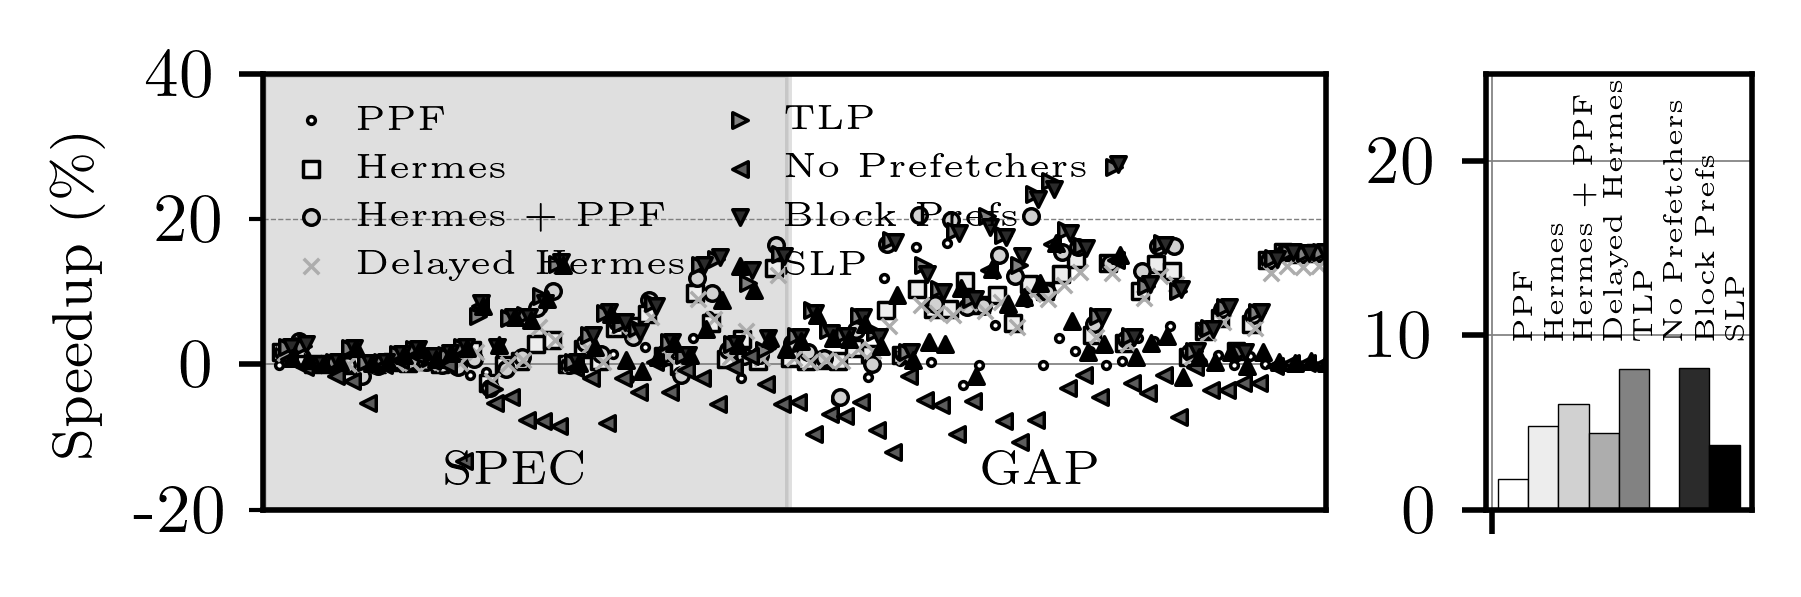

In [101]:
markers = ['.', 's', 'o', 'x', '>', '<', 'v', '^', 'h', 'D']

# Here is the actual plotting material.
fig_hermes_o_speedup = plt.figure(
    constrained_layout=True, figsize=set_size(fig_width), dpi=500)
fig_hermes_o_speedup.tight_layout(pad=0)
gs = GridSpec(1, 5, figure=fig_hermes_o_speedup)

ax_hermes_o_speedup, ax_hermes_o_gmean = fig_hermes_o_speedup.add_subplot(
    gs[0, :4]), fig_hermes_o_speedup.add_subplot(gs[0, 4:])
ax_hermes_o_speedup.margins(x=0, tight=True)

xticklabels = df_speedup_hermes_o.index.tolist()
xticklabels = [sub_re_trailing_sdc.sub(repl='', string=e) for e in xticklabels]
xticklabels = [sub_re_trailing_und.sub(
    repl=r'\_', string=e) for e in xticklabels]

key_list = df_speedup_hermes_o.columns.to_list()
# key_list = ['hermes_o_pc_based', 'popet_o', 'hermes_o_perceptron_pc_pfn']

cat_spacing = 0.05
bar_width, index = (1 - cat_spacing) / \
    len(key_list), np.arange(1, len(xticklabels) + 1)

colors = cm.get_cmap(plot_cmp)(np.linspace(
    0.0, 1.0, len(key_list), endpoint=True))

# for i, (e, c) in enumerate(zip(key_list, colors)):
#     ax_hermes_o_speedup.bar(index + i * (bar_width) + (cat_spacing / 2),
#                     df_speedup_hermes_o[e], width=bar_width, edgecolor='black', linewidth=0.2, align='edge', label=labels_dict[e], color=c)
for i, (e, c, m) in enumerate(zip(key_list, colors, markers)):
    ax_hermes_o_speedup.scatter(index + i * (bar_width) + (cat_spacing / 2),
                                df_speedup_hermes_o[e],
                                s=5,
                                marker=m,
                                edgecolor='black',
                                linewidths=0.5,
                                # width=bar_width, edgecolor='black', linewidth=0.2, align='edge',
                                label=labels_dict[e], color=c)

# Annotating the benchmark suites on the plots.
ax_hermes_o_speedup.annotate(
    'SPEC', (len(spec_keys) / 2, -15), ha='center', va='center', size=7)
ax_hermes_o_speedup.annotate('GAP', (len(
    spec_keys) + len(gapbs_keys) / 2, -15), ha='center', va='center', size=7)

ax_hermes_o_speedup.axvspan(xmin=0, xmax=len(
    spec_keys) + 1, color='grey', alpha=0.25, zorder=-1)

ax_hermes_o_speedup.set_xticks(index)
# ax_hermes_o_speedup.set_xticklabels(xticklabels, rotation=90, fontsize=5)
ax_hermes_o_speedup.set_xticklabels([])
ax_hermes_o_speedup.grid(
    color='grey', linestyle='-', linewidth=0.25, axis='y')
ax_hermes_o_speedup.grid(True, which='minor', color='grey',
                         linestyle='--', linewidth=0.2, axis='y')
ax_hermes_o_speedup.set_axisbelow(True)

ax_hermes_o_speedup.set_ylabel(r'Speedup (\%)', fontsize=8)

ax_hermes_o_speedup.tick_params(axis='both')
ax_hermes_o_speedup.tick_params(labeltop=False)
ax_hermes_o_speedup.tick_params(axis='x',
                                which='both',
                                bottom=False,
                                top=False)

ax_hermes_o_speedup.set_ylim([-20.0, 40.0])

ax_hermes_o_speedup.yaxis.set_major_locator(MultipleLocator(40))
ax_hermes_o_speedup.yaxis.set_major_formatter('{x:.0f}')
ax_hermes_o_speedup.yaxis.set_minor_locator(MultipleLocator(20))
ax_hermes_o_speedup.yaxis.set_minor_formatter('{x:.0f}')

for tick in ax_hermes_o_speedup.xaxis.get_major_ticks():
    tick.label1.set_horizontalalignment('left')

ax_hermes_o_speedup.legend(loc='upper left', edgecolor='white', fancybox=False, framealpha=0.0, ncol=2,
                           fontsize=5
                           )

# Working on the second subplot that will contain the mean for each benchmark suite.
xticklabels = gmean_keys
bar_width, index = (1 - cat_spacing) / \
    len(key_list), np.arange(1, len(xticklabels) + 1)

for i, (e, c) in enumerate(zip(key_list, colors)):
    ax_hermes_o_gmean.bar(index + i * bar_width + cat_spacing / 2,
                          df_speedup_gmean[e], width=bar_width, linewidth=0.2, edgecolor='black', align='edge', label=labels_dict[e], color=c)
    
for b, k in zip(ax_hermes_o_gmean.patches, key_list):
    print(k)
    ax_hermes_o_gmean.annotate(labels_dict[k], (b.get_x() + b.get_width() / 2, 10), size=4, rotation=90,
                            #    ha='center',
                               # va='center',
                               # xytext=(0, 10), textcoords='offset points'
                               )

ax_hermes_o_gmean.set_xticks(index)
ax_hermes_o_gmean.set_xticklabels([])
# ax_hermes_o_gmean.bar_label(ax_hermes_o_gmean.containers[-1], labels=gmean_keys, label_type='edge', rotation=90, fontsize=5, padding=3)
ax_hermes_o_gmean.set_ylim([0.0, 25.0])
ax_hermes_o_gmean.grid(
    color='grey', linestyle='-', linewidth=0.25)
ax_hermes_o_gmean.set_axisbelow(True)

plt.savefig('12_HPCA30_Paper/plots/evaluation/single_core_berti_evaluation_speedup_alt.pdf',
            format='pdf', dpi='figure')
plt.savefig('12_HPCA30_Paper/plots/evaluation/single_core_berti_evaluation_speedup_alt.png',
            format='png', dpi='figure')


In [102]:
res_sets, res_keys = [final_res_set_spec,
                      final_res_set_gapbs], [spec_keys, gapbs_keys]
dram_trans_pref_list, dram_trans_list, dram_trans_all_keys = [], [], []

# for set, keys in zip(res_sets, res_keys):
#     # dram_trans_pref_list.extend([set[0].sets[0][k]['dram']['transactions'] /
#     #                        set[-1].sets[0][k]['dram']['transactions'] for k in keys])
#     dram_trans_list.extend([set[0].sets[0][k]['dram']['transactions'] /
#                            set[-1].sets[0][k]['dram']['transactions'] for k in keys])

#     # Adding keys to the list.
#     dram_trans_all_keys.extend(keys)

# dict_dram_trans = {
#     # 'baseline_cascade_lake_ipcp': dram_trans_pref_list,
#     'baseline_cascade_lake_ipcp_hermes_o': dram_trans_list,
# }

dict_dram_trans = {
    # 'baseline_cascade_lake_double_l1d': [],
    'baseline_cascade_lake_spp_ppf': [],
    'baseline_cascade_lake_hermes_o': [],
    'baseline_cascade_lake_berti_spp_ppf_hermes_o': [],
    # 'baseline_cascade_lake_berti_delayed_hermes_o': [],
    # 'baseline_cascade_lake_l1d_filtered_prefetcher': [],
    # 'baseline_cascade_lake_berti_delayed_tlp': [],

    # 'baseline_cascade_lake_berti_tlp_core_l1d_-15_-35_bis': [],
    # 'baseline_cascade_lake_berti_tlp_layered_core_l1d': [],
    'baseline_cascade_lake_berti_tlp_layered_core_l1d_f20_-25': [],
    # 'baseline_cascade_lake_berti_hermes_o_double': [],
    # 'baseline_cascade_lake_no_prefetchers': [],
}

for set, keys in zip(res_sets, res_keys):
    # speedup_pref_list.extend([set[0].sets[0][k]['speedup'] for k in keys])
    # dict_dram_trans['baseline_cascade_lake_double_l1d'].extend([set[1].sets[0][k]['dram']['transactions'] / set[-1].sets[0][k]['dram']['transactions'] for k in keys])
    dict_dram_trans['baseline_cascade_lake_spp_ppf'].extend(
        [set[3].sets[0][k]['dram']['transactions'] / set[-1].sets[0][k]['dram']['transactions'] for k in keys])
    dict_dram_trans['baseline_cascade_lake_hermes_o'].extend(
        [set[2].sets[0][k]['dram']['transactions'] / set[-1].sets[0][k]['dram']['transactions'] for k in keys])
    dict_dram_trans['baseline_cascade_lake_berti_spp_ppf_hermes_o'].extend(
        [set[9].sets[0][k]['dram']['transactions'] / set[-1].sets[0][k]['dram']['transactions'] for k in keys])
    # dict_dram_trans['baseline_cascade_lake_l1d_filtered_prefetcher'].extend([set[0].sets[0][k]['dram']['transactions'] / set[-1].sets[0][k]['dram']['transactions'] for k in keys])
    # dict_dram_trans['baseline_cascade_lake_berti_delayed_hermes_o'].extend([set[6].sets[0][k]['dram']['transactions'] / set[-1].sets[0][k]['dram']['transactions'] for k in keys])
    # dict_dram_trans['baseline_cascade_lake_berti_delayed_tlp'].extend([set[7].sets[0][k]['dram']['transactions'] / set[-1].sets[0][k]['dram']['transactions'] for k in keys])

    # dict_dram_trans['baseline_cascade_lake_berti_tlp_core_l1d_-15_-35_bis'].extend([set[4].sets[0][k]['dram']['transactions'] / set[-1].sets[0][k]['dram']['transactions'] for k in keys])
    # dict_dram_trans['baseline_cascade_lake_berti_tlp_layered_core_l1d'].extend([set[8].sets[0][k]['dram']['transactions'] / set[-1].sets[0][k]['dram']['transactions'] for k in keys])
    dict_dram_trans['baseline_cascade_lake_berti_tlp_layered_core_l1d_f20_-25'].extend(
        [set[5].sets[0][k]['dram']['transactions'] / set[-1].sets[0][k]['dram']['transactions'] for k in keys])
    # dict_dram_trans['baseline_cascade_lake_berti_hermes_o_double'].extend(
    #     [set[11].sets[0][k]['dram']['transactions'] / set[-1].sets[0][k]['dram']['transactions'] for k in keys])
    # dict_dram_trans['baseline_cascade_lake_no_prefetchers'].extend(
    #     [set[12].sets[0][k]['dram']['transactions'] / set[-1].sets[0][k]['dram']['transactions'] for k in keys])

    # Adding keys to the list.
    dram_trans_all_keys.extend(keys)

# for k, v in dict_dram_trans.items():
#     dict_dram_trans[k] = sorted(v)

df_dram_trans = pandas.DataFrame(
    dict_dram_trans, columns=dict_dram_trans.keys(), index=dram_trans_all_keys)

df_dram_trans -= 1.0
df_dram_trans *= 100.0

# df_tmp = df_dram_trans[df_dram_trans.index != 'mean'].sort_values(
#     by=df_dram_trans.columns.to_list()[0], axis='rows', inplace=False)
# df_dram_trans = df_tmp

# # Sorting by geomean speed-up.
# df_dram_trans.sort_values(
#     by='mean', axis='columns', inplace=True, ascending=True)
# df_tmp = df_dram_trans[df_dram_trans.index != 'mean'].sort_values(
#     by=df_dram_trans.columns.to_list()[0], axis='rows', inplace=False)
# df_dram_trans = pandas.concat(
#     [df_tmp, df_dram_trans[df_dram_trans.index == 'mean']])

# Creating a DataFrame containing the means for the different benchmark suites.
dram_trans_pref_mean_list, dram_trans_mean_list, mean_keys = [s[0].sets[0]['mean']['dram']['transactions'] / s[-1].sets[0]['mean']['dram']['transactions'] for s in [*res_sets, final_res_set_all]], \
    [s[0].sets[0]['mean']['dram']['transactions'] / s[-1].sets[0]['mean']['dram']['transactions']
     for s in [*res_sets, final_res_set_all]], ['ALL']

df_dram_trans_mean = pandas.DataFrame({
    # 'baseline_cascade_lake_ipcp': dram_trans_pref_mean_list,
    # 'baseline_cascade_lake_double_l1d': [s[1].sets[0]['mean']['dram']['transactions'] / s[-1].sets[0]['mean']['dram']['transactions'] for s in [*res_sets, final_res_set_all]],
    'baseline_cascade_lake_spp_ppf': np.nanmean(df_dram_trans['baseline_cascade_lake_spp_ppf']),
    'baseline_cascade_lake_hermes_o': np.nanmean(df_dram_trans['baseline_cascade_lake_hermes_o']),
    'baseline_cascade_lake_berti_spp_ppf_hermes_o': np.nanmean(df_dram_trans['baseline_cascade_lake_berti_spp_ppf_hermes_o']),
    # 'baseline_cascade_lake_berti_delayed_hermes_o': np.nanmean(df_dram_trans['baseline_cascade_lake_berti_delayed_hermes_o']),
    # 'baseline_cascade_lake_l1d_filtered_prefetcher': [s[0].sets[0]['mean']['dram']['transactions'] / s[-1].sets[0]['mean']['dram']['transactions'] for s in [*res_sets, final_res_set_all]],
    # 'baseline_cascade_lake_berti_delayed_tlp': [s[7].sets[0]['mean']['dram']['transactions'] / s[-1].sets[0]['mean']['dram']['transactions'] for s in [*res_sets, final_res_set_all]],

    # 'baseline_cascade_lake_berti_tlp_core_l1d_-15_-35_bis': [s[4].sets[0]['mean']['dram']['transactions'] / s[-1].sets[0]['mean']['dram']['transactions'] for s in [*res_sets, final_res_set_all]],
    # 'baseline_cascade_lake_berti_tlp_layered_core_l1d': [s[8].sets[0]['mean']['dram']['transactions'] / s[-1].sets[0]['mean']['dram']['transactions'] for s in [*res_sets, final_res_set_all]],
    'baseline_cascade_lake_berti_tlp_layered_core_l1d_f20_-25': np.nanmean(df_dram_trans['baseline_cascade_lake_berti_tlp_layered_core_l1d_f20_-25']),
    # 'baseline_cascade_lake_berti_hermes_o_double': np.nanmean(df_dram_trans['baseline_cascade_lake_berti_hermes_o_double']),
    # 'baseline_cascade_lake_no_prefetchers': np.nanmean(df_dram_trans['baseline_cascade_lake_no_prefetchers']),
}, index=mean_keys)

# df_dram_trans_mean -= 1.0
# df_dram_trans_mean *= 100.0
# del(df_tmp)

# Concatenating the 50 highest values with the means per benchmark suites.
# df_dram_trans = pandas.concat([df_tmp, df_dram_trans_mean])

display(np.nanmean(df_dram_trans['baseline_cascade_lake_spp_ppf']))
display(df_dram_trans_mean)


8.827281383417407

,baseline_cascade_lake_spp_ppf,baseline_cascade_lake_hermes_o,baseline_cascade_lake_berti_spp_ppf_hermes_o,baseline_cascade_lake_berti_tlp_layered_core_l1d_f20_-25
ALL,8.827281,9.559101,16.908965,-14.221654


/tmp/ipykernel_13252/429808715.py:32: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax_hermes_o_dram_trans.scatter(index + i * (bar_width) + (cat_spacing / 2),


baseline_cascade_lake_spp_ppf
baseline_cascade_lake_hermes_o
baseline_cascade_lake_berti_spp_ppf_hermes_o
baseline_cascade_lake_berti_tlp_layered_core_l1d_f20_-25


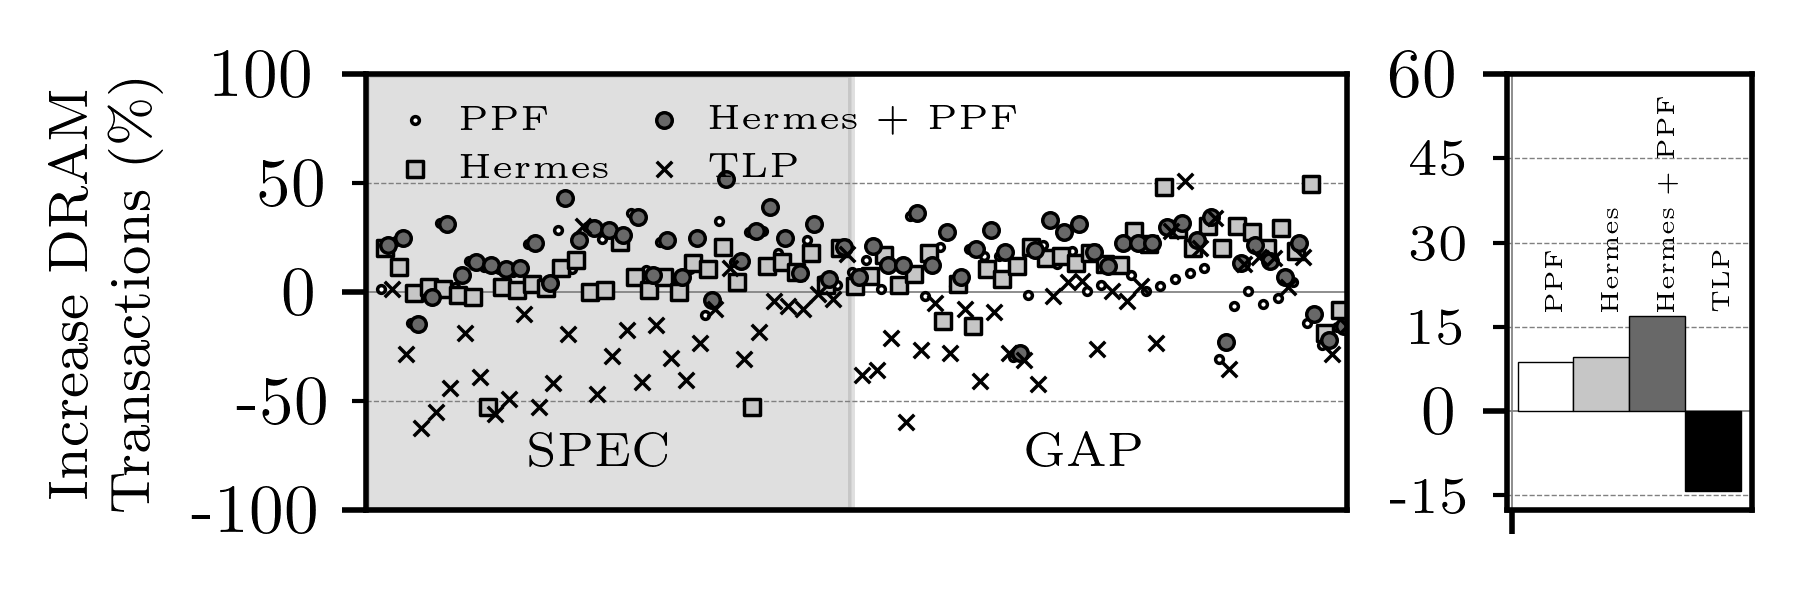

In [103]:
markers = ['.', 's', 'o', 'x', '>', '<', 'v', '^', 'h', 'D']

# Here is the actual plotting material.
fig_hermes_o_dram_trans = plt.figure(
    constrained_layout=True, figsize=set_size(fig_width), dpi=500)
fig_hermes_o_dram_trans.tight_layout(pad=0)
gs = GridSpec(1, 5, figure=fig_hermes_o_dram_trans)

ax_hermes_o_dram_trans, ax_hermes_o_dram_trans_mean = fig_hermes_o_dram_trans.add_subplot(
    gs[0, :4]), fig_hermes_o_dram_trans.add_subplot(gs[0, 4:])
ax_hermes_o_dram_trans.margins(x=0, tight=True)

xticklabels = df_dram_trans.index.tolist()
xticklabels = [sub_re_trailing_sdc.sub(repl='', string=e) for e in xticklabels]
xticklabels = [sub_re_trailing_und.sub(
    repl=r'\_', string=e) for e in xticklabels]

key_list = df_dram_trans.columns.to_list()
# key_list = ['hermes_o_pc_based', 'popet_o', 'hermes_o_perceptron_pc_pfn']

cat_spacing = 0.05
bar_width, index = (1 - cat_spacing) / \
    len(key_list), np.arange(1, len(xticklabels) + 1)

colors = cm.get_cmap(plot_cmp)(np.linspace(
    0.0, 1.0, len(key_list), endpoint=True))

# for i, (e, c) in enumerate(zip(key_list, colors)):
#     ax_hermes_o_dram_trans.bar(index + i * (bar_width) + (cat_spacing / 2),
#                     df_speedup_hermes_o[e], width=bar_width, edgecolor='black', linewidth=0.2, align='edge', label=labels_dict[e], color=c)
for i, (e, c, m) in enumerate(zip(key_list, colors, markers)):
    ax_hermes_o_dram_trans.scatter(index + i * (bar_width) + (cat_spacing / 2),
                                   df_dram_trans[e],
                                   s=5,
                                   marker=m,
                                   edgecolor='black',
                                   linewidths=0.5,
                                   # width=bar_width, edgecolor='black', linewidth=0.2, align='edge',
                                   label=labels_dict[e], color=c)

ax_hermes_o_dram_trans.axvspan(xmin=0, xmax=len(
    spec_keys) + 1, color='grey', alpha=0.25, zorder=-1)

# Annotating the benchmark suites on the plots.
ax_hermes_o_dram_trans.annotate(
    'SPEC', (len(spec_keys) / 2, -75), ha='center', va='center', size=7)
ax_hermes_o_dram_trans.annotate('GAP', (len(
    spec_keys) + len(gapbs_keys) / 2, -75), ha='center', va='center', size=7)

ax_hermes_o_dram_trans.set_xticks(index)
# ax_hermes_o_dram_trans.set_xticklabels(xticklabels, rotation=90, fontsize=5)
ax_hermes_o_dram_trans.set_xticklabels([])
ax_hermes_o_dram_trans.grid(
    color='grey', linestyle='-', linewidth=0.25, axis='y')
ax_hermes_o_dram_trans.grid(True, which='minor', color='grey',
                            linestyle='--', linewidth=0.2, axis='y')
ax_hermes_o_dram_trans.set_axisbelow(True)

ax_hermes_o_dram_trans.set_ylabel(
    'Increase DRAM\nTransactions (\%)', fontsize=8)

ax_hermes_o_dram_trans.tick_params(axis='both')
ax_hermes_o_dram_trans.tick_params(labeltop=False)
ax_hermes_o_dram_trans.tick_params(axis='x',
                                   which='both',
                                   bottom=False,
                                   top=False)

ax_hermes_o_dram_trans.set_ylim([-100.0, 100.0])

ax_hermes_o_dram_trans.yaxis.set_major_locator(MultipleLocator(100))
ax_hermes_o_dram_trans.yaxis.set_major_formatter('{x:.0f}')
ax_hermes_o_dram_trans.yaxis.set_minor_locator(MultipleLocator(50))
ax_hermes_o_dram_trans.yaxis.set_minor_formatter('{x:.0f}')

for tick in ax_hermes_o_dram_trans.xaxis.get_major_ticks():
    tick.label1.set_horizontalalignment('left')

ax_hermes_o_dram_trans.legend(loc='upper left', edgecolor='white', fancybox=False, framealpha=0.0, ncol=2,
                              fontsize=5
                              )

# Working on the second subplot that will contain the mean for each benchmark suite.
xticklabels = mean_keys
bar_width, index = (1 - cat_spacing) / \
    len(key_list), np.arange(1, len(xticklabels) + 1)

for i, (e, c) in enumerate(zip(key_list, colors)):
    ax_hermes_o_dram_trans_mean.bar(index + i * bar_width + cat_spacing / 2,
                                    df_dram_trans_mean[e], width=bar_width, linewidth=0.2, edgecolor='black', align='edge', label=labels_dict[e], color=c)

for b, k in zip(ax_hermes_o_dram_trans_mean.patches, key_list):
    print(k)
    ax_hermes_o_dram_trans_mean.annotate(labels_dict[k], (b.get_x() + b.get_width() / 2, 18.5), size=3.5, rotation=90,
                                         #    ha='center',
                                         # va='center',
                                         # xytext=(0, 10), textcoords='offset points'
                                         )

ax_hermes_o_dram_trans_mean.set_xticks(index)
ax_hermes_o_dram_trans_mean.set_xticklabels([])
# ax_hermes_o_dram_trans_mean.bar_label(ax_hermes_o_dram_trans_mean.containers[1], labels=gmean_keys, label_type='edge', rotation=90, fontsize=5, padding=3)
ax_hermes_o_dram_trans_mean.set_ylim([-17.5, 60.0])
ax_hermes_o_dram_trans_mean.grid(
    color='grey', linestyle='-', linewidth=0.25)
ax_hermes_o_dram_trans_mean.grid(True, which='minor', color='grey',
                            linestyle='--', linewidth=0.2, axis='y')
ax_hermes_o_dram_trans_mean.set_axisbelow(True)
ax_hermes_o_dram_trans_mean.set_axisbelow(True)
ax_hermes_o_dram_trans_mean.tick_params(axis='y', which='minor', labelsize=7.5)

ax_hermes_o_dram_trans_mean.yaxis.set_major_locator(MultipleLocator(60))
ax_hermes_o_dram_trans_mean.yaxis.set_major_formatter('{x:.0f}')
ax_hermes_o_dram_trans_mean.yaxis.set_minor_locator(MultipleLocator(15))
ax_hermes_o_dram_trans_mean.yaxis.set_minor_formatter('{x:.0f}')

plt.savefig('12_HPCA30_Paper/plots/evaluation/single_core_berti_evaluation_dram_transactions_alt.pdf',
            format='pdf', dpi='figure')
plt.savefig('12_HPCA30_Paper/plots/evaluation/single_core_berti_evaluation_dram_transactions_alt.png',
            format='png', dpi='figure')


In [104]:
dict_l1d_accuracy = {
    # 'baseline_cascade_lake': [s[-1].sets[0]['mean']['l1d_prefetcher']['accuracy'] for s in workload_sets],
    'baseline_cascade_lake_spp_ppf': [s[1].sets[0]['mean']['l1d_prefetcher']['accuracy'] for s in workload_sets],
    'baseline_cascade_lake_hermes_o': [s[2].sets[0]['mean']['l1d_prefetcher']['accuracy'] for s in workload_sets],
    'baseline_cascade_lake_berti_spp_ppf_hermes_o': [s[9].sets[0]['mean']['l1d_prefetcher']['accuracy'] for s in workload_sets],
    # 'baseline_cascade_lake_l1d_filtered_prefetcher': [s[3].sets[0]['mean']['l1d_prefetcher']['accuracy'] for s in workload_sets],
    # 'baseline_cascade_lake_berti_tlp_layered_core_l1d': [s[8].sets[0]['mean']['l1d_prefetcher']['accuracy'] for s in workload_sets],
    'baseline_cascade_lake_berti_tlp_layered_core_l1d_f20_-25': [s[5].sets[0]['mean']['l1d_prefetcher']['accuracy'] for s in workload_sets],
    # 'baseline_cascade_lake_hermes_o_no_l1d_prefetcher': [(s[6].sets[0]['geomean']['speedup'] - 1.0) * 100.0 for s in speedup_all_keys],
}

df_l1d_accuracy = pandas.DataFrame(
    dict_l1d_accuracy, columns=dict_l1d_accuracy.keys(), index=['SPEC', 'GAP', 'ALL'])

df_l1d_accuracy *= 100.0

# # Sorting by geomean speed-up.
# df_l1d_accuracy.sort_values(
#     by='geomean', axis='columns', inplace=True)
# df_tmp = df_l1d_accuracy[df_l1d_accuracy.index != 'geomean'].sort_values(
#     by=df_l1d_accuracy.columns.to_list()[-1], axis='rows', inplace=False)
# df_l1d_accuracy = pandas.concat(
#     [df_tmp, df_l1d_accuracy[df_l1d_accuracy.index == 'geomean']])

display(df_l1d_accuracy)


,baseline_cascade_lake_spp_ppf,baseline_cascade_lake_hermes_o,baseline_cascade_lake_berti_spp_ppf_hermes_o,baseline_cascade_lake_berti_tlp_layered_core_l1d_f20_-25
SPEC,21.734676,19.500506,17.240698,33.192839
GAP,23.101891,23.419143,18.570216,45.009013
ALL,22.438999,21.519198,17.925601,39.279959


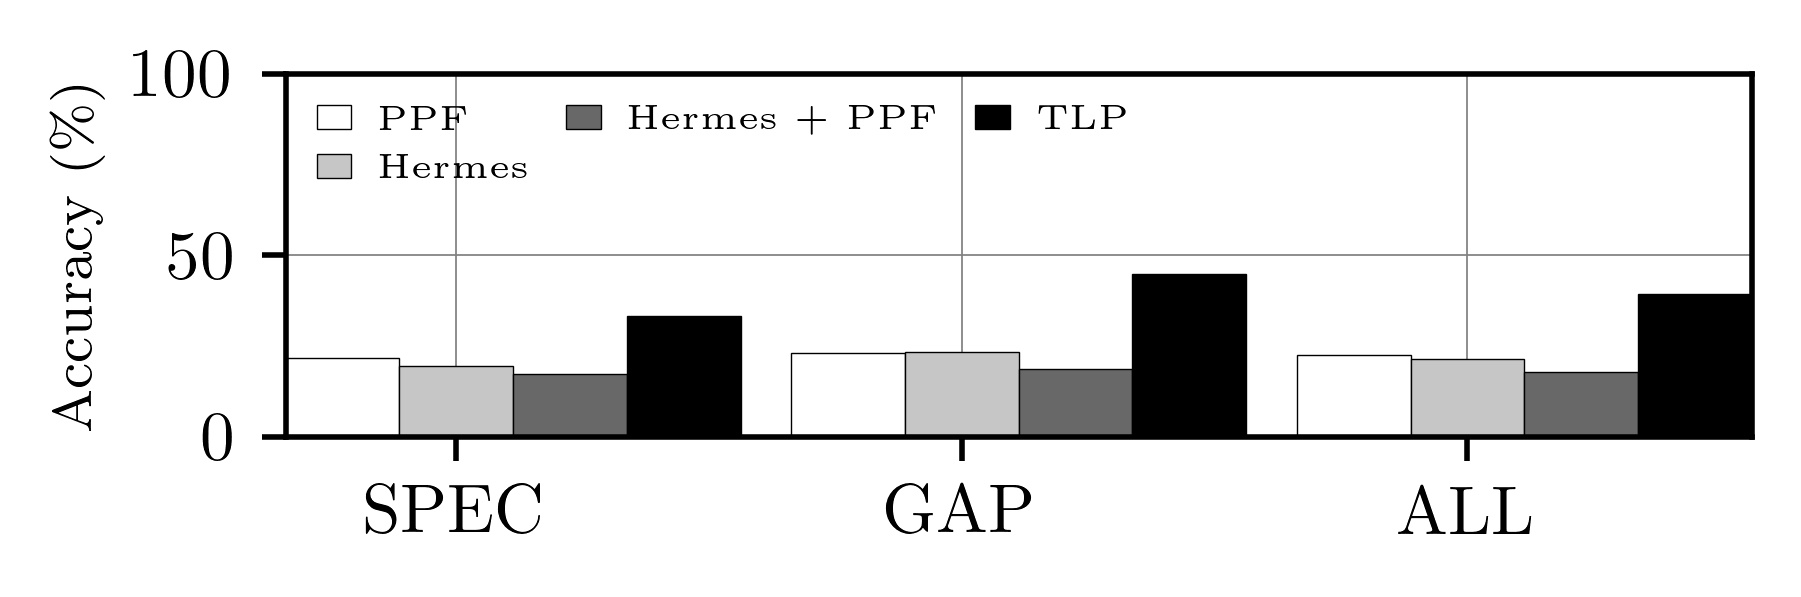

In [105]:
# Here is the actual plotting material.
fig_l1d_pref_accuracy = plt.figure(
    constrained_layout=True, figsize=set_size(fig_width), dpi=500)
fig_l1d_pref_accuracy.tight_layout(pad=0)
gs = GridSpec(1, 1, figure=fig_l1d_pref_accuracy)

fig_l1d_pref_accuracy = fig_l1d_pref_accuracy.add_subplot(
    gs[:])
fig_l1d_pref_accuracy.margins(x=0, tight=True)

xticklabels = df_l1d_accuracy.index.tolist()
xticklabels = [sub_re_trailing_sdc.sub(repl='', string=e) for e in xticklabels]
xticklabels = [sub_re_trailing_und.sub(
    repl=r'\_', string=e) for e in xticklabels]

key_list = df_l1d_accuracy.columns.to_list()
# key_list = ['hermes_o_pc_based_2k_entries', 'hermes_o_pc_based', 'popet_o', 'hermes_o_perfect']

cat_spacing = 0.1
bar_width, index = (1 - cat_spacing) / \
    len(key_list), np.arange(1, len(xticklabels) + 1)

colors = cm.get_cmap(plot_cmp)(np.linspace(
    0.0, 1.0, len(key_list), endpoint=True))

for i, (e, c) in enumerate(zip(key_list, colors)):
    fig_l1d_pref_accuracy.bar(index + (i - 1) * (bar_width),
                              df_l1d_accuracy[e], width=bar_width, edgecolor='black', linewidth=0.2, align='center', label=labels_dict[e], color=c)

fig_l1d_pref_accuracy.set_xticks(index)
fig_l1d_pref_accuracy.set_xticklabels(xticklabels, rotation=0)
# fig_l1d_pref_accuracy.set_xticklabels([])
fig_l1d_pref_accuracy.grid(
    color='grey', linestyle='-', linewidth=0.25)
fig_l1d_pref_accuracy.set_axisbelow(True)

fig_l1d_pref_accuracy.set_ylabel(r'Accuracy (\%)')

fig_l1d_pref_accuracy.tick_params(axis='both')
fig_l1d_pref_accuracy.tick_params(labeltop=False)

fig_l1d_pref_accuracy.set_ylim([0, 100.0])

fig_l1d_pref_accuracy.legend(loc='upper left', edgecolor='white', fancybox=False, framealpha=0.0,
                             ncol=3,
                             fontsize=5,
                             #    labelspacing=1.0,
                             #    bbox_to_anchor=(0, 0.925, 1, 0.25),
                             #    mode='expand'
                             )

for tick in fig_l1d_pref_accuracy.xaxis.get_major_ticks():
    tick.label1.set_horizontalalignment('center')

plt.savefig('12_HPCA30_Paper/plots/evaluation/single_core_berti_evaluation_l1d_prefetcher_accuracy.pdf',
            format='pdf', dpi='figure')
plt.savefig('12_HPCA30_Paper/plots/evaluation/single_core_berti_evaluation_l1d_prefetcher_accuracy.png',
            format='png', dpi='figure')


In [106]:
dict_l1d_coverage = {
    # 'baseline_cascade_lake': [s[-1].sets[0]['mean']['l1d_misses']['accuracy'] for s in workload_sets],
    # 'baseline_cascade_lake_berti': [s[-1].sets[0]['mean']['llc_mpki'] / s[-1].sets[0]['mean']['llc_mpki'] for s in workload_sets],
    'baseline_cascade_lake_spp_ppf': [s[1].sets[0]['mean']['llc_mpki'] / s[-1].sets[0]['mean']['llc_mpki'] for s in workload_sets],
    'baseline_cascade_lake_hermes_o': [s[2].sets[0]['mean']['llc_mpki'] / s[-1].sets[0]['mean']['llc_mpki'] for s in workload_sets],
    'baseline_cascade_lake_berti_spp_ppf_hermes_o': [s[9].sets[0]['mean']['llc_mpki'] / s[-1].sets[0]['mean']['llc_mpki'] for s in workload_sets],
    # 'baseline_cascade_lake_l1d_filtered_prefetcher': [s[3].sets[0]['mean']['l1d_misses']['accuracy'] for s in workload_sets],
    # 'baseline_cascade_lake_berti_tlp_layered_core_l1d': [s[8].sets[0]['mean']['l1d_misses']['accuracy'] for s in workload_sets],
    'baseline_cascade_lake_berti_tlp_layered_core_l1d_f20_-25': [s[5].sets[0]['mean']['llc_mpki'] / s[-1].sets[0]['mean']['llc_mpki'] for s in workload_sets],
    # 'baseline_cascade_lake_hermes_o_no_llc_mpki': [(s[6].sets[0]['geomean']['speedup'] - 1.0) * 100.0 for s in speedup_all_keys],
}

df_l1d_coverage = pandas.DataFrame(
    dict_l1d_coverage, columns=dict_l1d_coverage.keys(), index=['SPEC', 'GAP', 'ALL'])

df_l1d_coverage = 1.0 - df_l1d_coverage
df_l1d_coverage *= 100.0

# # Sorting by geomean speed-up.
# df_l1d_coverage.sort_values(
#     by='geomean', axis='columns', inplace=True)
# df_tmp = df_l1d_coverage[df_l1d_coverage.index != 'geomean'].sort_values(
#     by=df_l1d_coverage.columns.to_list()[-1], axis='rows', inplace=False)
# df_l1d_coverage = pandas.concat(
#     [df_tmp, df_l1d_coverage[df_l1d_coverage.index == 'geomean']])

display(df_l1d_coverage)

,baseline_cascade_lake_spp_ppf,baseline_cascade_lake_hermes_o,baseline_cascade_lake_berti_spp_ppf_hermes_o,baseline_cascade_lake_berti_tlp_layered_core_l1d_f20_-25
SPEC,0.425932,-0.254374,21.980643,17.871988
GAP,0.048393,-0.258067,2.339098,5.274991
ALL,0.109522,-0.257469,5.519340,7.314622


In [107]:
dict_llc_mpki = {
    # 'baseline_cascade_lake': [s[-1].sets[0]['mean']['l1d_misses']['accuracy'] for s in workload_sets],
    'baseline_cascade_lake_ipcp': [s[-1].sets[0]['mean']['llc_mpki'] for s in workload_sets],
    'baseline_cascade_lake_spp_ppf': [s[1].sets[0]['mean']['llc_mpki'] for s in workload_sets],
    'baseline_cascade_lake_hermes_o': [s[2].sets[0]['mean']['llc_mpki'] for s in workload_sets],
    'baseline_cascade_lake_ipcp_spp_ppf_hermes_o': [s[9].sets[0]['mean']['llc_mpki'] for s in workload_sets],
    # 'baseline_cascade_lake_l1d_filtered_prefetcher': [s[3].sets[0]['mean']['l1d_misses']['accuracy'] for s in workload_sets],
    # 'baseline_cascade_lake_ipcp_tlp_layered_core_l1d': [s[8].sets[0]['mean']['l1d_misses']['accuracy'] for s in workload_sets],
    'baseline_cascade_lake_ipcp_tlp_layered_core_l1d_f20_-25': [s[5].sets[0]['mean']['llc_mpki'] for s in workload_sets],
    # 'baseline_cascade_lake_hermes_o_no_llc_mpki': [(s[6].sets[0]['geomean']['speedup'] - 1.0) * 100.0 for s in speedup_all_keys],
}

df_llc_mpki = pandas.DataFrame(
    dict_llc_mpki, columns=dict_llc_mpki.keys(), index=['SPEC', 'GAP', 'ALL'])

display(df_llc_mpki)

,baseline_cascade_lake_ipcp,baseline_cascade_lake_spp_ppf,baseline_cascade_lake_hermes_o,baseline_cascade_lake_ipcp_spp_ppf_hermes_o,baseline_cascade_lake_ipcp_tlp_layered_core_l1d_f20_-25
SPEC,9.450421,9.410169,9.474461,7.373158,7.761443
GAP,46.039036,46.016756,46.157847,44.962138,43.610481
ALL,28.299101,28.268108,28.371963,26.737178,26.229129


In [108]:
dict_llc_mpki = {
    # 'baseline_cascade_lake': [s[-1].sets[0]['mean']['l1d_misses']['accuracy'] for s in workload_sets],
    'baseline_cascade_lake_ipcp': [s[17].sets[0]['mean']['llc_mpki'] for s in workload_sets],
    'baseline_cascade_lake_spp_ppf': [s[13].sets[0]['mean']['llc_mpki'] for s in workload_sets],
    'baseline_cascade_lake_hermes_o': [s[14].sets[0]['mean']['llc_mpki'] for s in workload_sets],
    'baseline_cascade_lake_ipcp_spp_ppf_hermes_o': [s[15].sets[0]['mean']['llc_mpki'] for s in workload_sets],
    # 'baseline_cascade_lake_l1d_filtered_prefetcher': [s[3].sets[0]['mean']['l1d_misses']['accuracy'] for s in workload_sets],
    # 'baseline_cascade_lake_ipcp_tlp_layered_core_l1d': [s[8].sets[0]['mean']['l1d_misses']['accuracy'] for s in workload_sets],
    'baseline_cascade_lake_ipcp_tlp_layered_core_l1d_f20_-25': [s[16].sets[0]['mean']['llc_mpki'] for s in workload_sets],
    # 'baseline_cascade_lake_hermes_o_no_llc_mpki': [(s[6].sets[0]['geomean']['speedup'] - 1.0) * 100.0 for s in speedup_all_keys],
}

df_llc_mpki = pandas.DataFrame(
    dict_llc_mpki, columns=dict_llc_mpki.keys(), index=['SPEC', 'GAP', 'ALL'])

display(df_llc_mpki)

,baseline_cascade_lake_ipcp,baseline_cascade_lake_spp_ppf,baseline_cascade_lake_hermes_o,baseline_cascade_lake_ipcp_spp_ppf_hermes_o,baseline_cascade_lake_ipcp_tlp_layered_core_l1d_f20_-25
SPEC,7.483972,7.809201,7.479847,7.765772,7.481298
GAP,43.528782,45.034135,43.536691,45.017612,43.538875
ALL,26.052510,26.985682,26.054584,26.956113,26.056413


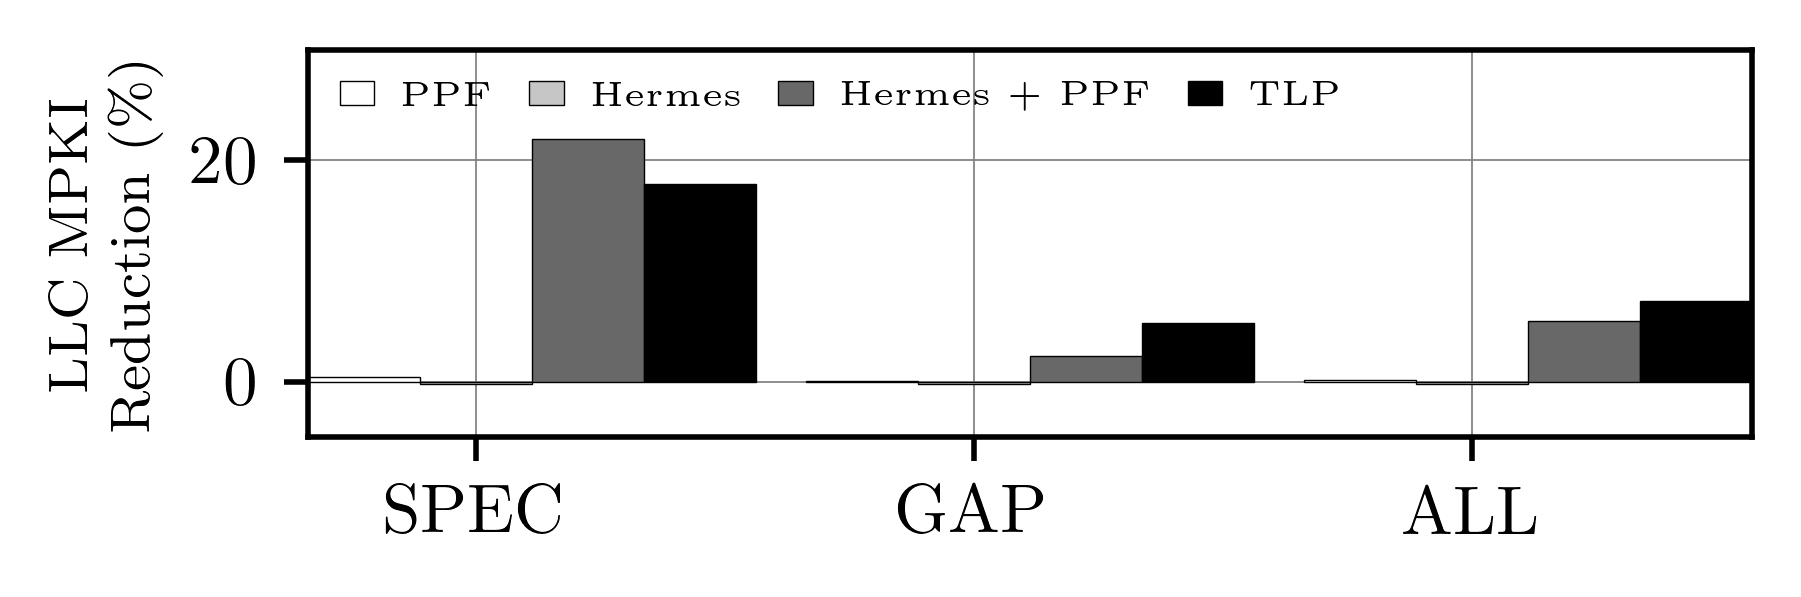

In [109]:
# Here is the actual plotting material.
fig_l1d_pref_coverage = plt.figure(
    constrained_layout=True, figsize=set_size(fig_width), dpi=500)
fig_l1d_pref_coverage.tight_layout(pad=0)
gs = GridSpec(1, 1, figure=fig_l1d_pref_coverage)

fig_l1d_pref_coverage = fig_l1d_pref_coverage.add_subplot(
    gs[:])
fig_l1d_pref_coverage.margins(x=0, tight=True)

xticklabels = df_l1d_coverage.index.tolist()
xticklabels = [sub_re_trailing_sdc.sub(repl='', string=e) for e in xticklabels]
xticklabels = [sub_re_trailing_und.sub(
    repl=r'\_', string=e) for e in xticklabels]

key_list = df_l1d_coverage.columns.to_list()
# key_list = ['hermes_o_pc_based_2k_entries', 'hermes_o_pc_based', 'popet_o', 'hermes_o_perfect']

cat_spacing = 0.1
bar_width, index = (1 - cat_spacing) / \
    len(key_list), np.arange(1, len(xticklabels) + 1)

colors = cm.get_cmap(plot_cmp)(np.linspace(
    0.0, 1.0, len(key_list), endpoint=True))

for i, (e, c) in enumerate(zip(key_list, colors)):
    fig_l1d_pref_coverage.bar(index + (i - 1) * (bar_width),
                              df_l1d_coverage[e], width=bar_width, edgecolor='black', linewidth=0.2, align='center', label=labels_dict[e], color=c)

fig_l1d_pref_coverage.set_xticks(index)
fig_l1d_pref_coverage.set_xticklabels(xticklabels, rotation=0)
# fig_l1d_pref_coverage.set_xticklabels([])
fig_l1d_pref_coverage.grid(
    color='grey', linestyle='-', linewidth=0.25)
fig_l1d_pref_coverage.set_axisbelow(True)

fig_l1d_pref_coverage.set_ylabel('LLC MPKI\nReduction (\%)')

fig_l1d_pref_coverage.tick_params(axis='both')
fig_l1d_pref_coverage.tick_params(labeltop=False)

fig_l1d_pref_coverage.set_ylim([-5.0, 30.0])

fig_l1d_pref_coverage.legend(loc='upper left', edgecolor='white', fancybox=False, framealpha=0.0,
                             ncol=4,
                             fontsize=5,
                             #    labelspacing=1.0,
                             #    bbox_to_anchor=(0, 0.925, 1, 0.25),
                             #    mode='expand'
                             )

for tick in fig_l1d_pref_coverage.xaxis.get_major_ticks():
    tick.label1.set_horizontalalignment('center')

plt.savefig('12_HPCA30_Paper/plots/evaluation/single_core_berti_evaluation_l1d_prefetcher_coverage.pdf',
            format='pdf', dpi='figure')
plt.savefig('12_HPCA30_Paper/plots/evaluation/single_core_berti_evaluation_l1d_prefetcher_coverage.png',
            format='png', dpi='figure')


In [110]:
dict_l1d_pref_useless_spec = {
    'l2c': [final_res_set_spec[-1].sets[0][k]['l1d_prefetcher']['useless']['l2c'] for k in spec_keys if k != 'mean'],
    'llc': [final_res_set_spec[-1].sets[0][k]['l1d_prefetcher']['useless']['llc'] for k in spec_keys if k != 'mean'],
    'dram': [final_res_set_spec[-1].sets[0][k]['l1d_prefetcher']['useless']['dram'] for k in spec_keys if k != 'mean'],
}

df_l1d_pref_useless_spec = pandas.DataFrame(
    dict_l1d_pref_useless_spec, columns=dict_l1d_pref_useless_spec.keys(), index=[k for k in spec_keys if k != 'mean'])

# # Sorting by geomean speed-up.
# df_l1d_pref_useless_spec.sort_values(
#     by='geomean', axis='columns', inplace=True)
# df_tmp = df_l1d_pref_useless_spec[df_l1d_pref_useless_spec.index != 'mean'].sort_values(
#     by=df_l1d_pref_useless_spec.columns.to_list()[-1], axis='rows', inplace=False)
# df_l1d_pref_useless_spec = pandas.concat(
#     [df_tmp, df_l1d_pref_useless_spec[df_l1d_pref_useless_spec.index == 'mean']])

# speedup_gapbs_keys = df_l1d_pref_useless_spec.index.to_list()
# gapbs_keys = speedup_gapbs_keys[:-1] + ['mean']

display(df_l1d_pref_useless_spec)

# Labels for the plots.
labels_dict = {
    'l2c': 'L2C',
    'llc': 'LLC',
    'dram': 'DRAM',
}


,l2c,llc,dram
657.xz_s,0.655582,0.046865,0.700751
434.zeusmp,2.670400,0.047630,1.594310
456.hmmer,1.876307,0.180795,1.891921
481.wrf,0.623914,0.091749,4.898117
603.bwaves_s,0.197459,0.032391,2.693978
436.cactusADM,0.280240,0.002270,1.162930
621.wrf_s,0.413767,0.059668,1.837100
649.fotonik3d_s,0.335397,0.057779,10.093724
401.bzip2,1.883495,0.192281,2.982801
445.gobmk,0.440544,0.071502,0.444365


In [111]:
dict_l1d_pref_useless_gapbs = {
    'l2c': [final_res_set_gapbs[-1].sets[0][k]['l1d_prefetcher']['useless']['l2c'] for k in gapbs_keys if k != 'mean'],
    'llc': [final_res_set_gapbs[-1].sets[0][k]['l1d_prefetcher']['useless']['llc'] for k in gapbs_keys if k != 'mean'],
    'dram': [final_res_set_gapbs[-1].sets[0][k]['l1d_prefetcher']['useless']['dram'] for k in gapbs_keys if k != 'mean'],
}

df_l1d_pref_useless_gapbs = pandas.DataFrame(
    dict_l1d_pref_useless_gapbs, columns=dict_l1d_pref_useless_gapbs.keys(), index=[k for k in gapbs_keys if k != 'mean'])

# # Sorting by geomean speed-up.
# df_l1d_pref_useless_gapbs.sort_values(
#     by='geomean', axis='columns', inplace=True)
# df_tmp = df_l1d_pref_useless_gapbs[df_l1d_pref_useless_gapbs.index != 'mean'].sort_values(
#     by=df_l1d_pref_useless_gapbs.columns.to_list()[-1], axis='rows', inplace=False)
# df_l1d_pref_useless_gapbs = pandas.concat(
#     [df_tmp, df_l1d_pref_useless_gapbs[df_l1d_pref_useless_gapbs.index == 'mean']])

# speedup_gapbs_keys = df_l1d_pref_useless_gapbs.index.to_list()
# gapbs_keys = speedup_gapbs_keys[:-1] + ['mean']

display(df_l1d_pref_useless_gapbs)

# Labels for the plots.
labels_dict = {
    'l2c': 'L2C',
    'llc': 'LLC',
    'dram': 'DRAM',
}


,l2c,llc,dram
bfs.web.sdc,0.087641,0.025173,4.480589
tc.kron.sdc,0.161273,0.004878,2.643224
tc.twitter.sdc,0.040841,0.015779,2.623961
pr.web.sdc,2.758570,0.465906,15.431526
cc.web.sdc,0.607525,0.068247,4.780028
tc.friendster.sdc,0.090324,0.022489,2.845609
cc.road.sdc,0.241116,0.013503,9.356862
bc.web.sdc,0.144344,0.022003,1.697331
pr.road.sdc,0.426272,0.017155,13.824688
sssp.web.sdc,0.669640,0.129770,7.802550


In [112]:
df_l1d_pref_useless = pandas.concat(
    [df_l1d_pref_useless_spec, df_l1d_pref_useless_gapbs])

df_l1d_pref_useless_mean = pandas.DataFrame({
    'l2c': [np.mean(df_l1d_pref_useless['l2c'])],
    'llc': [np.mean(df_l1d_pref_useless['llc'])],
    'dram': [np.mean(df_l1d_pref_useless['dram'])],
}, index=['AVG'])

# df_l1d_pref_useless = pandas.concat([df_l1d_pref_useless, df_l1d_pref_useless_mean])

display(df_l1d_pref_useless)
display(df_l1d_pref_useless_mean)


,l2c,llc,dram
657.xz_s,0.655582,0.046865,0.700751
434.zeusmp,2.670400,0.047630,1.594310
456.hmmer,1.876307,0.180795,1.891921
481.wrf,0.623914,0.091749,4.898117
603.bwaves_s,0.197459,0.032391,2.693978
...,...,...,...
bc.kron.sdc,0.005676,0.006056,3.342757
pr.twitter.sdc,0.380158,0.056417,15.341874
pr.urand.sdc,0.004070,0.004996,10.023628
pr.kron.sdc,0.006990,0.004995,14.550173


,l2c,llc,dram
AVG,1.047733,0.149372,6.586834


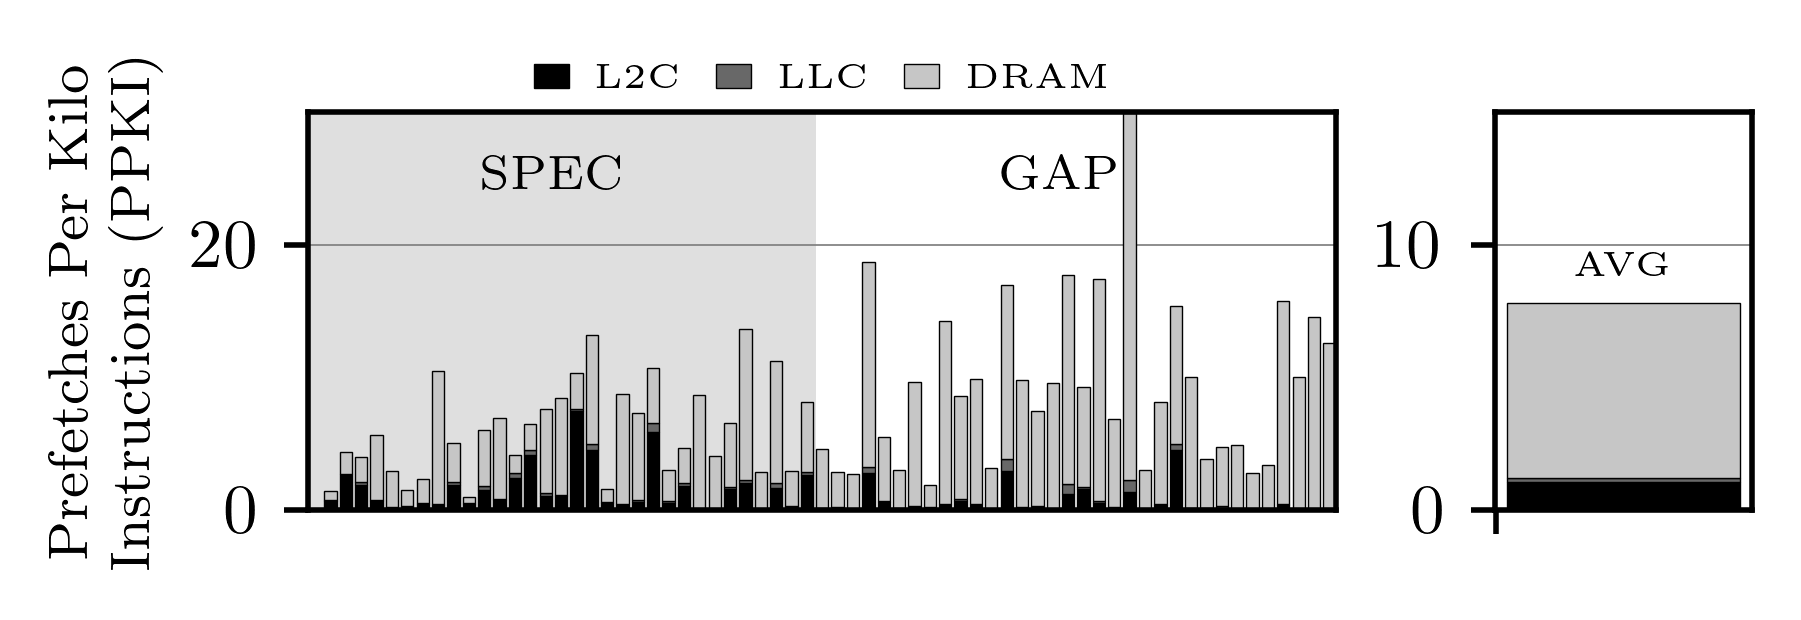

In [113]:
markers = ['.', 's', 'o', 'x', '>', '<', 'v', '^', 'h', 'D']

# Here is the actual plotting material.
fig_hit_miss_l1d = plt.figure(
    constrained_layout=True, figsize=set_size(fig_width), dpi=500)
fig_hit_miss_l1d.tight_layout(pad=0)
gs = GridSpec(nrows=1, ncols=5, figure=fig_hit_miss_l1d)

ax_l1d_useless_loc, ax_l1d_useless_loc_mean = fig_hit_miss_l1d.add_subplot(
    gs[0, :4]), fig_hit_miss_l1d.add_subplot(gs[0, 4:])
ax_l1d_useless_loc.margins(x=0, tight=True)

xticklabels = df_l1d_pref_useless.index.tolist()
xticklabels = [sub_re_trailing_sdc.sub(repl='', string=e) for e in xticklabels]
xticklabels = [sub_re_trailing_und.sub(
    repl=r'\_', string=e) for e in xticklabels]

key_list = df_l1d_pref_useless.columns.to_list()
# key_list = ['hermes_o_pc_based', 'popet_o', 'hermes_o_perceptron_pc_pfn']

cat_spacing = 0.075
bar_width, index = (1 - cat_spacing) / \
    len(key_list), np.arange(1, len(xticklabels) + 1)

colors = cm.get_cmap(plot_cmp)(np.linspace(
    0.0, 1.0, len(key_list) + 1, endpoint=True))[1:][::-1]

prev = np.array([0.0 for _ in range(len(df_l1d_pref_useless))])
bars = None

for i, (e, c, m) in enumerate(zip(key_list, colors, markers)):
    bars = ax_l1d_useless_loc.bar(index + (cat_spacing / 2),
                                  df_l1d_pref_useless[e],
                                  bottom=prev,
                                  edgecolor='black',
                                  linewidth=0.2,
                                  align='edge',
                                  label=labels_dict[e], color=c)

    prev += np.array(df_l1d_pref_useless[e].to_list())

ax_l1d_useless_loc.axvspan(xmin=0, xmax=len(
    df_l1d_pref_useless_spec) + 1, facecolor='grey', alpha=0.25, zorder=-1)
# ax_l1d_useless_loc.axvline(x=len(df_l1d_pref_useless_spec) + len(df_l1d_pref_useless_gapbs) + 1, color='red', linestyle='--', linewidth=0.35)

# Annotating the 5th to last bar of the plot.
ax_l1d_useless_loc.annotate(f'{prev[-4]:.2f}', (bars.patches[-4].get_x() + bars.patches[-4].get_width() / 2 - 3.5, 170
                                                ), ha='center', va='center', textcoords='offset points', xytext=(0, 9), size=4)

ax_l1d_useless_loc.set_xticks(index)
# ax_l1d_useless_loc.set_xticklabels(xticklabels, rotation=90, fontsize=5)
ax_l1d_useless_loc.set_xticklabels([])
ax_l1d_useless_loc.grid(
    color='grey', linestyle='-', linewidth=0.25, axis='y')
ax_l1d_useless_loc.set_axisbelow(True)

ax_l1d_useless_loc.set_ylabel(
    'Prefetches Per Kilo\nInstructions (PPKI)', fontsize=8)

ax_l1d_useless_loc.tick_params(axis='both')
ax_l1d_useless_loc.tick_params(labeltop=False)
ax_l1d_useless_loc.tick_params(axis='x',
                               which='both',
                               bottom=False,
                               top=False)

# ax_l1d_useless_loc.set_yscale('log')
ax_l1d_useless_loc.set_ylim([0.0, 30.0])

for tick in ax_l1d_useless_loc.xaxis.get_major_ticks():
    tick.label1.set_horizontalalignment('left')

ax_l1d_useless_loc.legend(loc='upper center', edgecolor='white', fancybox=False, framealpha=0.0, ncol=3,
                          bbox_to_anchor=(0.5, 1.2),
                          fontsize=5
                          )

# Annotating the benchmark suites on the plots.
ax_l1d_useless_loc.annotate(
    'SPEC', (len(spec_keys) / 2, 25), ha='center', va='center', size=7)
ax_l1d_useless_loc.annotate('GAP', (len(
    spec_keys) + len(gapbs_keys) / 2, 25), ha='center', va='center', size=7)

# Plotting the mean in a seperate subplot.
xticklabels = df_l1d_pref_useless_mean.index.to_list()
cat_spacing = 0.075
bar_width, index = (1 - cat_spacing) / \
    len(key_list), np.arange(1, len(xticklabels) + 1)

colors = cm.get_cmap(plot_cmp)(np.linspace(
    0.0, 1.0, len(key_list) + 1, endpoint=True))[1:][::-1]
prev = np.array([0.0 for _ in range(len(df_l1d_pref_useless_mean))])

for i, (e, c, m) in enumerate(zip(key_list, colors, markers)):
    bars = ax_l1d_useless_loc_mean.bar(index + (cat_spacing / 2),
                                       df_l1d_pref_useless_mean[e],
                                       bottom=prev,
                                       edgecolor='black',
                                       linewidth=0.2,
                                       align='edge',
                                       label=labels_dict[e], color=c)

    prev += df_l1d_pref_useless_mean[e]

ax_l1d_useless_loc_mean.set_ylim([0.0, 15.0])
ax_l1d_useless_loc_mean.set_xticks(index)
ax_l1d_useless_loc_mean.set_xticklabels([])
ax_l1d_useless_loc_mean.bar_label(ax_l1d_useless_loc_mean.containers[-1], labels=[
                                  'AVG'], label_type='edge', rotation=0, fontsize=5, padding=3)
ax_l1d_useless_loc_mean.grid(
    color='grey', linestyle='-', linewidth=0.25)
ax_l1d_useless_loc_mean.set_axisbelow(True)

plt.savefig('12_HPCA30_Paper/plots/evaluation/single_core_berti_l1d_pref_useless.pdf',
            format='pdf', dpi='figure')
plt.savefig('12_HPCA30_Paper/plots/evaluation/single_core_berti_l1d_pref_useless.png',
            format='png', dpi='figure')


In [114]:
dict_l1d_pref_useful_spec = {
    'l2c': [final_res_set_spec[-1].sets[0][k]['l1d_prefetcher']['useful']['l2c'] for k in spec_keys if k != 'mean'],
    'llc': [final_res_set_spec[-1].sets[0][k]['l1d_prefetcher']['useful']['llc'] for k in spec_keys if k != 'mean'],
    'dram': [final_res_set_spec[-1].sets[0][k]['l1d_prefetcher']['useful']['dram'] for k in spec_keys if k != 'mean'],
}

df_l1d_pref_useful_spec = pandas.DataFrame(
    dict_l1d_pref_useful_spec, columns=dict_l1d_pref_useful_spec.keys(), index=[k for k in spec_keys if k != 'mean'])

display(np.mean(df_l1d_pref_useful_spec))


/home/alexandre/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


l2c     0.385662
llc     0.116092
dram    1.611800
dtype: float64

In [115]:
dict_l1d_pref_useful_gapbs = {
    'l2c': [final_res_set_gapbs[-1].sets[0][k]['l1d_prefetcher']['useful']['l2c'] for k in gapbs_keys if k != 'mean'],
    'llc': [final_res_set_gapbs[-1].sets[0][k]['l1d_prefetcher']['useful']['llc'] for k in gapbs_keys if k != 'mean'],
    'dram': [final_res_set_gapbs[-1].sets[0][k]['l1d_prefetcher']['useful']['dram'] for k in gapbs_keys if k != 'mean'],
}

df_l1d_pref_useful_gapbs = pandas.DataFrame(
    dict_l1d_pref_useful_gapbs, columns=dict_l1d_pref_useful_gapbs.keys(), index=[k for k in gapbs_keys if k != 'mean'])

display(np.mean(df_l1d_pref_useful_gapbs))

/home/alexandre/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


l2c     0.077189
llc     0.135170
dram    1.941174
dtype: float64

In [116]:
df_l1d_pref_useful = pandas.concat(
    [df_l1d_pref_useful_spec, df_l1d_pref_useful_gapbs])

df_l1d_pref_useful_mean = pandas.DataFrame({
    'l2c': [np.mean(df_l1d_pref_useful['l2c'])],
    'llc': [np.mean(df_l1d_pref_useful['llc'])],
    'dram': [np.mean(df_l1d_pref_useful['dram'])],
}, index=['AVG'])

# df_l1d_pref_useful = pandas.concat([df_l1d_pref_useful, df_l1d_pref_useful_mean])

display(df_l1d_pref_useful)
display(df_l1d_pref_useful_mean)


,l2c,llc,dram
657.xz_s,0.043979,0.002885,0.021437
434.zeusmp,0.067860,0.028790,0.171240
456.hmmer,0.049632,0.034684,0.097419
481.wrf,0.223557,0.200876,1.106165
603.bwaves_s,0.003073,0.087330,0.982632
...,...,...,...
bc.kron.sdc,0.001117,0.115529,1.504207
pr.twitter.sdc,0.106927,0.075380,2.797364
pr.urand.sdc,0.000352,0.034646,1.387439
pr.kron.sdc,0.001466,0.027734,0.762969


,l2c,llc,dram
AVG,0.226752,0.12592,1.781478


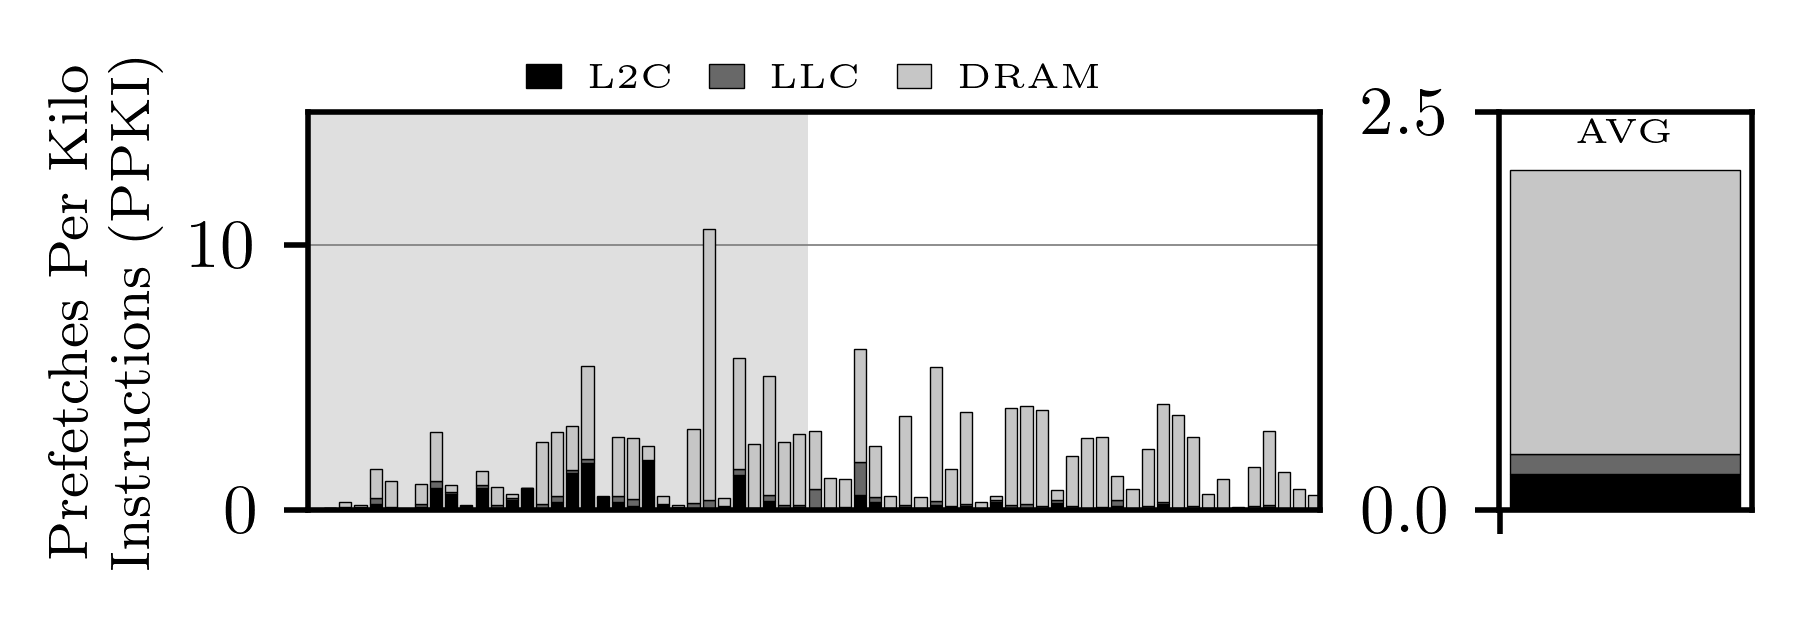

In [117]:
markers = ['.', 's', 'o', 'x', '>', '<', 'v', '^', 'h', 'D']

# Here is the actual plotting material.
fig_hit_miss_l1d = plt.figure(
    constrained_layout=True, figsize=set_size(fig_width), dpi=500)
fig_hit_miss_l1d.tight_layout(pad=0)
gs = GridSpec(nrows=1, ncols=5, figure=fig_hit_miss_l1d)

ax_l1d_useful_loc, ax_l1d_useful_loc_mean = fig_hit_miss_l1d.add_subplot(
    gs[0, :4]), fig_hit_miss_l1d.add_subplot(gs[0, 4:])
ax_l1d_useful_loc.margins(x=0, tight=True)

xticklabels = df_l1d_pref_useful.index.tolist()
xticklabels = [sub_re_trailing_sdc.sub(repl='', string=e) for e in xticklabels]
xticklabels = [sub_re_trailing_und.sub(
    repl=r'\_', string=e) for e in xticklabels]

key_list = df_l1d_pref_useful.columns.to_list()
# key_list = ['hermes_o_pc_based', 'popet_o', 'hermes_o_perceptron_pc_pfn']

cat_spacing = 0.075
bar_width, index = (1 - cat_spacing) / \
    len(key_list), np.arange(1, len(xticklabels) + 1)

colors = cm.get_cmap(plot_cmp)(np.linspace(
    0.0, 1.0, len(key_list) + 1, endpoint=True))[1:][::-1]

prev = np.array([0.0 for _ in range(len(df_l1d_pref_useful))])
bars = None

for i, (e, c, m) in enumerate(zip(key_list, colors, markers)):
    bars = ax_l1d_useful_loc.bar(index + (cat_spacing / 2),
                                  df_l1d_pref_useful[e],
                                  bottom=prev,
                                  edgecolor='black',
                                  linewidth=0.2,
                                  align='edge',
                                  label=labels_dict[e], color=c)

    prev += np.array(df_l1d_pref_useful[e].to_list())

ax_l1d_useful_loc.axvspan(xmin=0, xmax=len(
    df_l1d_pref_useful_spec) + 1, facecolor='grey', alpha=0.25, zorder=-1)
# ax_l1d_useful_loc.axvline(x=len(df_l1d_pref_useful_spec) + len(df_l1d_pref_useful_gapbs) + 1, color='red', linestyle='--', linewidth=0.35)

# Annotating the 5th to last bar of the plot.
ax_l1d_useful_loc.annotate(f'{prev[-4]:.2f}', (bars.patches[-4].get_x() + bars.patches[-4].get_width() / 2 - 3.5, 160
                                                ), ha='center', va='center', textcoords='offset points', xytext=(0, 9), size=4)

ax_l1d_useful_loc.set_xticks(index)
# ax_l1d_useful_loc.set_xticklabels(xticklabels, rotation=90, fontsize=5)
ax_l1d_useful_loc.set_xticklabels([])
ax_l1d_useful_loc.grid(
    color='grey', linestyle='-', linewidth=0.25, axis='y')
ax_l1d_useful_loc.set_axisbelow(True)

ax_l1d_useful_loc.set_ylabel(
    'Prefetches Per Kilo\nInstructions (PPKI)', fontsize=8)

ax_l1d_useful_loc.tick_params(axis='both')
ax_l1d_useful_loc.tick_params(labeltop=False)
ax_l1d_useful_loc.tick_params(axis='x',
                               which='both',
                               bottom=False,
                               top=False)

# ax_l1d_useful_loc.set_yscale('log')
ax_l1d_useful_loc.set_ylim([0.0, 15.0])

for tick in ax_l1d_useful_loc.xaxis.get_major_ticks():
    tick.label1.set_horizontalalignment('left')

ax_l1d_useful_loc.legend(loc='upper center', edgecolor='white', fancybox=False, framealpha=0.0, ncol=3,
                          bbox_to_anchor=(0.5, 1.2),
                          fontsize=5
                          )

# Annotating the benchmark suites on the plots.
ax_l1d_useful_loc.annotate(
    'SPEC', (len(spec_keys) / 2, 125), ha='center', va='center', size=7)
ax_l1d_useful_loc.annotate('GAP', (len(
    spec_keys) + len(gapbs_keys) / 2, 125), ha='center', va='center', size=7)

# Plotting the mean in a seperate subplot.
xticklabels = df_l1d_pref_useful_mean.index.to_list()
cat_spacing = 0.075
bar_width, index = (1 - cat_spacing) / \
    len(key_list), np.arange(1, len(xticklabels) + 1)

colors = cm.get_cmap(plot_cmp)(np.linspace(
    0.0, 1.0, len(key_list) + 1, endpoint=True))[1:][::-1]
prev = np.array([0.0 for _ in range(len(df_l1d_pref_useful_mean))])

for i, (e, c, m) in enumerate(zip(key_list, colors, markers)):
    bars = ax_l1d_useful_loc_mean.bar(index + (cat_spacing / 2),
                                       df_l1d_pref_useful_mean[e],
                                       bottom=prev,
                                       edgecolor='black',
                                       linewidth=0.2,
                                       align='edge',
                                       label=labels_dict[e], color=c)

    prev += df_l1d_pref_useful_mean[e]

ax_l1d_useful_loc_mean.yaxis.set_major_locator(MultipleLocator(2.5))
ax_l1d_useful_loc_mean.yaxis.set_major_formatter('{x:.1f}')
# ax_l1d_useful_loc_mean.yaxis.set_minor_locator(MultipleLocator(15))
# ax_l1d_useful_loc_mean.yaxis.set_minor_formatter('{x:.1f}')

ax_l1d_useful_loc_mean.set_ylim([0.0, 2.5])
ax_l1d_useful_loc_mean.set_xticks(index)
ax_l1d_useful_loc_mean.set_xticklabels([])
ax_l1d_useful_loc_mean.bar_label(ax_l1d_useful_loc_mean.containers[-1], labels=[
                                  'AVG'], label_type='edge', rotation=0, fontsize=5, padding=3)
ax_l1d_useful_loc_mean.grid(
    color='grey', linestyle='-', linewidth=0.25)
ax_l1d_useful_loc_mean.grid(True, which='minor', color='grey',
                             linestyle='--', linewidth=0.2, axis='y')
ax_l1d_useful_loc_mean.set_axisbelow(True)

plt.savefig('12_HPCA30_Paper/plots/evaluation/single_core_berti_l1d_pref_useful.pdf',
            format='pdf', dpi='figure')
plt.savefig('12_HPCA30_Paper/plots/evaluation/single_core_berti_l1d_pref_useful.png',
            format='png', dpi='figure')
